This is a group project with team members J. Chen, F. Mota, and T. Phu. In this notebook we use TensorFlow to compare the performance of varying neural network typologies and hyperparameter settings in image recognition using the MNIST data set. using Aurélien Géron's chapter 11 notebook for guidance--https://github.com/ageron/handson-ml/blob/master/11_deep_learning.ipynb.

In [1]:
# From earlier notebooks, plus some routines and snippets adapted from Aurélien Géron's chapter 11 notebook:
# https://github.com/ageron/handson-ml/blob/master/11_deep_learning.ipynb — Marked #AG

# Load libraries and initialize values

# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

# to make this notebook's output stable across runs — #AG
def reset_graph(seed=1):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# although we standardize X and y variables on input,
# we will fit the intercept term in the models
# Expect fitted values to be close to zero
SET_FIT_INTERCEPT = True

# import base packages into the namespace for this program
import numpy as np
import pandas as pd

# Import TensorFlow: Rather important for code focused on TensorFlow!
import tensorflow as tf

# Eventually we will want to switch to the Dense function from keras in place of tf.layers.dense
# So recommands a tf deprecation warning. This switch will await another day.
# from keras.layers import Dense

# modeling routines from Scikit Learn packages

from sklearn.datasets import fetch_mldata, fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

# from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor
# from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor
# import sklearn.linear_model
# from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoLarsIC
# from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
# from sklearn.tree import DecisionTreeRegressor, export_graphviz

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score
from sklearn.metrics import matthews_corrcoef, brier_score_loss
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics.scorer import make_scorer
# from sklearn.metrics import roc_curve, roc_auc_score  # Not relevant to a multiclass classifier
# from sklearn.metrics import precision_recall_curve, average_precision_score

from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler

from sklearn.utils.multiclass import unique_labels

import random
from scipy.stats import randint as sp_randint
from scipy.special import erfc, expit
import time
from functools import partial, wraps

# Let's comment out the math library. Stick with the numpy version of the function.

# from math import sqrt  # log function; sqrt for root mean-squared error calculation

# np.sqrt works on vectors and thus plays well with matplotlib
# Attempts to transform more than single numbers with math.sqrt often crash plt plots
# Speaking of plt… Here are libraries for visualizations

import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib inline
# import matplotlib
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

from mpl_toolkits.mplot3d import Axes3D
import graphviz
import pydot

# Sanity check: Echo output so that we know that this critical first chunk has run successfully
print("All libraries imported. RANDOM_SEED = {:d}".format(RANDOM_SEED))

All libraries imported. RANDOM_SEED = 1


In [2]:
# This is an exceptionally important line! We need an F1 scorer in place of ordinary "accuracy"

f1_scorer = make_scorer(f1_score, average = "micro", greater_is_better = True)

In [3]:
# Some initial housekeeping: Set up a nested decorator function to keep track of time

# Time decorator code adapted from:
#   https://stackoverflow.com/questions/3620943/measuring-elapsed-time-with-the-time-module
# Key changes:
#   time.monotonic() instead of time.time()
#   print_prof_data() function revamped to show function / calls / total / average / max in tabular format
#   ** A new functionality: being able to track the _category_ to which a called function belongs

PROF_DATA = {}
DATA_CATEGORIES = {}

def profile(tag = "default"):

    def profile_wrapper(fn):

        @wraps(fn)
        def with_profiling(*args, **kwargs):
            start_time = time.monotonic()
        
            ret = fn(*args, **kwargs)
        
            elapsed_time = time.monotonic() - start_time

            if fn.__name__ not in PROF_DATA:
                PROF_DATA[fn.__name__] = [0, []]
            PROF_DATA[fn.__name__][0] += 1
            PROF_DATA[fn.__name__][1].append(elapsed_time)
            if fn.__name__ not in DATA_CATEGORIES:
                DATA_CATEGORIES[fn.__name__] = tag

            return ret

        return with_profiling

    return profile_wrapper

def print_prof_data():
    print("\n{:>20}\t{:>10}\t{:>8}\t{:>10}\t{:>10}\t{:>10}\t{:>10}".format("Function", "Category", "Calls", "Total", "Average", "Std dev", "Maximum"))
    print(114 * "_" + "\n")
    total_calls = 0
    grand_time = 0
    for fname, data in PROF_DATA.items():
        total_calls += data[0]
        total_time = sum(data[1])
        grand_time += total_time
        avg_time = np.mean(data[1])
        std_time = np.std(data[1])
        max_time = max(data[1])
        print("{:>20s}\t{:>10s}\t{:8d}\t{:10.4f}\t{:10.4f}\t{:10.4f}\t{:10.4f}".format(fname, DATA_CATEGORIES[fname], data[0], total_time, avg_time, std_time, max_time))
    print(114 * "_")
    print("\n{:>20}\t{:>10s}\t{:8d}\t{:10.4f}\t{:10.4f}".format("ALL FUNCTIONS", "***", total_calls, grand_time, grand_time / total_calls))

def clear_prof_data():
    global PROF_DATA, DATA_CATEGORIES
    PROF_DATA = {}
    DATA_CATEGORIES = {}

In [4]:
# Test the time decorator function — Set up

@profile("base")
def factorial(n):
    """Assumes n is an integer > 0
        Returns n!"""
    if n == 0:
        return 1
    elif n == 1:
        return n
    else:
        return n * factorial(n - 1)

@profile("base")
def permutations(n, r):
    """ Assumes n, k are integers > 0
        Returns nPr """
    nPr = factorial(n)/factorial(n - r)
    nPr = int(round(nPr))
    return nPr

@profile("base")
def combinations(n, r):
    """ Assumes n, k are integers > 0
        Returns nCr """
    nCr = permutations(n, r)/factorial(r)
    nCr = int(round(nCr))
    return nCr

# Test the time decorator function — Write a tiny Fibonnaci triangle

for i in range(0, 13):
    for j in range(i + 1):
        print(combinations(i, j), "\t", end = "")
        # print("C({:d}, {:d}) = {:d}\t".format(i, j, combinations(i, j)), end = "")
    print("\n")

print_prof_data()

print("\nNow clearing the timekeeping cache so that we keep accurate track of machine-learning tasks …")
clear_prof_data()

1 	

1 	1 	

1 	2 	1 	

1 	3 	3 	1 	

1 	4 	6 	4 	1 	

1 	5 	10 	10 	5 	1 	

1 	6 	15 	20 	15 	6 	1 	

1 	7 	21 	35 	35 	21 	7 	1 	

1 	8 	28 	56 	70 	56 	28 	8 	1 	

1 	9 	36 	84 	126 	126 	84 	36 	9 	1 	

1 	10 	45 	120 	210 	252 	210 	120 	45 	10 	1 	

1 	11 	55 	165 	330 	462 	462 	330 	165 	55 	11 	1 	

1 	12 	66 	220 	495 	792 	924 	792 	495 	220 	66 	12 	1 	


            Function	  Category	   Calls	     Total	   Average	   Std dev	   Maximum
__________________________________________________________________________________________________________________

           factorial	      base	    1483	    0.0000	    0.0000	    0.0000	    0.0000
        permutations	      base	      91	    0.0000	    0.0000	    0.0000	    0.0000
        combinations	      base	      91	    0.0000	    0.0000	    0.0000	    0.0000
__________________________________________________________________________________________________________________

       ALL FUNCTIONS	       ***	    1665	    0.0000	    0.

In [5]:
# We now set up some basic functions for reporting outcomes throughout the program
# For timekeeping purposes through @profile(tag), let's call this category "scoreboard"

@profile("scoreboard")
def purple_haze(y_true, y_pred, classes, standardize = False, title = None, file_name = "default",
                cmap = plt.cm.plasma, python_37 = True):
    
    # This code enables the display of the confusion matrix in graphic format
    # Code adapted from SciKit-Learn documentation:
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    # I include a patch 
    
    if not title:
        if standardize:
            title = "Standardized confusion matrix"
        else:
            title = "Unstandardized confusion matrix"
    title += "\n"
    cm = confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]
    if standardize:
        np.fill_diagonal(cm, 0)
        cm = cm.astype("float") / cm.sum(axis = 1)[:, np.newaxis]
        
    # Sklearn documentation offers to print the confusion matrix. Pass for now.
    # print(title)
    # print(cm)
    
    fig, ax = plt.subplots(figsize = (9, 9))
    im = ax.imshow(cm, interpolation = "nearest", cmap = cmap)
    ax.figure.colorbar(im, ax = ax)
    yticks_range = np.arange(-0.5, cm.shape[0]) if python_37 else np.arange(-0.5, cm.shape[0] + 0.5)
    ax.set(xticks = np.arange(cm.shape[1]), yticks = yticks_range,
           xticklabels = classes, yticklabels = classes, title = title,
           ylabel = "True label\n", xlabel = "\nPredicted label")
    plt.setp(ax.get_xticklabels(), rotation = 0, ha = "right",
             rotation_mode = "anchor")
    fmt = ".3f" if standardize else "d"
    thresh = cm.max() / 2 # if not standardize else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha = "center", va = "center",
                    color = "black" if cm[i, j] > thresh else "white")
    fig.tight_layout()
    plt.savefig(file_name + "_cm.png")
    plt.savefig(file_name + "_cm.pdf")
    return ax

We are now ready to begin developing and testing dense neural networks (DNNs). We start by downloading MNIST and running it on TensorFlow's high-level API as a warmup exercise. We will then train and test DNNs with TensorFlow's lower-level Python, as described by Géron in the latter half of chapter 10 of his textbook (pp. 269 & ff.).

In [6]:
# Let's start by loading mnist and preparing it as we did in Assignment 5 for use with SciKit-Learn
# It's not worth worrying about whether mnist can itself be accessed later. We won't need to do that.
# The name of this phase of our code is: tf_basic

@profile("setup")
def mnist_prep():
    global X, y, X_train, X_test, y_train, y_test
    mnist = fetch_openml('mnist_784', version = 1)
    # mnist  # This echoes the MNIST dataset
    # mnist.keys()  # dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])
    X, y = mnist["data"], mnist["target"]
    
    # Recast y as integers
    X = X.astype(np.int32)
    y = y.astype(np.int32)
    
    # Split mnist into training and test sets
    X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

mnist_prep()  # Call the mnist preparation function so that this phase of the program has data to play with

In [7]:
@profile("setup")
def minmax_scale(train_features, test_features):
    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(train_features)
    scaled_test = scaler.transform(test_features)
    scaled_train = np.float32(scaled_train)
    scaled_test = np.float32(scaled_test)
    return scaled_train, scaled_test

scaled_X_train, scaled_X_test = minmax_scale(X_train, X_test)

In [8]:
@profile("sklearn")
def mlp_activation_search(features, target):
    param_grid = {"activation": ["relu", "tanh", "logistic"]}
    mlp_activation_search = GridSearchCV(MLPClassifier(random_state = RANDOM_SEED, alpha = 0.0001,
                                                          hidden_layer_sizes = (25, ), max_iter = 500),
                                            param_grid, return_train_score = True, cv = 3, scoring = f1_scorer,
                                            iid = False)
    mlp_activation_fit = mlp_activation_search.fit(features, target)
    return mlp_activation_fit

In [9]:
mlp_activation = mlp_activation_search(scaled_X_train, y_train)
mlp_activation_results = mlp_activation.cv_results_
mlp_activation.best_estimator_

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(25,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=500, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [10]:
mlp_activation_frame = pd.DataFrame(mlp_activation_results)
mlp_activation_frame

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,88.078321,4.836538,0.096926,0.002501,relu,{'activation': 'relu'},0.952260,0.946447,0.949592,0.949433,0.002376,1,0.998225,0.999725,1.0000,0.999317,0.000780
1,85.496751,3.602300,0.095588,0.003408,tanh,{'activation': 'tanh'},0.943861,0.946397,0.944792,0.945017,0.001048,2,1.000000,0.999975,0.9999,0.999958,0.000042
2,149.520787,6.862890,0.094753,0.003752,logistic,{'activation': 'logistic'},0.941762,0.943097,0.943492,0.942783,0.000740,3,0.999825,0.999725,0.9997,0.999750,0.000054


In [11]:
mlp_activation_frame.rename(columns = {"param_activation": "activation", "mean_test_score": "test_score", "mean_train_score": "train_score",
                                          "mean_fit_time": "fit_time", "mean_score_time": "score_time"},
                                          inplace = True)
mlp_activation_frame["train_minus_test"] = mlp_activation_frame["train_score"] - mlp_activation_frame["test_score"]
mlp_activation_frame["total_time"] = mlp_activation_frame["fit_time"] + mlp_activation_frame["score_time"]
mlp_activation_frame["standardized_time"] = mlp_activation_frame["total_time"].map(lambda x: x / mlp_activation_frame.total_time.sum())

In [12]:
mlp_act_frame = mlp_activation_frame.loc[:, ["rank_test_score", "activation", "test_score", "train_score", "train_minus_test", "fit_time", "score_time", "total_time", "standardized_time"]].sort_values(by = "rank_test_score")
mlp_act_frame

,rank_test_score,activation,test_score,train_score,train_minus_test,fit_time,score_time,total_time,standardized_time
0,1,relu,0.949433,0.999317,0.049884,88.078321,0.096926,88.175247,0.272665
1,2,tanh,0.945017,0.999958,0.054942,85.496751,0.095588,85.592339,0.264678
2,3,logistic,0.942783,0.999750,0.056967,149.520787,0.094753,149.615540,0.462657


On this admittedly simple test, the relu function appears to offer superlative performance, and at (much) greater processing efficiency, relative to the logistic and hyperbolic tangent functions. This simplifies our search space for a test of alpha and network topology. Only relu will enter that next round.

In [13]:
# Having chosen relu as our Pareto-superior activation function …
#   … we can refocus the hyperparameter search on alpha and network topology

@profile("sklearn")
def mlp_alpha_search(features, target):
    param_grid = {"alpha": [0.003, 0.004, 0.005], "hidden_layer_sizes": [(100,), (50, 50), (33, 33, 33)]}
    mlp_alpha_search = GridSearchCV(MLPClassifier(random_state = RANDOM_SEED, activation = "relu"),
                                    param_grid, return_train_score = True, cv = 3, scoring = f1_scorer, iid = False)
    mlp_alpha_fit = mlp_alpha_search.fit(features, target)
    return mlp_alpha_fit

In [14]:
mlp_alpha = mlp_alpha_search(scaled_X_train, y_train)
mlp_alpha_results = mlp_alpha.cv_results_
mlp_alpha.best_estimator_

MLPClassifier(activation='relu', alpha=0.005, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [15]:
mlp_alpha_frame = pd.DataFrame(mlp_alpha_results)
mlp_alpha_frame

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,61.296825,4.296025,0.130849,0.002836,0.003,"(100,)","{'alpha': 0.003, 'hidden_layer_sizes': (100,)}",0.975505,0.975649,0.975196,0.975450,0.000189,2,1.0,1.000000,1.000000,1.000000,0.000000
1,43.706037,4.299591,0.124164,0.009156,0.003,"(50, 50)","{'alpha': 0.003, 'hidden_layer_sizes': (50, 50)}",0.972356,0.970149,0.970896,0.971133,0.000917,5,1.0,1.000000,1.000000,1.000000,0.000000
2,47.397360,3.002804,0.112634,0.002725,0.003,"(33, 33, 33)","{'alpha': 0.003, 'hidden_layer_sizes': (33, 33...",0.963407,0.962548,0.964995,0.963650,0.001013,9,1.0,1.000000,1.000000,1.000000,0.000000
3,62.401628,7.132060,0.128177,0.004413,0.004,"(100,)","{'alpha': 0.004, 'hidden_layer_sizes': (100,)}",0.975455,0.974449,0.975596,0.975167,0.000511,3,1.0,1.000000,0.999975,0.999992,0.000012
4,43.470206,5.239640,0.119484,0.005965,0.004,"(50, 50)","{'alpha': 0.004, 'hidden_layer_sizes': (50, 50)}",0.973305,0.969898,0.968295,0.970500,0.002089,6,1.0,0.999825,0.999025,0.999617,0.000424
5,54.257530,1.046230,0.114476,0.001852,0.004,"(33, 33, 33)","{'alpha': 0.004, 'hidden_layer_sizes': (33, 33...",0.963407,0.964498,0.965395,0.964433,0.000813,8,1.0,1.000000,1.000000,1.000000,0.000000
6,75.247518,10.271704,0.124666,0.007683,0.005,"(100,)","{'alpha': 0.005, 'hidden_layer_sizes': (100,)}",0.976555,0.973949,0.976947,0.975817,0.001330,1,1.0,0.999800,1.000000,0.999933,0.000094
7,43.622407,3.832017,0.117814,0.001083,0.005,"(50, 50)","{'alpha': 0.005, 'hidden_layer_sizes': (50, 50)}",0.972755,0.969448,0.971546,0.971250,0.001366,4,1.0,1.000000,1.000000,1.000000,0.000000
8,49.709632,3.289983,0.112300,0.001418,0.005,"(33, 33, 33)","{'alpha': 0.005, 'hidden_layer_sizes': (33, 33...",0.965357,0.964748,0.964745,0.964950,0.000288,7,1.0,1.000000,1.000000,1.000000,0.000000


In [16]:
mlp_alpha_frame.rename(columns = {"param_alpha": "alpha", "param_hidden_layer_sizes": "hidden_layer_sizes",
                                  "mean_test_score": "test_score", "mean_train_score": "train_score",
                                  "mean_fit_time": "fit_time", "mean_score_time": "score_time"}, inplace = True)
mlp_alpha_frame["train_minus_test"] = mlp_alpha_frame["train_score"] - mlp_alpha_frame["test_score"]
mlp_alpha_frame["total_time"] = mlp_alpha_frame["fit_time"] + mlp_alpha_frame["score_time"]
mlp_alpha_frame["standardized_time"] = mlp_alpha_frame["total_time"].map(lambda x: x / mlp_alpha_frame.total_time.sum())

In [17]:
mlp_a_frame = mlp_alpha_frame.loc[:, ["rank_test_score", "alpha", "hidden_layer_sizes", "test_score", "train_score", "train_minus_test", "fit_time", "score_time", "total_time", "standardized_time"]].sort_values(by = "rank_test_score")
mlp_a_frame

,rank_test_score,alpha,hidden_layer_sizes,test_score,train_score,train_minus_test,fit_time,score_time,total_time,standardized_time
6,1,0.005,"(100,)",0.975817,0.999933,0.024117,75.247518,0.124666,75.372184,0.156311
0,2,0.003,"(100,)",0.975450,1.000000,0.024550,61.296825,0.130849,61.427674,0.127392
3,3,0.004,"(100,)",0.975167,0.999992,0.024825,62.401628,0.128177,62.529805,0.129678
7,4,0.005,"(50, 50)",0.971250,1.000000,0.028750,43.622407,0.117814,43.740221,0.090711
1,5,0.003,"(50, 50)",0.971133,1.000000,0.028867,43.706037,0.124164,43.830201,0.090897
4,6,0.004,"(50, 50)",0.970500,0.999617,0.029117,43.470206,0.119484,43.589689,0.090399
8,7,0.005,"(33, 33, 33)",0.964950,1.000000,0.035050,49.709632,0.112300,49.821932,0.103323
5,8,0.004,"(33, 33, 33)",0.964433,1.000000,0.035567,54.257530,0.114476,54.372006,0.112760
2,9,0.003,"(33, 33, 33)",0.963650,1.000000,0.036350,47.397360,0.112634,47.509993,0.098529


Without exhausting all of sklearn's hyperparameters and cross-validation tools, we appear to have found what is at least a workable MLP model. Before we leave SciKit-Learn and move to TensorFlow for the balance of our analysis, we will take the full measure of this "winning" SciKit-Learn model so that it might serve as a benchmark for our work in TensorFlow.

In [18]:
# Out of the box MLPClassifier() functions. Use them on the way out the door from sklearn.
# Then we move on to TensorFlow …

@profile("sklearn")
def mlp_clf(features):
    mlp = MLPClassifier()
    return mlp

@profile("sklearn")
def mlp_fit(mlp_model, features, target):
    mlp_model.fit(features, target)

In [19]:
# Scoring functions

def specificity_score(y_true, y_pred):
    ss = confusion_matrix(y_true, y_pred)[0, 0] / sum(confusion_matrix(y_true, y_pred)[0])
    return ss

def bookmaker_informedness(y_true, y_pred):
    bm = recall_score(y_true, y_pred, average = None) + specificity_score(y_true, y_pred) - 1
    return bm

@profile("sklearn")
def mlp_report(mlp_model, train_features, train_target, test_features, test_target, title):
    y_pred = mlp_model.predict(test_features)

    print("Scorecard for SciKit-Learn's " + title + " MLP classifier:\n")
    print("{:>25s}\t{:.6f}".format("Training set score", mlp_model.score(train_features, train_target)))
    print("{:>25s}\t{:.6f}".format("Test set score", mlp_model.score(test_features, test_target)))
    print("{:>25s}\t{:.6f}".format("Precision", precision_score(test_target, y_pred, average = None).mean()))
    print("{:>25s}\t{:.6f}".format("Recall", recall_score(test_target, y_pred, average = None).mean()))
    print("{:>25s}\t{:.6f}".format("F1 score", f1_score(test_target, y_pred, average = None).mean()))
    print("{:>25s}\t{:.6f}".format("F2 score", fbeta_score(test_target, y_pred, beta = 2, average = None).mean()))
    print("{:>25s}\t{:.6f}".format("Specificity", specificity_score(test_target, y_pred)))
    print("{:>25s}\t{:.6f}".format("Bookmaker informedness", bookmaker_informedness(test_target, y_pred).mean()))
    print("{:>25s}\t{:.6f}".format("Matthews correlation", matthews_corrcoef(test_target, y_pred)))

In [20]:
mlp_best = mlp_alpha.best_estimator_  # This replaces the generic function call to mlp_clf

# mlp_scaled = mlp_clf(scaled_X_train)
mlp_fit(mlp_best, scaled_X_train, y_train)
mlp_report(mlp_best, scaled_X_train, y_train, scaled_X_test, y_test, "best")

Scorecard for SciKit-Learn's best MLP classifier:

       Training set score	1.000000
           Test set score	0.979800
                Precision	0.979811
                   Recall	0.979607
                 F1 score	0.979692
                 F2 score	0.979637
              Specificity	0.989796
   Bookmaker informedness	0.969403
     Matthews correlation	0.977550


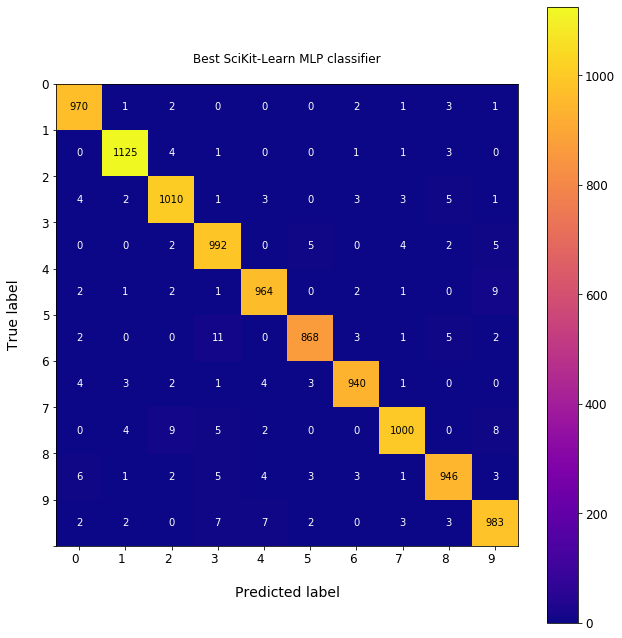

In [21]:
y_pred = mlp_best.predict(scaled_X_test)

purple_haze(y_test, y_pred, classes = unique_labels(y_pred), title = "Best SciKit-Learn MLP classifier",
            file_name = "mlp_best", python_37 = False)

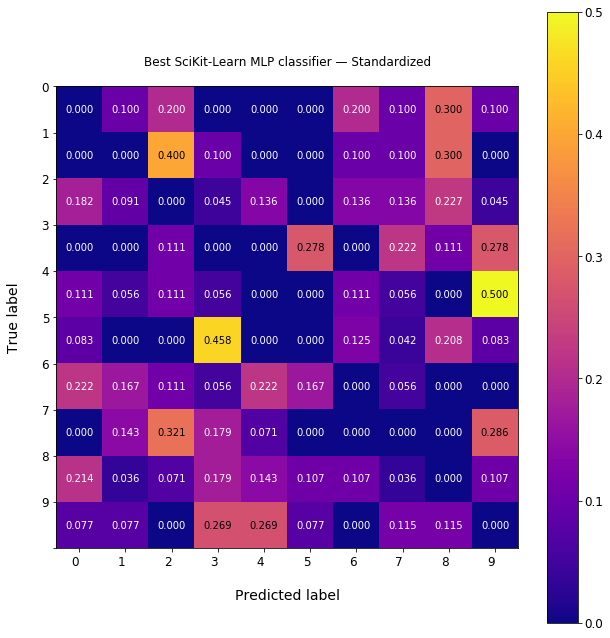

In [22]:
purple_haze(y_test, y_pred, classes = unique_labels(y_pred), title = "Best SciKit-Learn MLP classifier — Standardized",
            file_name = "mlp_best_standard", standardize = True, python_37 = False)

"The simplest way to train an MLP with TensorFlow is to use the high-level API TF.Learn." With that admonition from Géron, p. 268, and a boost from code he provides in his textbook, we will produce a single off-the-shelf dense neural network (DNN) with the tf.contrib package. Géron does warn that the tf.contrib package is experimental and can change or vanish without notice.

In [23]:
# Off-the-shelf, high-level TensorFlow DNN
# As noted, code adapted from Géron at p. 268 

@profile("tf_basic")
def dnn_clf(features):
    feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(features)
    dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units = [300, 100], n_classes = 10,
                                             feature_columns = feature_cols)
    dnn_clf = tf.contrib.learn.SKCompat(dnn_clf)
    return dnn_clf

@profile("tf_basic")
def dnn_fit(dnn_model, features, target):
    dnn_model.fit(features, target, batch_size = 50, steps = 40000)
    
@profile("tf_basic")
def dnn_report(dnn_model, train_features, train_target, test_features, test_target):
    y_pred = dnn_model.predict(test_features)["classes"]
    print("Scorecard for TensorFlow's basic DNN classifier:\n")
    print("{:>25s}\t{:6f}".format("Training set score", dnn_model.score(train_features, train_target)["accuracy"]))
    print("{:>25s}\t{:6f}".format("Test set score", dnn_model.score(test_features, test_target)["accuracy"]))
    print("{:>25s}\t{:.6f}".format("Precision", precision_score(test_target, y_pred, average = None).mean()))
    print("{:>25s}\t{:.6f}".format("Recall", recall_score(test_target, y_pred, average = None).mean()))
    print("{:>25s}\t{:.6f}".format("F1 score", f1_score(test_target, y_pred, average = None).mean()))
    print("{:>25s}\t{:.6f}".format("F2 score", fbeta_score(test_target, y_pred, beta = 2, average = None).mean()))
    print("{:>25s}\t{:.6f}".format("Specificity", specificity_score(test_target, y_pred)))
    print("{:>25s}\t{:.6f}".format("Bookmaker informedness", bookmaker_informedness(test_target, y_pred).mean()))
    print("{:>25s}\t{:.6f}".format("Matthews correlation", matthews_corrcoef(test_target, y_pred)))    

In [24]:
dnn_scaled = dnn_clf(scaled_X_train)
dnn_fit(dnn_scaled, scaled_X_train, y_train)
dnn_report(dnn_scaled, scaled_X_train, y_train, scaled_X_test, y_test)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please specify feature columns explicitly.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please feed input to tf.data to support dask.
Instructions for updating:
Please access pandas data directly.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please convert numpy dtypes explicitly.
Instructions for updating:
Please specify feature columns explicitly.
Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estima

INFO:tensorflow:loss = 0.05571519, step = 1001 (0.222 sec)
INFO:tensorflow:global_step/sec: 449.25
INFO:tensorflow:loss = 0.3461368, step = 1101 (0.223 sec)
INFO:tensorflow:global_step/sec: 454.367
INFO:tensorflow:loss = 0.19697699, step = 1201 (0.220 sec)
INFO:tensorflow:global_step/sec: 460.661
INFO:tensorflow:loss = 0.097549334, step = 1301 (0.218 sec)
INFO:tensorflow:global_step/sec: 442.278
INFO:tensorflow:loss = 0.1639948, step = 1401 (0.226 sec)
INFO:tensorflow:global_step/sec: 456.445
INFO:tensorflow:loss = 0.16261387, step = 1501 (0.219 sec)
INFO:tensorflow:global_step/sec: 456.444
INFO:tensorflow:loss = 0.22484486, step = 1601 (0.219 sec)
INFO:tensorflow:global_step/sec: 452.308
INFO:tensorflow:loss = 0.081374295, step = 1701 (0.221 sec)
INFO:tensorflow:global_step/sec: 460.663
INFO:tensorflow:loss = 0.06572614, step = 1801 (0.217 sec)
INFO:tensorflow:global_step/sec: 458.544
INFO:tensorflow:loss = 0.038910665, step = 1901 (0.218 sec)
INFO:tensorflow:global_step/sec: 451.283


INFO:tensorflow:global_step/sec: 303.141
INFO:tensorflow:loss = 0.028725727, step = 9201 (0.330 sec)
INFO:tensorflow:global_step/sec: 287.831
INFO:tensorflow:loss = 0.003511235, step = 9301 (0.346 sec)
INFO:tensorflow:global_step/sec: 315.612
INFO:tensorflow:loss = 0.0024597512, step = 9401 (0.317 sec)
INFO:tensorflow:global_step/sec: 318.637
INFO:tensorflow:loss = 0.0089127375, step = 9501 (0.314 sec)
INFO:tensorflow:global_step/sec: 319.147
INFO:tensorflow:loss = 0.01558857, step = 9601 (0.313 sec)
INFO:tensorflow:global_step/sec: 319.147
INFO:tensorflow:loss = 0.0037960582, step = 9701 (0.313 sec)
INFO:tensorflow:global_step/sec: 315.611
INFO:tensorflow:loss = 0.025794948, step = 9801 (0.316 sec)
INFO:tensorflow:global_step/sec: 318.13
INFO:tensorflow:loss = 0.0030693328, step = 9901 (0.315 sec)
INFO:tensorflow:global_step/sec: 325.395
INFO:tensorflow:loss = 0.0035835768, step = 10001 (0.308 sec)
INFO:tensorflow:global_step/sec: 321.721
INFO:tensorflow:loss = 0.010145721, step = 101

INFO:tensorflow:loss = 0.0045845406, step = 17201 (0.258 sec)
INFO:tensorflow:global_step/sec: 390.346
INFO:tensorflow:loss = 0.0008418363, step = 17301 (0.256 sec)
INFO:tensorflow:global_step/sec: 400.536
INFO:tensorflow:loss = 0.0025504497, step = 17401 (0.250 sec)
INFO:tensorflow:global_step/sec: 400.536
INFO:tensorflow:loss = 0.008126852, step = 17501 (0.249 sec)
INFO:tensorflow:global_step/sec: 394.984
INFO:tensorflow:loss = 0.0044086827, step = 17601 (0.253 sec)
INFO:tensorflow:global_step/sec: 403.779
INFO:tensorflow:loss = 0.0011543718, step = 17701 (0.248 sec)
INFO:tensorflow:global_step/sec: 404.598
INFO:tensorflow:loss = 0.0020143131, step = 17801 (0.247 sec)
INFO:tensorflow:global_step/sec: 407.075
INFO:tensorflow:loss = 0.007301314, step = 17901 (0.246 sec)
INFO:tensorflow:global_step/sec: 391.112
INFO:tensorflow:loss = 0.0041905018, step = 18001 (0.256 sec)
INFO:tensorflow:global_step/sec: 402.963
INFO:tensorflow:loss = 0.00259054, step = 18101 (0.248 sec)
INFO:tensorflow

INFO:tensorflow:loss = 0.0018691174, step = 25201 (0.231 sec)
INFO:tensorflow:global_step/sec: 398.934
INFO:tensorflow:loss = 0.00061008247, step = 25301 (0.251 sec)
INFO:tensorflow:global_step/sec: 379.937
INFO:tensorflow:loss = 0.0015892186, step = 25401 (0.263 sec)
INFO:tensorflow:global_step/sec: 433.624
INFO:tensorflow:loss = 0.00040383494, step = 25501 (0.231 sec)
INFO:tensorflow:global_step/sec: 439.354
INFO:tensorflow:loss = 0.0004162389, step = 25601 (0.228 sec)
INFO:tensorflow:global_step/sec: 426.211
INFO:tensorflow:loss = 0.00035717536, step = 25701 (0.235 sec)
INFO:tensorflow:global_step/sec: 442.278
INFO:tensorflow:loss = 0.0008808214, step = 25801 (0.226 sec)
INFO:tensorflow:global_step/sec: 441.299
INFO:tensorflow:loss = 0.0008183491, step = 25901 (0.227 sec)
INFO:tensorflow:global_step/sec: 425.302
INFO:tensorflow:loss = 0.0005249672, step = 26001 (0.235 sec)
INFO:tensorflow:global_step/sec: 446.234
INFO:tensorflow:loss = 0.0011622378, step = 26101 (0.224 sec)
INFO:ten

INFO:tensorflow:global_step/sec: 412.121
INFO:tensorflow:loss = 0.0004484309, step = 33201 (0.243 sec)
INFO:tensorflow:global_step/sec: 401.342
INFO:tensorflow:loss = 0.00013939035, step = 33301 (0.249 sec)
INFO:tensorflow:global_step/sec: 415.556
INFO:tensorflow:loss = 0.0008331795, step = 33401 (0.241 sec)
INFO:tensorflow:global_step/sec: 417.295
INFO:tensorflow:loss = 0.0009634245, step = 33501 (0.240 sec)
INFO:tensorflow:global_step/sec: 412.122
INFO:tensorflow:loss = 0.0021068088, step = 33601 (0.243 sec)
INFO:tensorflow:global_step/sec: 411.272
INFO:tensorflow:loss = 0.0008900857, step = 33701 (0.244 sec)
INFO:tensorflow:global_step/sec: 421.706
INFO:tensorflow:loss = 0.00022727564, step = 33801 (0.237 sec)
INFO:tensorflow:global_step/sec: 415.556
INFO:tensorflow:loss = 4.559187e-05, step = 33901 (0.241 sec)
INFO:tensorflow:global_step/sec: 421.706
INFO:tensorflow:loss = 0.0008089358, step = 34001 (0.237 sec)
INFO:tensorflow:global_step/sec: 414.692
INFO:tensorflow:loss = 0.00018

       Training set score	1.000000
INFO:tensorflow:Starting evaluation at 2019-08-03T06:01:02Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\tphu\AppData\Local\Temp\tmpl0ex8a94\model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-03-06:01:03
INFO:tensorflow:Saving dict for global step 40000: accuracy = 0.9838, global_step = 40000, loss = 0.065607965
           Test set score	0.983800
                Precision	0.983673
                   Recall	0.983704
                 F1 score	0.983685
                 F2 score	0.983695
              Specificity	0.989796
   Bookmaker informedness	0.973500
     Matthews correlation	0.981994


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\tphu\AppData\Local\Temp\tmpl0ex8a94\model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


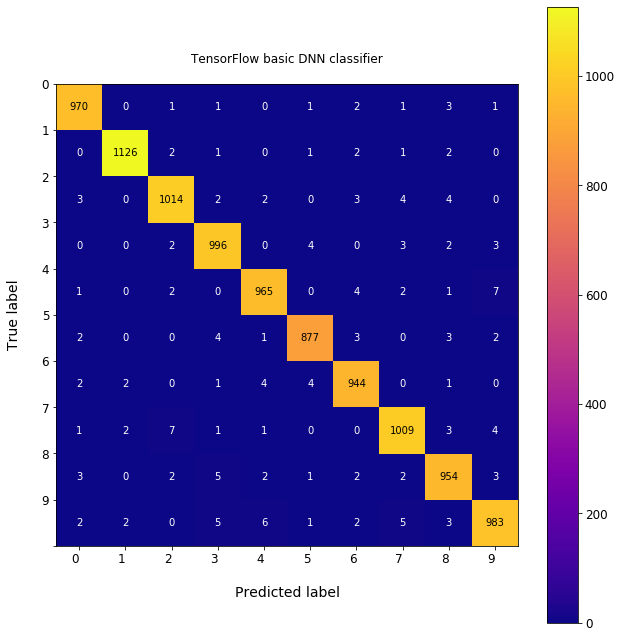

In [25]:
y_pred = dnn_scaled.predict(scaled_X_test)["classes"]

purple_haze(y_test, y_pred, classes = unique_labels(y_pred), title = "TensorFlow basic DNN classifier",
            file_name = "tf_basic", python_37 = False)

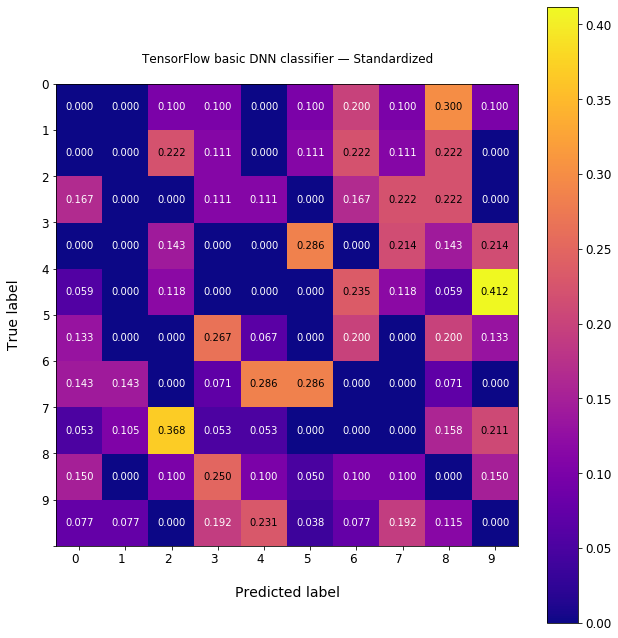

In [26]:
purple_haze(y_test, y_pred, classes = unique_labels(y_pred), title = "TensorFlow basic DNN classifier — Standardized",
            file_name = "tf_basic_standard", standardize = True, python_37 = False)

Time to move into plain, low-level TensorFlow! We borrow heavily from Géron's textbook (pp. 269-275) and from his GitHub site, particularly https://github.com/ageron/handson-ml/blob/master/11_deep_learning.ipynb. TensorFlow having beein imported, we start by defining a basic dense neural network.

In [27]:
### Load TensorFlow's version of MNIST! ###
# Warning! Géron, p. 273 has been deprecated
# Use data from Keras instead
# Code via Géron's chapter 11 GitHub page (URL above)

@profile("tf_setup")
def tf_mnist():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
    X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
    y_train = y_train.astype(np.int32)
    y_test = y_test.astype(np.int32)
    X_valid, X_train = X_train[:5000], X_train[5000:]
    y_valid, y_train = y_train[:5000], y_train[5000:]
    return X_train, X_test, X_valid, y_train, y_test, y_valid

X_train, X_test, X_valid, y_train, y_test, y_valid = tf_mnist()

In [28]:
# Define shuffle_batch function
# Via the Géron GitHub
# This would appear after the global_variables_initializer in direct code

@profile("tf_setup")
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

Now that preliminary tasks such as loading TensorFlow's version of MNIST have been completed, we will use Aurélien Géron's demonstration code to illustrate the four leading activation functions:

1) relu: The rectified linear unit function

2) leaky_rely: A variant of relu where values below x = 0 are negative

3) elu: The exponential linear unit

4) selu: The scaled exponential linear unit

5) tanh: Hyperbolic tangent

6) sigmoid: The logistic function

In [29]:
def relu(z):
    return np.maximum(0, z)

In [30]:
def leaky_relu_plot(z, alpha = 0.05):
    return np.maximum(z, alpha * z)

def leaky_relu(z, alpha = 0.01, name = None):
    return tf.maximum(z, alpha * z, name = name)

In [31]:
def elu(z, alpha = 1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

In [32]:
def selu(z):
    alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) -1)
    scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)
    return scale_0_1 * elu(z, alpha_0_1)

In [33]:
def tanh(z):
    return np.tanh(z)

In [34]:
def sigmoid(z):
    return expit(z)

In [35]:
@profile("tf_setup")
def demo_plot(function, activation):
    
    y_limits = {"relu": [-0.2, 4.2], "leaky_relu": [-0.4, 4.2], "elu": [-1.2, 3.2], "selu": [-2, 3.2],
                "tanh": [-1.2, 1.2], "sigmoid": [-0.1, 1.1]}
    x_vals = np.linspace(-5, 5, 100)

    plt.grid()
    plt.plot((-5, 5), (0, 0), color = "blue", linestyle = "--")
    plt.plot((0, 0), y_limits[activation], color = "blue", linestyle = "--")
    plt.axis([-5, 5] + y_limits[activation])
    plt.ylim(tuple(y_limits[activation]))
    plt.plot(x_vals, function(x_vals), color = "red", linewidth = 2)
    plt.title(activation + " activation function\n")

    plt.savefig(activation + "_demo_plot.png")
    plt.savefig(activation + "_demo_plot.pdf")

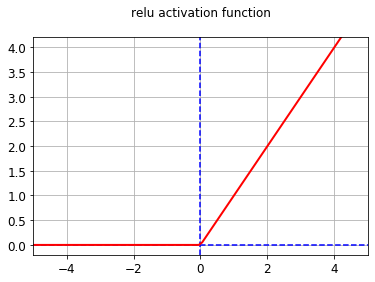

In [36]:
demo_plot(relu, "relu")

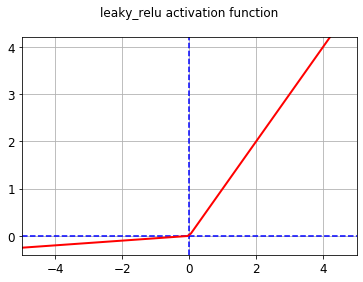

In [37]:
demo_plot(leaky_relu_plot, "leaky_relu")

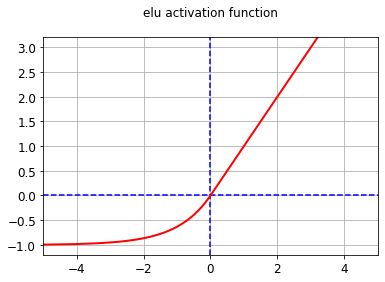

In [38]:
demo_plot(elu, "elu")

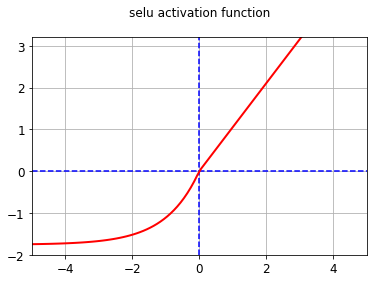

In [39]:
demo_plot(selu, "selu")

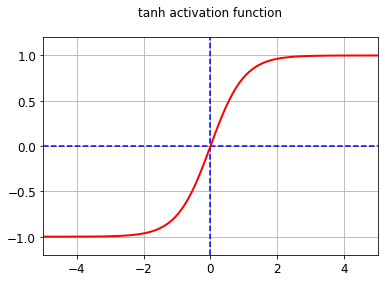

In [40]:
demo_plot(tanh, "tanh")

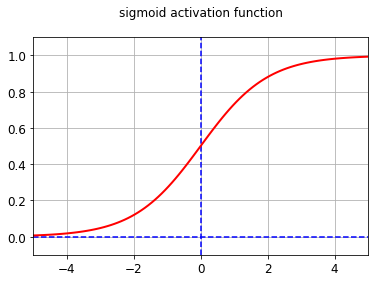

In [41]:
demo_plot(sigmoid, "sigmoid")

In [42]:
# This code is drawn almost directly from Géron's textbook and GitHub site
# It works fine. But its features have been superseded.
# Keep this around in case we need it

@profile("tf_full")
def run_one_tf_model_deeply_deprecated(n_hidden1 = 300, n_hidden2 = 100, learning_rate = 0.01, verbose = False):
    
    tf.reset_default_graph()
    
    n_inputs = 28*28  # MNIST
    # n_hidden1 = 300  # This line and the next have been superseded by the function call's parameters
    # n_hidden2 = 100
    n_outputs = 10
    
    X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = "X")
    y = tf.placeholder(tf.int64, shape = (None), name = "y")
    
    # Use tf.layers.dense to create neuron layers
    # Géron, p. 271
    
    with tf.name_scope("dnn"):
        hidden1 = tf.layers.dense(X, n_hidden1, name = "hidden1", activation = tf.nn.relu, reuse = tf.AUTO_REUSE)
        hidden2 = tf.layers.dense(hidden1, n_hidden2, name = "hidden2", activation = tf.nn.relu, reuse = tf.AUTO_REUSE)
        logits = tf.layers.dense(hidden2, n_outputs, name = "outputs")
        
        # Prepare for an eventual switch to keras.layers.Dense()
        
        # hidden1 = Dense(X, n_hidden1, name = "hidden1", activation = tf.nn.relu, reuse = tf.AUTO_REUSE)
        # hidden2 = Dense(hidden1, n_hidden2, name = "hidden2", activation = tf.nn.relu, reuse = tf.AUTO_REUSE)
        # logits = Dense(hidden2, n_outputs, name = "outputs")
        
    ### TF system warning: Use keras.layers.dense instead of tf.layers.dense ###

    # Define the loss function as cross-entropy
    # Géron, p. 272

    with tf.name_scope("loss"):
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = logits)
        loss = tf.reduce_mean(xentropy, name = "loss")
        
    # Define the gradient descent optimizer at a training rate of 0.01
    # Géron, p. 272

    # learning_rate = 0.01

    with tf.name_scope("train"):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)
        
    # Define the evaluation of the model
    # Geron, p. 272

    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    # Initialize all variables
    # Géron, p. 273

    init = tf.global_variables_initializer()
    # saver = tf.train.Saver()
    
    ### TF system warning: Call initializer instance with the dtype argument instead of passing it to the constructor
    
    # Execute the model! — With early stopping

    n_epochs = 200  # With early stopping, this number effectively serves as a ceiling against runaway models
    batch_size = 50  # This can be passed as a function argument. We could use a default value such as 50.

    with tf.Session() as sess:
        init.run()
    
        best_accuracy = 0
        batch_scores = []
        valid_scores = []
        cycle_length = 5

        for epoch in range(n_epochs):
            for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            if epoch % cycle_length == 0:
                acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
                batch_scores += [acc_batch]
                acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
                valid_scores += [acc_valid]
                if verbose:
                    print(epoch, "batch accuracy:\t", acc_batch, "\tValidation accuracy:\t", acc_valid)
                if acc_valid > best_accuracy:
                    best_accuracy = acc_valid
                else:
                    if verbose:
                        print("\nStopping early at", epoch, "epochs!\n")
                    break

        # top_batch = max(batch_scores)
        top_valid = max(valid_scores)
        # print("{:>40s}\t{:.2f}".format("Top batch accuracy", top_batch))
        print("{:>40s}\t{:.2f}".format("Average batch accuracy", sum(batch_scores[:-1]) / (len(batch_scores) -1 )))
        print("{:>40s}\t{:.4f}".format("Top validation accuracy", top_valid))
        print("{:>40s}\t{:d}".format("Epochs at peak validation accuracy", np.argmax(valid_scores) * cycle_length))
        
        # saver.save(sess, "tf_model_final.ckpt")

In [43]:
# This code generates a comprehensive report on a single model
# It allows you to use a for loop to test some similar models, perhaps 3 to 5 at a time

@profile("tf_full")
def run_one_tf_model_deprecated(topology_tuple = (50, ), learning_rate = 0.01, activation = "relu", verbose = False, unleashed = False):
    
    start_time = time.monotonic()    
    tf.reset_default_graph()
    
    n_inputs = 28*28  # MNIST
    # n_hidden1 = 300  # This line and the next have been superseded by the function call's parameters
    # n_hidden2 = 100
    n_outputs = 10
    
    activation_models = {"relu": tf.nn.relu, "tanh": tf.nn.tanh, "elu": tf.nn.elu, "selu": tf.nn.selu,
                        "leaky_relu": leaky_relu, "sigmoid": tf.nn.sigmoid}
    
    X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = "X")
    y = tf.placeholder(tf.int64, shape = (None), name = "y")
    
    # Use tf.layers.dense to create neuron layers
    # Géron, p. 271
    
    with tf.name_scope("dnn"):
        
        depth = len(topology_tuple)
        # There are ways to generalize the number of layers in a TensorFlow DNN
        # https://stackoverflow.com/questions/45761407/how-to-have-a-variable-number-of-hidden-layers-in-tensorflow
        # https://stackoverflow.com/questions/45896046/tensorflow-variable-number-of-levels-in-a-neural-net-model
        # Reserve those ideas for another day. For now, just create a five-way flow-control statement

        hidden1 = tf.layers.dense(X, topology_tuple[0], name = "hidden1", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
        if depth == 1:
            logits = tf.layers.dense(hidden1, n_outputs, name = "outputs")
        elif depth == 2:
            hidden2 = tf.layers.dense(hidden1, topology_tuple[1], name = "hidden2", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            logits =  tf.layers.dense(hidden2, n_outputs, name = "outputs")
        elif depth == 3:
            hidden2 = tf.layers.dense(hidden1, topology_tuple[1], name = "hidden2", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden3 = tf.layers.dense(hidden2, topology_tuple[2], name = "hidden3", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            logits =  tf.layers.dense(hidden3, n_outputs, name = "outputs")
        elif depth == 4:
            hidden2 = tf.layers.dense(hidden1, topology_tuple[1], name = "hidden2", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden3 = tf.layers.dense(hidden2, topology_tuple[2], name = "hidden3", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden4 = tf.layers.dense(hidden3, topology_tuple[3], name = "hidden4", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            logits =  tf.layers.dense(hidden3, n_outputs, name = "outputs")
        elif depth == 5:
            hidden2 = tf.layers.dense(hidden1, topology_tuple[1], name = "hidden2", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden3 = tf.layers.dense(hidden2, topology_tuple[2], name = "hidden3", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden4 = tf.layers.dense(hidden3, topology_tuple[3], name = "hidden4", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden5 = tf.layers.dense(hidden4, topology_tuple[4], name = "hidden5", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            logits =  tf.layers.dense(hidden5, n_outputs, name = "outputs")
        elif depth == 6:
            hidden2 = tf.layers.dense(hidden1, topology_tuple[1], name = "hidden2", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden3 = tf.layers.dense(hidden2, topology_tuple[2], name = "hidden3", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden4 = tf.layers.dense(hidden3, topology_tuple[3], name = "hidden4", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden5 = tf.layers.dense(hidden4, topology_tuple[4], name = "hidden5", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden6 = tf.layers.dense(hidden5, topology_tuple[5], name = "hidden6", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            logits =  tf.layers.dense(hidden6, n_outputs, name = "outputs")
        elif depth == 7:
            hidden2 = tf.layers.dense(hidden1, topology_tuple[1], name = "hidden2", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden3 = tf.layers.dense(hidden2, topology_tuple[2], name = "hidden3", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden4 = tf.layers.dense(hidden3, topology_tuple[3], name = "hidden4", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden5 = tf.layers.dense(hidden4, topology_tuple[4], name = "hidden5", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden6 = tf.layers.dense(hidden5, topology_tuple[5], name = "hidden6", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden7 = tf.layers.dense(hidden6, topology_tuple[6], name = "hidden7", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            logits =  tf.layers.dense(hidden7, n_outputs, name = "outputs")
        elif depth == 8:
            hidden2 = tf.layers.dense(hidden1, topology_tuple[1], name = "hidden2", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden3 = tf.layers.dense(hidden2, topology_tuple[2], name = "hidden3", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden4 = tf.layers.dense(hidden3, topology_tuple[3], name = "hidden4", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden5 = tf.layers.dense(hidden4, topology_tuple[4], name = "hidden5", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden6 = tf.layers.dense(hidden5, topology_tuple[5], name = "hidden6", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden7 = tf.layers.dense(hidden6, topology_tuple[6], name = "hidden7", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden8 = tf.layers.dense(hidden7, topology_tuple[7], name = "hidden8", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            logits =  tf.layers.dense(hidden8, n_outputs, name = "outputs")

            
        # hidden1 = tf.layers.dense(X, n_hidden1, name = "hidden1", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
        # hidden2 = tf.layers.dense(hidden1, n_hidden2, name = "hidden2", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
        # logits = tf.layers.dense(hidden2, n_outputs, name = "outputs")
        
        # Prepare for an eventual switch to keras.layers.Dense()
        
        # hidden1 = Dense(X, n_hidden1, name = "hidden1", activation = tf.nn.relu, reuse = tf.AUTO_REUSE)
        # hidden2 = Dense(hidden1, n_hidden2, name = "hidden2", activation = tf.nn.relu, reuse = tf.AUTO_REUSE)
        # logits = Dense(hidden2, n_outputs, name = "outputs")
        
    ### TF system warning: Use keras.layers.dense instead of tf.layers.dense ###

    # Define the loss function as cross-entropy
    # Géron, p. 272

    with tf.name_scope("loss"):
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = logits)
        loss = tf.reduce_mean(xentropy, name = "loss")
        
    # Define the gradient descent optimizer at a training rate of 0.01
    # Géron, p. 272

    # learning_rate = rate

    with tf.name_scope("train"):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)
        
    # Define the evaluation of the model
    # Geron, p. 272

    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    # Initialize all variables
    # Géron, p. 273

    init = tf.global_variables_initializer()
    # saver = tf.train.Saver()
    
    ### TF system warning: Call initializer instance with the dtype argument instead of passing it to the constructor
    
    # Execute the model! — With early stopping

    n_epochs = 100  # With early stopping, this number effectively serves as a ceiling against runaway models
    batch_size = 50  # This can be passed as a function argument. We could use a default value such as 50.

    with tf.Session() as sess:
        init.run()
    
        best_accuracy = 0
        batch_scores = []
        valid_scores = []
        loss_scores  = []
        no_improvement = 0
        cycle_length = 1
        if unleashed:
            threshold = n_epochs
        elif activation == "selu":
            threshold = 8
        else:
            threshold = 5

        for epoch in range(n_epochs):
            for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            if epoch % cycle_length == 0:
                acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
                batch_scores += [acc_batch]
                acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
                valid_scores += [acc_valid]
                loss_valid = loss.eval(feed_dict={X: X_valid, y: y_valid})
                loss_scores += [loss_valid]
                if verbose:
                    print("{:d} {:>15s}\t{:.2f}\t{:>20s}\t{:.4f}\t{:>12s}\t{:.4f}".format(epoch, "batch accuracy:", acc_batch, "Validation accuracy:", acc_valid, "Loss score:", loss_valid))
                    # print(epoch, "batch accuracy:\t", acc_batch, "\tValidation accuracy:\t", acc_valid,
                    #       "\tLoss score:\t", loss_valid)
                if acc_valid > best_accuracy:
                    best_accuracy = acc_valid
                    no_improvement = 0
                else:
                    no_improvement += 1
                    if no_improvement >= threshold:
                        if verbose:
                            print("\nStopping early at", epoch, "epochs!\n")
                        break  # Early stopping

        # top_batch = max(batch_scores)
        elapsed_time = time.monotonic() - start_time
        top_valid = max(valid_scores)
        total_epochs = np.argmax(valid_scores) * cycle_length
        batch_adjust = len(batch_scores) - total_epochs
        # print("{:>40s}\t{:.2f}".format("Top batch accuracy", top_batch))
        print("{:>40s}\t{:8.4f}".format("Average batch accuracy", sum(batch_scores[:-batch_adjust]) / (len(batch_scores) - batch_adjust)))
        print("{:>40s}\t{:8.4f}".format("Top validation accuracy", top_valid))
        print("{:>40s}\t{:8.4f}".format("Minimum loss score", min(loss_scores)))
        print("{:>40s}\t{:8d}".format("Epochs at peak validation accuracy", total_epochs))
        print("{:>40s}\t{:8.4f}".format("Total processing time", elapsed_time))
        
        if verbose:  # Verbosity option triggers a plot
            # Source: https://www.tensorflow.org/tutorials/eager/custom_training_walkthrough
            supertitle = str(topology_tuple) + " with " + activation + " at learning rate = " + str(learning_rate)
            valid_legend = "Validation accuracy ≈ " + str(top_valid) + " at " + str(total_epochs) + " epochs"
            supertitle += "\n" + valid_legend
            file_name = str(len(topology_tuple)) + "_layers"
            for i in range(len(topology_tuple)):
                file_name += "_" + str(topology_tuple[i])
            file_name += "_" + activation
            
            batch_cumulative = []
            batch_cumsum = np.cumsum(batch_scores)
            for i in range(len(batch_cumsum)):
                batch_cumulative += [batch_cumsum[i] / (i + 1)]

            fig, axes = plt.subplots(2, sharex = True, figsize = (12, 12))
            fig.suptitle("Performance metrics: " + supertitle)
            axes[0].set_ylabel("Loss")
            axes[0].grid()
            axes[0].plot(loss_scores, color = "green", label = "Cross-entropy loss score")
            axes[1].set_ylabel("Accuracy")
            axes[1].set_xlabel("Epoch")
            axes[1].grid()
            axes[1].plot(batch_cumulative, color = "blue", linestyle = ":", label = "Batch accuracy: Running average")
            axes[1].plot(valid_scores, color = "red", label = "Validation accuracy")
            axes[1].axvline(total_epochs, color = "orange", linestyle = "--", label = valid_legend)
            axes[1].legend(loc = "lower center")
            plt.savefig(file_name + ".png")
            plt.savefig(file_name + ".pdf")
        
        # saver.save(sess, "tf_model_final.ckpt")

In [44]:
# This code generates a comprehensive report on a single model
# It allows you to use a for loop to test some similar models, perhaps 3 to 5 at a time

@profile("tf_full")
def run_one_tf_model(topology_tuple = (50, ), learning_rate = 0.01, L1 = 0.0, L2 = 0.0, activation = "relu", verbose = False, unleashed = False):
    
    start_time = time.monotonic()    
    tf.reset_default_graph()
    
    n_inputs = 28*28  # MNIST
    # n_hidden1 = 300  # This line and the next have been superseded by the function call's parameters
    # n_hidden2 = 100
    n_outputs = 10
    
    activation_models = {"relu": tf.nn.relu, "tanh": tf.nn.tanh, "elu": tf.nn.elu, "selu": tf.nn.selu,
                        "leaky_relu": leaky_relu, "sigmoid": tf.nn.sigmoid}
    
    X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = "X")
    y = tf.placeholder(tf.int64, shape = (None), name = "y")
    
    # According to Géron, p. 310, this would be the place to introduce l1 or l2 regularization
    # There is a combined l1_l2 regularizer, presumably by analogy to ElasticNet
    # Let's leave that project for another day …
    
    if L1 > 0:  # Lasso-style regularization. A good starting value = 0.001
        my_dense_layer = partial(tf.layers.dense, kernel_regularizer = tf.contrib.layers.l1_regularizer(L1))
    elif L2 > 0:  # Ridge-style regularization. A good starting value = 0.0001. Try 0.0003 for MNIST!
        my_dense_layer = partial(tf.layers.dense, kernel_regularizer = tf.contrib.layers.l2_regularizer(L2))
    else:  # No regularization of either kind
        my_dense_layer = partial(tf.layers.dense)        
    
    # Use tf.layers.dense to create neuron layers
    # Géron, p. 271
    
    with tf.name_scope("dnn"):
        
        depth = len(topology_tuple)
        # There are ways to generalize the number of layers in a TensorFlow DNN
        # https://stackoverflow.com/questions/45761407/how-to-have-a-variable-number-of-hidden-layers-in-tensorflow
        # https://stackoverflow.com/questions/45896046/tensorflow-variable-number-of-levels-in-a-neural-net-model
        # Reserve those ideas for another day. For now, just create a five-way flow-control statement

        hidden1 = my_dense_layer(X, topology_tuple[0], name = "hidden1", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
        if depth == 1:
            logits = my_dense_layer(hidden1, n_outputs, name = "outputs")
        elif depth == 2:
            hidden2 = my_dense_layer(hidden1, topology_tuple[1], name = "hidden2", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            logits =  my_dense_layer(hidden2, n_outputs, name = "outputs")
        elif depth == 3:
            hidden2 = my_dense_layer(hidden1, topology_tuple[1], name = "hidden2", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden3 = my_dense_layer(hidden2, topology_tuple[2], name = "hidden3", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            logits =  my_dense_layer(hidden3, n_outputs, name = "outputs")
        elif depth == 4:
            hidden2 = my_dense_layer(hidden1, topology_tuple[1], name = "hidden2", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden3 = my_dense_layer(hidden2, topology_tuple[2], name = "hidden3", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden4 = my_dense_layer(hidden3, topology_tuple[3], name = "hidden4", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            logits =  my_dense_layer(hidden3, n_outputs, name = "outputs")
        elif depth == 5:
            hidden2 = my_dense_layer(hidden1, topology_tuple[1], name = "hidden2", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden3 = my_dense_layer(hidden2, topology_tuple[2], name = "hidden3", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden4 = my_dense_layer(hidden3, topology_tuple[3], name = "hidden4", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden5 = my_dense_layer(hidden4, topology_tuple[4], name = "hidden5", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            logits =  my_dense_layer(hidden5, n_outputs, name = "outputs")
        elif depth == 6:
            hidden2 = my_dense_layer(hidden1, topology_tuple[1], name = "hidden2", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden3 = my_dense_layer(hidden2, topology_tuple[2], name = "hidden3", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden4 = my_dense_layer(hidden3, topology_tuple[3], name = "hidden4", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden5 = my_dense_layer(hidden4, topology_tuple[4], name = "hidden5", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden6 = my_dense_layer(hidden5, topology_tuple[5], name = "hidden6", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            logits =  my_dense_layer(hidden6, n_outputs, name = "outputs")
        elif depth == 7:
            hidden2 = my_dense_layer(hidden1, topology_tuple[1], name = "hidden2", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden3 = my_dense_layer(hidden2, topology_tuple[2], name = "hidden3", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden4 = my_dense_layer(hidden3, topology_tuple[3], name = "hidden4", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden5 = my_dense_layer(hidden4, topology_tuple[4], name = "hidden5", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden6 = my_dense_layer(hidden5, topology_tuple[5], name = "hidden6", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden7 = my_dense_layer(hidden6, topology_tuple[6], name = "hidden7", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            logits =  my_dense_layer(hidden7, n_outputs, name = "outputs")
        elif depth == 8:
            hidden2 = my_dense_layer(hidden1, topology_tuple[1], name = "hidden2", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden3 = my_dense_layer(hidden2, topology_tuple[2], name = "hidden3", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden4 = my_dense_layer(hidden3, topology_tuple[3], name = "hidden4", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden5 = my_dense_layer(hidden4, topology_tuple[4], name = "hidden5", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden6 = my_dense_layer(hidden5, topology_tuple[5], name = "hidden6", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden7 = my_dense_layer(hidden6, topology_tuple[6], name = "hidden7", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            hidden8 = my_dense_layer(hidden7, topology_tuple[7], name = "hidden8", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            logits =  my_dense_layer(hidden8, n_outputs, name = "outputs")

            
        # hidden1 = tf.layers.dense(X, n_hidden1, name = "hidden1", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
        # hidden2 = tf.layers.dense(hidden1, n_hidden2, name = "hidden2", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
        # logits = tf.layers.dense(hidden2, n_outputs, name = "outputs")
        
        # Prepare for an eventual switch to tf.keras.layers.Dense()
        
    ### TF system warning: Use keras.layers.dense instead of tf.layers.dense ###

    # Define the loss function as cross-entropy
    # Géron, p. 272, ** as modified by Géron, p. 310, to account for L1 or L2 regularization losses **

    with tf.name_scope("loss"):
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = logits)
        base_loss = tf.reduce_mean(xentropy, name = "avg_xentropy")
        reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([base_loss] + reg_loss, name = "loss")

    # Define the gradient descent optimizer at a training rate of 0.01
    # Géron, p. 272

    # learning_rate = rate

    with tf.name_scope("train"):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)
        
    # Define the evaluation of the model
    # Geron, p. 272

    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    # Initialize all variables
    # Géron, p. 273

    init = tf.global_variables_initializer()
    # saver = tf.train.Saver()
    
    ### TF system warning: Call initializer instance with the dtype argument instead of passing it to the constructor
    
    # Execute the model! — With early stopping

    n_epochs = 100  # With early stopping, this number effectively serves as a ceiling against runaway models
    batch_size = 50  # This can be passed as a function argument. We could use a default value such as 50.

    with tf.Session() as sess:
        init.run()
    
        best_accuracy = 0
        batch_scores = []
        valid_scores = []
        loss_scores  = []
        no_improvement = 0
        cycle_length = 1
        if unleashed:
            threshold = n_epochs
        elif activation == "selu":
            threshold = 8
        else:
            threshold = 5

        for epoch in range(n_epochs):
            for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            if epoch % cycle_length == 0:
                acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
                batch_scores += [acc_batch]
                acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
                valid_scores += [acc_valid]
                loss_valid = loss.eval(feed_dict={X: X_valid, y: y_valid})
                loss_scores += [loss_valid]
                if verbose:
                    print("{:d} {:>15s}\t{:.2f}\t{:>20s}\t{:.4f}\t{:>12s}\t{:.4f}".format(epoch, "batch training accuracy:", acc_batch, "Validation accuracy:", acc_valid, "Loss score:", loss_valid))
                    # print(epoch, "batch accuracy:\t", acc_batch, "\tValidation accuracy:\t", acc_valid,
                    #       "\tLoss score:\t", loss_valid)
                if acc_valid > best_accuracy:
                    best_accuracy = acc_valid
                    no_improvement = 0
                else:
                    no_improvement += 1
                    if no_improvement >= threshold:
                        if verbose:
                            print("\nStopping early at", epoch, "epochs!\n")
                        break  # Early stopping

        final_train = accuracy.eval(feed_dict={X: X_train, y: y_train})
        final_test = accuracy.eval(feed_dict={X: X_test, y: y_test})

        # top_batch = max(batch_scores)
        elapsed_time = time.monotonic() - start_time
        top_valid = max(valid_scores)
        total_epochs = np.argmax(valid_scores) * cycle_length
        batch_adjust = len(batch_scores) - total_epochs
        # print("{:>40s}\t{:.2f}".format("Top batch accuracy", top_batch))
        print("{:>40s}\t{:8.4f}".format("Average training accuracy", sum(batch_scores[:-batch_adjust]) / (len(batch_scores) - batch_adjust)))
        print("{:>40s}\t{:8.4f}".format("Top validation accuracy", top_valid))
        print("{:>40s}\t{:8.4f}".format("Minimum loss score", min(loss_scores)))
        print("{:>40s}\t{:8d}".format("Epochs at peak validation accuracy", total_epochs))
        print("{:>40s}\t{:8.4f}".format("Final training accuracy", final_train))
        print("{:>40s}\t{:8.4f}".format("Final test accuracy", final_test))
        print("{:>40s}\t{:8.4f}".format("Total processing time", elapsed_time))
        
        if verbose:  # Verbosity option triggers a plot
            
            Z = logits.eval(feed_dict = {X: X_test})
            y_pred = np.argmax(Z, axis = 1)

            print("\n\n*** Additional performance metrics ***\n")
            print("{:>40s}\t{:.6f}".format("Precision", precision_score(y_test, y_pred, average = None).mean()))
            print("{:>40s}\t{:.6f}".format("Recall", recall_score(y_test, y_pred, average = None).mean()))
            print("{:>40s}\t{:.6f}".format("F1 score", f1_score(y_test, y_pred, average = None).mean()))
            print("{:>40s}\t{:.6f}".format("F2 score", fbeta_score(y_test, y_pred, beta = 2, average = None).mean()))
            print("{:>40s}\t{:.6f}".format("Specificity", specificity_score(y_test, y_pred)))
            print("{:>40s}\t{:.6f}".format("Bookmaker informedness", bookmaker_informedness(y_test, y_pred).mean()))
            print("{:>40s}\t{:.6f}\n\n".format("Matthews correlation", matthews_corrcoef(y_test, y_pred)))
            
            # Graph the training trial: loss, batch accuracy, validation accuracy
            # Source: https://www.tensorflow.org/tutorials/eager/custom_training_walkthrough
            
            supertitle = str(topology_tuple) + " with " + activation + " at learning rate = " + str(learning_rate)
            if L1 > 0:
                supertitle += "\nℓ₁ regularization parameter α = " + str(L1)
            elif L2 > 0:
                supertitle += "\nℓ₂ regularization parameter α = " + str(L2)
            valid_legend = "Validation accuracy ≈ " + str(top_valid) + " at " + str(total_epochs) + " epochs"
            supertitle += "\n" + valid_legend
            file_name = str(len(topology_tuple)) + "_layers"
            for i in range(len(topology_tuple)):
                file_name += "_" + str(topology_tuple[i])
            file_name += "_" + activation
            
            batch_cumulative = []
            batch_cumsum = np.cumsum(batch_scores)
            for i in range(len(batch_cumsum)):
                batch_cumulative += [batch_cumsum[i] / (i + 1)]

            fig, axes = plt.subplots(2, sharex = True, figsize = (12, 12))
            fig.suptitle("Performance metrics: " + supertitle)
            axes[0].set_ylabel("Loss")
            axes[0].grid()
            axes[0].plot(loss_scores, color = "green", label = "Cross-entropy loss score")
            axes[1].set_ylabel("Accuracy")
            axes[1].set_xlabel("Epoch")
            axes[1].grid()
            axes[1].plot(batch_cumulative, color = "blue", linestyle = ":", label = "Training accuracy: Running batch average")
            axes[1].plot(valid_scores, color = "red", label = "Validation accuracy")
            axes[1].axvline(total_epochs, color = "orange", linestyle = "--", label = valid_legend)
            axes[1].legend(loc = "lower center")
            plt.savefig(file_name + ".png")
            plt.savefig(file_name + ".pdf")
            plt.show()
            
            purple_haze(y_test, y_pred, classes = unique_labels(y_pred),
                        title = "TensorFlow DNN confusion matrix", file_name = file_name, python_37 = False)
            purple_haze(y_test, y_pred, classes = unique_labels(y_pred), standardize = True,
                        title = "TensorFlow DNN confusion matrix — Standardized", file_name = file_name + "_standard",
                        python_37 = False)


            
        # saver.save(sess, "tf_model_final.ckpt")

In [45]:
# In case you want to try the deprecated routine, you can restore the next line

# run_one_tf_model_deeply_deprecated(n_hidden1 = 10, n_hidden2 = 10, learning_rate = 0.05, verbose = True)

In [46]:
# Batch execution of three arbitrary chosen models

for topology, activation, rate in ((30, 10), "relu", 0.02), ((90, 50), "relu", 0.01), ((120, 80, 40), "relu", 0.01):
    print("\n\nRunning a DNN with a topology of {} on {} at a {:.2f} learning rate …\n".format(topology, activation, rate))
    run_one_tf_model(topology_tuple = topology, activation = activation, learning_rate = rate, verbose = False)



Running a DNN with a topology of (30, 10) on relu at a 0.02 learning rate …

Instructions for updating:
Use keras.layers.dense instead.
               Average training accuracy	  0.9793
                 Top validation accuracy	  0.9666
                      Minimum loss score	  0.1215
      Epochs at peak validation accuracy	      29
                 Final training accuracy	  0.9789
                     Final test accuracy	  0.9622
                   Total processing time	 21.6870


Running a DNN with a topology of (90, 50) on relu at a 0.01 learning rate …

               Average training accuracy	  0.9788
                 Top validation accuracy	  0.9774
                      Minimum loss score	  0.0779
      Epochs at peak validation accuracy	      48
                 Final training accuracy	  0.9932
                     Final test accuracy	  0.9752
                   Total processing time	 44.2500


Running a DNN with a topology of (120, 80, 40) on relu at a 0.01 learning rate …


0 batch training accuracy:	1.00	Validation accuracy:	0.9306	 Loss score:	0.2337
1 batch training accuracy:	0.96	Validation accuracy:	0.9472	 Loss score:	0.1739
2 batch training accuracy:	1.00	Validation accuracy:	0.9556	 Loss score:	0.1483
3 batch training accuracy:	0.96	Validation accuracy:	0.9598	 Loss score:	0.1306
4 batch training accuracy:	1.00	Validation accuracy:	0.9626	 Loss score:	0.1235
5 batch training accuracy:	0.98	Validation accuracy:	0.9676	 Loss score:	0.1080
6 batch training accuracy:	0.98	Validation accuracy:	0.9660	 Loss score:	0.1096
7 batch training accuracy:	1.00	Validation accuracy:	0.9734	 Loss score:	0.0953
8 batch training accuracy:	1.00	Validation accuracy:	0.9716	 Loss score:	0.0961
9 batch training accuracy:	0.98	Validation accuracy:	0.9732	 Loss score:	0.0873
10 batch training accuracy:	1.00	Validation accuracy:	0.9742	 Loss score:	0.0845
11 batch training accuracy:	1.00	Validation accuracy:	0.9762	 Loss score:	0.0820
12 batch training accuracy:	1.00	Valid

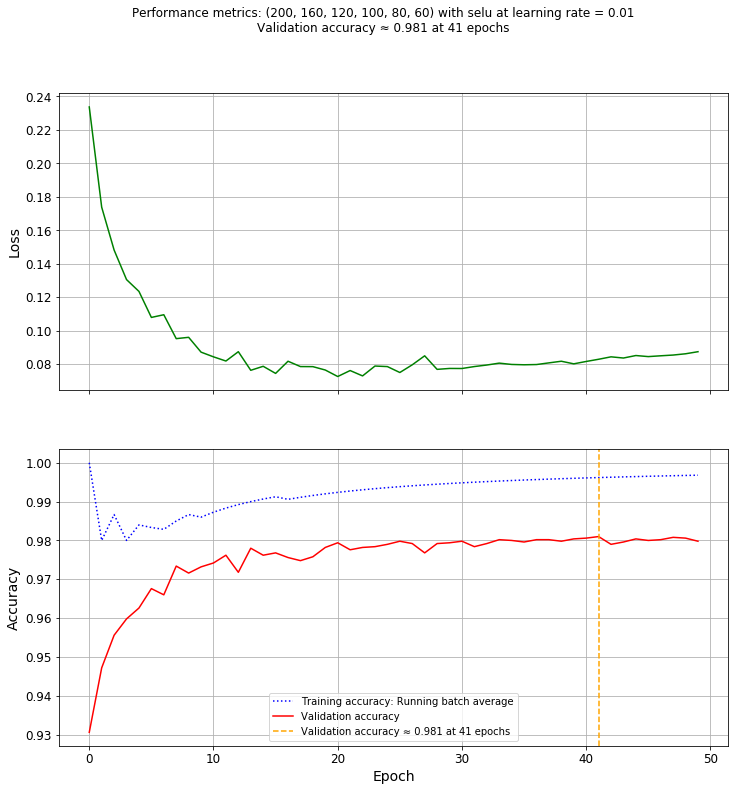

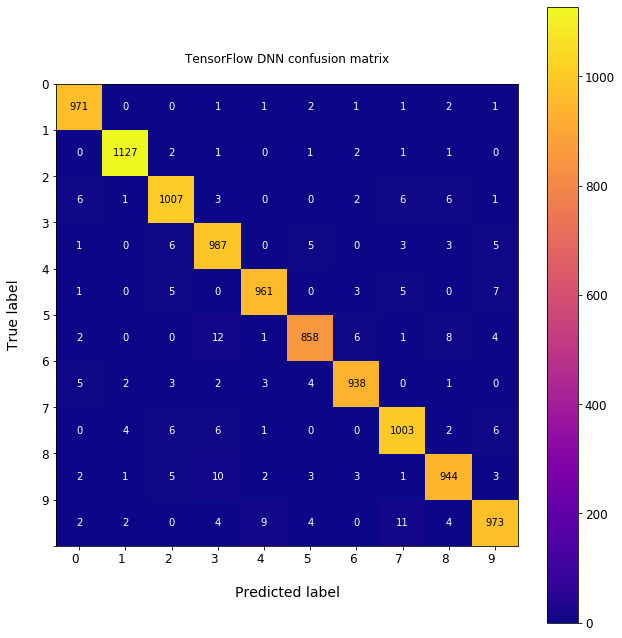

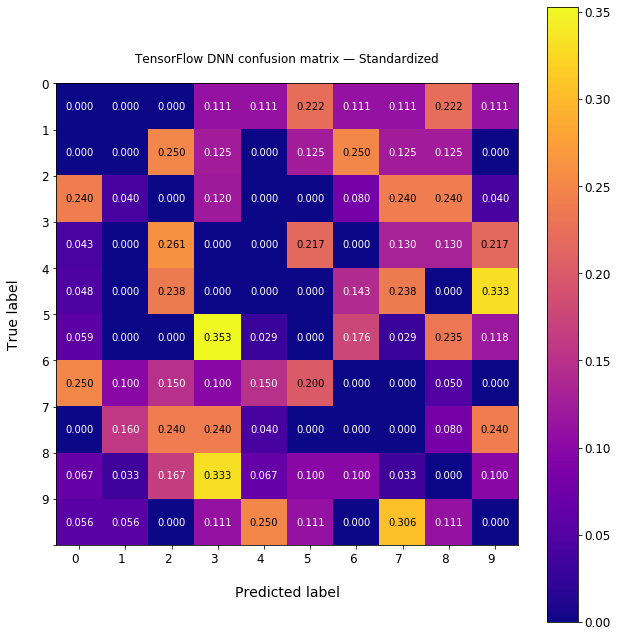

In [47]:
# Use this cell to demonstrate the full power of the verbose version of this routine

run_one_tf_model(topology_tuple = (200, 160, 120, 100, 80, 60), activation = "selu", verbose = True)


0 batch training accuracy:	0.86	Validation accuracy:	0.8712	 Loss score:	0.4763
1 batch training accuracy:	0.98	Validation accuracy:	0.9186	 Loss score:	0.2968
2 batch training accuracy:	1.00	Validation accuracy:	0.9468	 Loss score:	0.1995
3 batch training accuracy:	0.94	Validation accuracy:	0.9534	 Loss score:	0.1632
4 batch training accuracy:	1.00	Validation accuracy:	0.9558	 Loss score:	0.1562
5 batch training accuracy:	0.98	Validation accuracy:	0.9586	 Loss score:	0.1437
6 batch training accuracy:	0.96	Validation accuracy:	0.9628	 Loss score:	0.1277
7 batch training accuracy:	1.00	Validation accuracy:	0.9684	 Loss score:	0.1149
8 batch training accuracy:	0.98	Validation accuracy:	0.9682	 Loss score:	0.1123
9 batch training accuracy:	1.00	Validation accuracy:	0.9682	 Loss score:	0.1080
10 batch training accuracy:	1.00	Validation accuracy:	0.9680	 Loss score:	0.1164
11 batch training accuracy:	1.00	Validation accuracy:	0.9692	 Loss score:	0.1023
12 batch training accuracy:	1.00	Valid

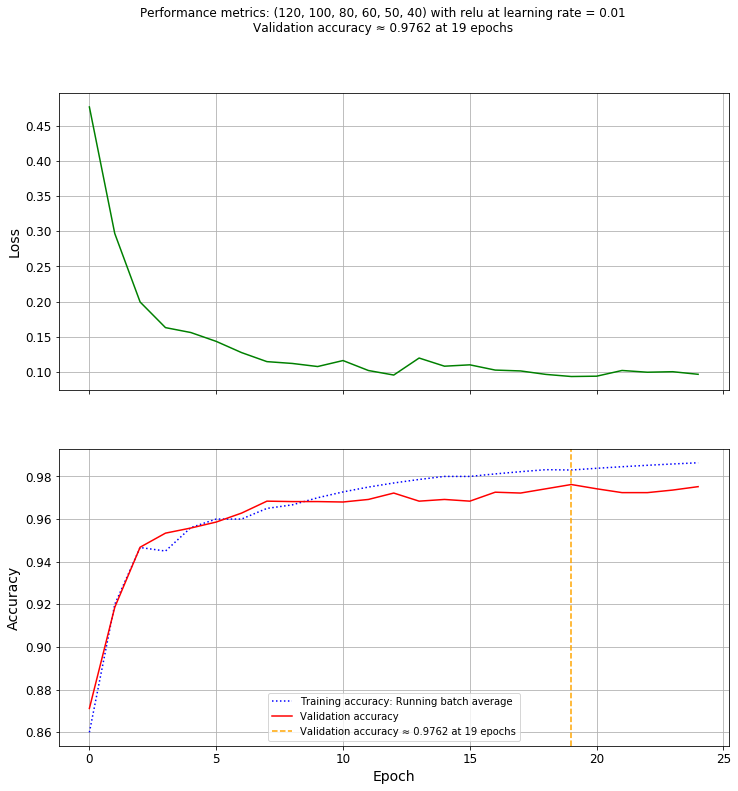

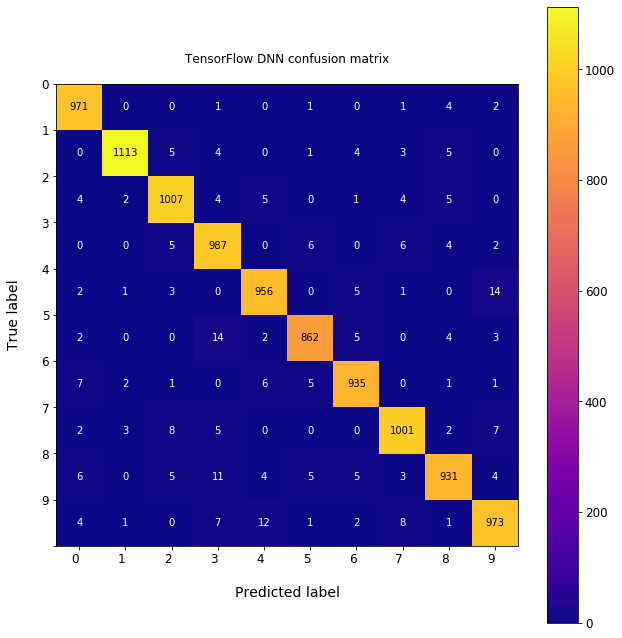

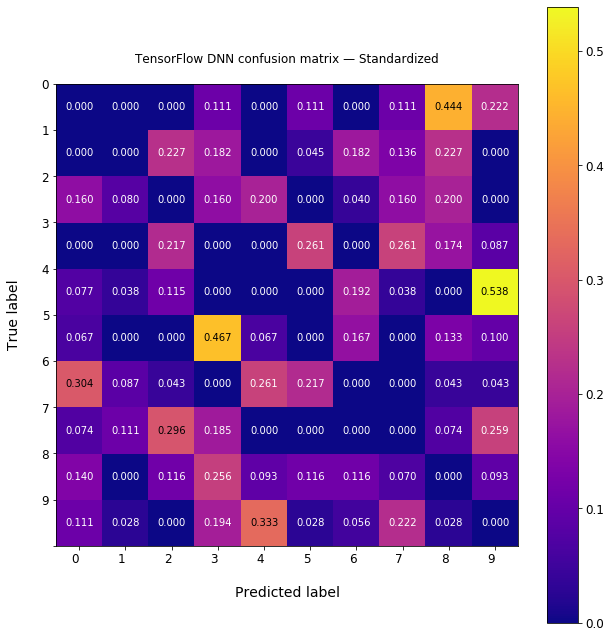

In [48]:
# run_one_tf_model(topology_tuple = (240, 200, 160, 120, 100, 80), learning_rate = 0.01, L1 = 0.000, L2 = 0.0002, activation = "relu", verbose = True)

run_one_tf_model(topology_tuple = (120, 100, 80, 60, 50, 40), learning_rate = 0.01, L1 = 0.000, L2 = 0.0000, activation = "relu", verbose = True)

0 batch training accuracy:	0.88	Validation accuracy:	0.8778	 Loss score:	0.4159
1 batch training accuracy:	0.94	Validation accuracy:	0.9092	 Loss score:	0.2955
2 batch training accuracy:	0.96	Validation accuracy:	0.9472	 Loss score:	0.1870
3 batch training accuracy:	1.00	Validation accuracy:	0.9574	 Loss score:	0.1466
4 batch training accuracy:	1.00	Validation accuracy:	0.9624	 Loss score:	0.1279
5 batch training accuracy:	1.00	Validation accuracy:	0.9642	 Loss score:	0.1210
6 batch training accuracy:	1.00	Validation accuracy:	0.9690	 Loss score:	0.1095
7 batch training accuracy:	1.00	Validation accuracy:	0.9710	 Loss score:	0.0999
8 batch training accuracy:	1.00	Validation accuracy:	0.9724	 Loss score:	0.0919
9 batch training accuracy:	0.98	Validation accuracy:	0.9726	 Loss score:	0.1020
10 batch training accuracy:	1.00	Validation accuracy:	0.9710	 Loss score:	0.0939
11 batch training accuracy:	1.00	Validation accuracy:	0.9754	 Loss score:	0.0874
12 batch training accuracy:	1.00	Valid

                             Specificity	0.985714
                  Bookmaker informedness	0.960919
                    Matthews correlation	0.972770




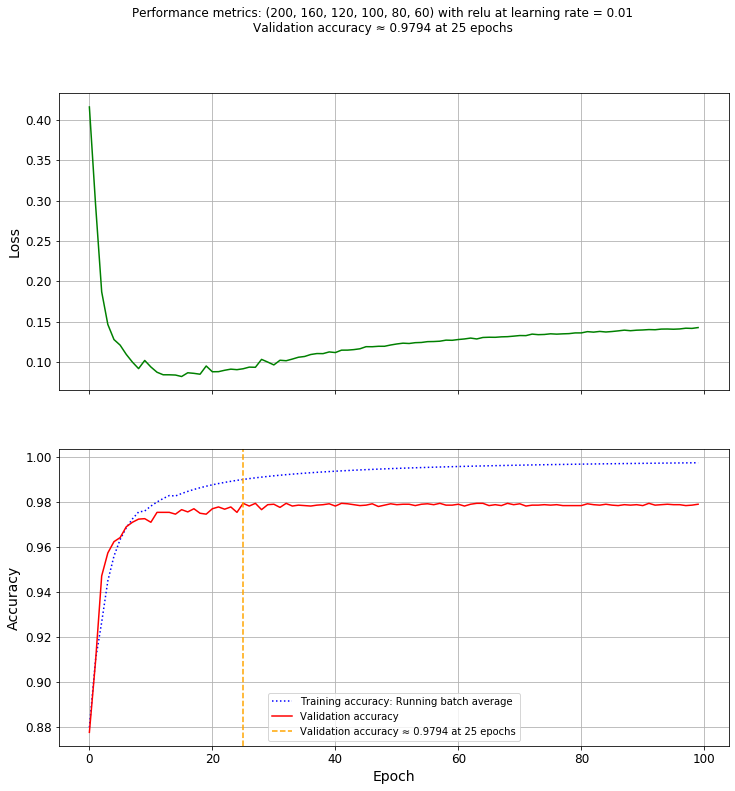

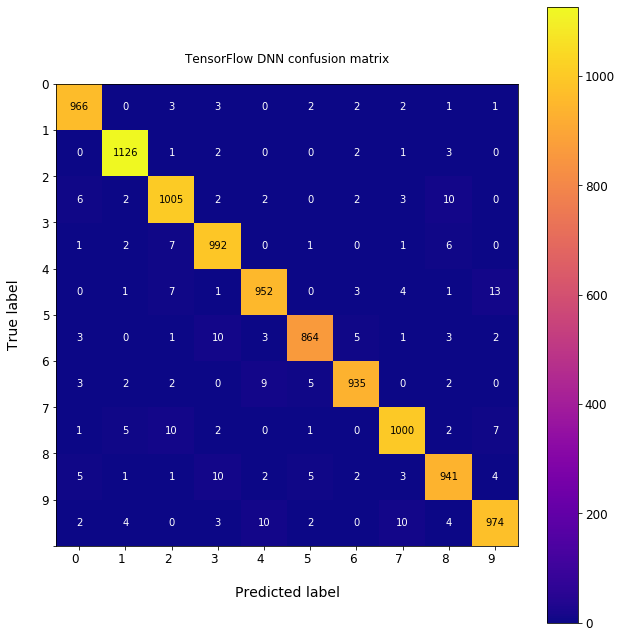

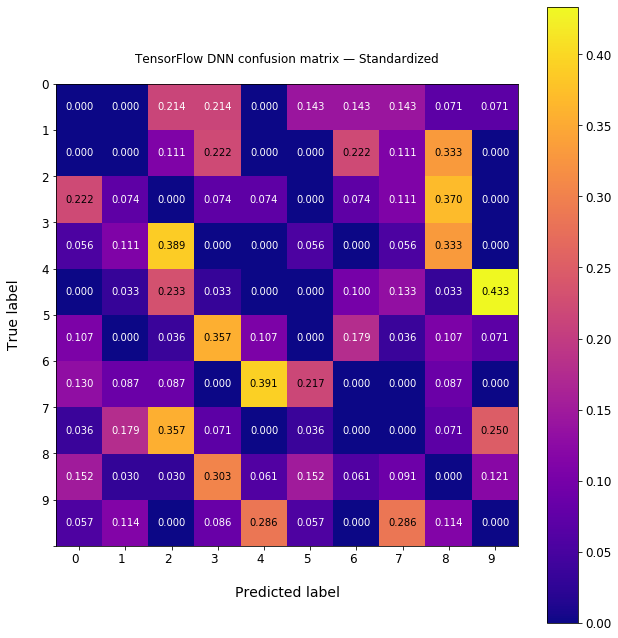

In [49]:
# This is SOLELY for purposes of demonstrating the potential for overfitting
# In all other instances, do NOT turn on the "unleashed" toggle — at least not for MNIST

run_one_tf_model(topology_tuple = (200, 160, 120, 100, 80, 60), activation = "relu", verbose = True, unleashed = True)

In [50]:
# Create a function called fill_frame to generate and record TensorFlow results for MNIST

# This code generates a comprehensive report on a single model
# It allows you to use a for loop to test some similar models, perhaps 3 to 5 at a time

@profile("tf_full")
def fill_frame(input_frame):
    
    # Start with variables that will remain intact for each row of the dataframe

    n_inputs = 28*28  # MNIST
    n_outputs = 10
    activation_models = {"relu": tf.nn.relu, "tanh": tf.nn.tanh, "elu": tf.nn.elu, "selu": tf.nn.selu,
                        "leaky_relu": leaky_relu, "sigmoid": tf.nn.sigmoid}

    for i in range(len(input_frame)):
    
        start_time = time.monotonic()
        tf.reset_default_graph()

        X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = "X")
        y = tf.placeholder(tf.int64, shape = (None), name = "y")
        
        L1 = input_frame.loc[i, "L1"]
        L2 = input_frame.loc[i, "L2"]
        if L1 > 0:  # Lasso-style regularization. A good starting value = 0.001
            my_dense_layer = partial(tf.layers.dense, kernel_regularizer = tf.contrib.layers.l1_regularizer(L1))
        elif L2 > 0:  # A good starting value = 0.0001. Try 0.0003 for MNIST!
            my_dense_layer = partial(tf.layers.dense, kernel_regularizer = tf.contrib.layers.l2_regularizer(L2))
        else:  # No regularization of either kind
            my_dense_layer = partial(tf.layers.dense)        
   
        with tf.name_scope("dnn"):
            
            topology_tuple = input_frame.loc[i, "topology"]
            activation = input_frame.loc[i, "activation"]
            depth = len(topology_tuple)

            hidden1 = my_dense_layer(X, topology_tuple[0], name = "hidden1", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
            if depth == 1:
                logits = my_dense_layer(hidden1, n_outputs, name = "outputs")
            elif depth == 2:
                hidden2 = my_dense_layer(hidden1, topology_tuple[1], name = "hidden2", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                logits =  my_dense_layer(hidden2, n_outputs, name = "outputs")
            elif depth == 3:
                hidden2 = my_dense_layer(hidden1, topology_tuple[1], name = "hidden2", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                hidden3 = my_dense_layer(hidden2, topology_tuple[2], name = "hidden3", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                logits =  my_dense_layer(hidden3, n_outputs, name = "outputs")
            elif depth == 4:
                hidden2 = my_dense_layer(hidden1, topology_tuple[1], name = "hidden2", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                hidden3 = my_dense_layer(hidden2, topology_tuple[2], name = "hidden3", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                hidden4 = my_dense_layer(hidden3, topology_tuple[3], name = "hidden4", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                logits =  my_dense_layer(hidden3, n_outputs, name = "outputs")
            elif depth == 5:
                hidden2 = my_dense_layer(hidden1, topology_tuple[1], name = "hidden2", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                hidden3 = my_dense_layer(hidden2, topology_tuple[2], name = "hidden3", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                hidden4 = my_dense_layer(hidden3, topology_tuple[3], name = "hidden4", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                hidden5 = my_dense_layer(hidden4, topology_tuple[4], name = "hidden5", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                logits =  my_dense_layer(hidden5, n_outputs, name = "outputs")
            elif depth == 6:
                hidden2 = my_dense_layer(hidden1, topology_tuple[1], name = "hidden2", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                hidden3 = my_dense_layer(hidden2, topology_tuple[2], name = "hidden3", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                hidden4 = my_dense_layer(hidden3, topology_tuple[3], name = "hidden4", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                hidden5 = my_dense_layer(hidden4, topology_tuple[4], name = "hidden5", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                hidden6 = my_dense_layer(hidden5, topology_tuple[5], name = "hidden6", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                logits =  my_dense_layer(hidden6, n_outputs, name = "outputs")
            elif depth == 7:
                hidden2 = my_dense_layer(hidden1, topology_tuple[1], name = "hidden2", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                hidden3 = my_dense_layer(hidden2, topology_tuple[2], name = "hidden3", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                hidden4 = my_dense_layer(hidden3, topology_tuple[3], name = "hidden4", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                hidden5 = my_dense_layer(hidden4, topology_tuple[4], name = "hidden5", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                hidden6 = my_dense_layer(hidden5, topology_tuple[5], name = "hidden6", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                hidden7 = my_dense_layer(hidden6, topology_tuple[6], name = "hidden7", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                logits =  my_dense_layer(hidden7, n_outputs, name = "outputs")
            elif depth == 8:
                hidden2 = my_dense_layer(hidden1, topology_tuple[1], name = "hidden2", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                hidden3 = my_dense_layer(hidden2, topology_tuple[2], name = "hidden3", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                hidden4 = my_dense_layer(hidden3, topology_tuple[3], name = "hidden4", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                hidden5 = my_dense_layer(hidden4, topology_tuple[4], name = "hidden5", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                hidden6 = my_dense_layer(hidden5, topology_tuple[5], name = "hidden6", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                hidden7 = my_dense_layer(hidden6, topology_tuple[6], name = "hidden7", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                hidden8 = my_dense_layer(hidden7, topology_tuple[7], name = "hidden8", activation = activation_models[activation], reuse = tf.AUTO_REUSE)
                logits =  my_dense_layer(hidden8, n_outputs, name = "outputs")

        with tf.name_scope("loss"):
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = logits)
            base_loss = tf.reduce_mean(xentropy, name = "avg_xentropy")
            reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
            loss = tf.add_n([base_loss] + reg_loss, name = "loss")

        learning_rate = input_frame.loc[i, "rate"]

        with tf.name_scope("train"):
            optimizer = tf.train.GradientDescentOptimizer(learning_rate)
            training_op = optimizer.minimize(loss)
        
        with tf.name_scope("eval"):
            correct = tf.nn.in_top_k(logits, y, 1)
            accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

        init = tf.global_variables_initializer()

        n_epochs = 100  # With early stopping, this number serves as a ceiling against runaway models
        batch_size = 50

        with tf.Session() as sess:
            init.run()
    
            best_accuracy = 0
            # batch_scores = []
            # valid_scores = []
            # loss_scores  = []
            no_improvement = 0
            cycle_length = 1
            if activation == "selu":
                threshold = 8
            else:
                threshold = 5

            for epoch in range(n_epochs):
                for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
                    sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
                if epoch % cycle_length == 0:
                    # acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
                    acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
                    # valid_scores += [acc_valid]
                    # loss_valid = loss.eval(feed_dict={X: X_valid, y: y_valid})
                    # loss_scores += [loss_valid]
                    if acc_valid > best_accuracy:
                        best_accuracy = acc_valid
                        no_improvement = 0
                    else:
                        no_improvement += 1
                        if no_improvement >= threshold:
                            break  # Early stopping

            input_frame.loc[i, "train"] = accuracy.eval(feed_dict={X: X_train, y: y_train})
            input_frame.loc[i, "test"] = accuracy.eval(feed_dict={X: X_test, y: y_test})
            input_frame.loc[i, "train_minus_test"] = input_frame.loc[i, "train"] - input_frame.loc[i, "test"]
            input_frame.loc[i, "time"] = time.monotonic() - start_time

In [51]:
# Now let's create some relatively simple dataframes and fill them
# The first one will test differences among activation functions

frame_columns = ["topology", "activation", "rate", "L1", "L2", "train", "test", "train_minus_test", "time"]
activation_frame = pd.DataFrame(columns = frame_columns)

act_funcs = ("relu", "leaky_relu", "elu", "selu", "tanh", "sigmoid")
count = 0

for func in act_funcs:
    activation_frame.loc[count, "topology"] = (40, )
    activation_frame.loc[count, "activation"] = func
    activation_frame.loc[count, "rate"] = 0.01
    activation_frame.loc[count, "L1"] = 0.0
    activation_frame.loc[count, "L2"] = 0.0
    activation_frame.loc[count, "train"] = 0.0
    activation_frame.loc[count, "test"] = 0.0
    activation_frame.loc[count, "train_minus_test"] = 0.0
    activation_frame.loc[count, "time"] = 0.0
    count += 1

for func in act_funcs:
    activation_frame.loc[count, "topology"] = (30, 10)
    activation_frame.loc[count, "activation"] = func
    activation_frame.loc[count, "rate"] = 0.01
    activation_frame.loc[count, "L1"] = 0.0
    activation_frame.loc[count, "L2"] = 0.0
    activation_frame.loc[count, "train"] = 0.0
    activation_frame.loc[count, "test"] = 0.0
    activation_frame.loc[count, "train_minus_test"] = 0.0
    activation_frame.loc[count, "time"] = 0.0
    count += 1

activation_frame    

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
0,"(40,)",relu,0.01,0,0,0,0,0,0
1,"(40,)",leaky_relu,0.01,0,0,0,0,0,0
2,"(40,)",elu,0.01,0,0,0,0,0,0
3,"(40,)",selu,0.01,0,0,0,0,0,0
4,"(40,)",tanh,0.01,0,0,0,0,0,0
5,"(40,)",sigmoid,0.01,0,0,0,0,0,0
6,"(30, 10)",relu,0.01,0,0,0,0,0,0
7,"(30, 10)",leaky_relu,0.01,0,0,0,0,0,0
8,"(30, 10)",elu,0.01,0,0,0,0,0,0
9,"(30, 10)",selu,0.01,0,0,0,0,0,0


In [52]:
fill_frame(activation_frame)

In [53]:
activation_frame

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
0,"(40,)",relu,0.01,0,0,0.976418,0.9661,0.0103182,38.14
1,"(40,)",leaky_relu,0.01,0,0,0.968127,0.9622,0.00592726,25.954
2,"(40,)",elu,0.01,0,0,0.970836,0.9632,0.00763637,35.437
3,"(40,)",selu,0.01,0,0,0.973109,0.9644,0.00870907,36.531
4,"(40,)",tanh,0.01,0,0,0.973109,0.9651,0.00800908,36.375
5,"(40,)",sigmoid,0.01,0,0,0.949745,0.9474,0.0023455,54.282
6,"(30, 10)",relu,0.01,0,0,0.9666,0.9593,0.00730002,17.5
7,"(30, 10)",leaky_relu,0.01,0,0,0.961455,0.9523,0.00915456,18.937
8,"(30, 10)",elu,0.01,0,0,0.974218,0.9611,0.0131182,32.172
9,"(30, 10)",selu,0.01,0,0,0.975091,0.962,0.0130909,27.672


In [54]:
activation_frame.sort_values(by = "test", ascending = False)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
0,"(40,)",relu,0.01,0,0,0.976418,0.9661,0.0103182,38.14
4,"(40,)",tanh,0.01,0,0,0.973109,0.9651,0.00800908,36.375
3,"(40,)",selu,0.01,0,0,0.973109,0.9644,0.00870907,36.531
10,"(30, 10)",tanh,0.01,0,0,0.977945,0.964,0.0139455,28.844
2,"(40,)",elu,0.01,0,0,0.970836,0.9632,0.00763637,35.437
1,"(40,)",leaky_relu,0.01,0,0,0.968127,0.9622,0.00592726,25.954
9,"(30, 10)",selu,0.01,0,0,0.975091,0.962,0.0130909,27.672
8,"(30, 10)",elu,0.01,0,0,0.974218,0.9611,0.0131182,32.172
6,"(30, 10)",relu,0.01,0,0,0.9666,0.9593,0.00730002,17.5
7,"(30, 10)",leaky_relu,0.01,0,0,0.961455,0.9523,0.00915456,18.937


Very interesting results. Sigmoid models struggle on performance as well as time. In the interest of conserving computing resources and human energy for analytical attention, we will drop sigmoid models from further study.

Let us now subject the remaining activation to higher learning rates. Raising the learning rate may render these models more susceptible to overfitting. That raises the intriguing prospect of seeing whether L1 or L2 regulation can offset those effects — or make other contributions to DNN optimization.

In [55]:
# New dataframe, this time focused on just three activation functions
# frame_columns continues to supply the basic structure
# Focus on the (30, 10) topology for the sake of consistency and efficiency

regulation_frame = pd.DataFrame(columns = frame_columns)

act_funcs = ("relu", "leaky_relu", "elu", "selu", "tanh")
count = 0

for func in act_funcs:
    regulation_frame.loc[count, "topology"] = (30, 10)
    regulation_frame.loc[count, "activation"] = func
    regulation_frame.loc[count, "rate"] = 0.05
    regulation_frame.loc[count, "L1"] = 0.0
    regulation_frame.loc[count, "L2"] = 0.0
    regulation_frame.loc[count, "train"] = 0.0
    regulation_frame.loc[count, "test"] = 0.0
    regulation_frame.loc[count, "train_minus_test"] = 0.0
    regulation_frame.loc[count, "time"] = 0.0
    count += 1

for func in act_funcs:
    regulation_frame.loc[count, "topology"] = (30, 10)
    regulation_frame.loc[count, "activation"] = func
    regulation_frame.loc[count, "rate"] = 0.10
    regulation_frame.loc[count, "L1"] = 0.0
    regulation_frame.loc[count, "L2"] = 0.0
    regulation_frame.loc[count, "train"] = 0.0
    regulation_frame.loc[count, "test"] = 0.0
    regulation_frame.loc[count, "train_minus_test"] = 0.0
    regulation_frame.loc[count, "time"] = 0.0
    count += 1

for func in act_funcs:
    regulation_frame.loc[count, "topology"] = (30, 10)
    regulation_frame.loc[count, "activation"] = func
    regulation_frame.loc[count, "rate"] = 0.05
    regulation_frame.loc[count, "L1"] = 0.0005
    regulation_frame.loc[count, "L2"] = 0.0
    regulation_frame.loc[count, "train"] = 0.0
    regulation_frame.loc[count, "test"] = 0.0
    regulation_frame.loc[count, "train_minus_test"] = 0.0
    regulation_frame.loc[count, "time"] = 0.0
    count += 1

for func in act_funcs:
    regulation_frame.loc[count, "topology"] = (30, 10)
    regulation_frame.loc[count, "activation"] = func
    regulation_frame.loc[count, "rate"] = 0.10
    regulation_frame.loc[count, "L1"] = 0.0005
    regulation_frame.loc[count, "L2"] = 0.0
    regulation_frame.loc[count, "train"] = 0.0
    regulation_frame.loc[count, "test"] = 0.0
    regulation_frame.loc[count, "train_minus_test"] = 0.0
    regulation_frame.loc[count, "time"] = 0.0
    count += 1

for func in act_funcs:
    regulation_frame.loc[count, "topology"] = (30, 10)
    regulation_frame.loc[count, "activation"] = func
    regulation_frame.loc[count, "rate"] = 0.05
    regulation_frame.loc[count, "L1"] = 0.0
    regulation_frame.loc[count, "L2"] = 0.004
    regulation_frame.loc[count, "train"] = 0.0
    regulation_frame.loc[count, "test"] = 0.0
    regulation_frame.loc[count, "train_minus_test"] = 0.0
    regulation_frame.loc[count, "time"] = 0.0
    count += 1

for func in act_funcs:
    regulation_frame.loc[count, "topology"] = (30, 10)
    regulation_frame.loc[count, "activation"] = func
    regulation_frame.loc[count, "rate"] = 0.10
    regulation_frame.loc[count, "L1"] = 0.0
    regulation_frame.loc[count, "L2"] = 0.004
    regulation_frame.loc[count, "train"] = 0.0
    regulation_frame.loc[count, "test"] = 0.0
    regulation_frame.loc[count, "train_minus_test"] = 0.0
    regulation_frame.loc[count, "time"] = 0.0
    count += 1

for func in act_funcs:
    regulation_frame.loc[count, "topology"] = (30, 10)
    regulation_frame.loc[count, "activation"] = func
    regulation_frame.loc[count, "rate"] = 0.01
    regulation_frame.loc[count, "L1"] = 0.0005
    regulation_frame.loc[count, "L2"] = 0.0
    regulation_frame.loc[count, "train"] = 0.0
    regulation_frame.loc[count, "test"] = 0.0
    regulation_frame.loc[count, "train_minus_test"] = 0.0
    regulation_frame.loc[count, "time"] = 0.0
    count += 1

for func in act_funcs:
    regulation_frame.loc[count, "topology"] = (30, 10)
    regulation_frame.loc[count, "activation"] = func
    regulation_frame.loc[count, "rate"] = 0.01
    regulation_frame.loc[count, "L1"] = 0.0
    regulation_frame.loc[count, "L2"] = 0.004
    regulation_frame.loc[count, "train"] = 0.0
    regulation_frame.loc[count, "test"] = 0.0
    regulation_frame.loc[count, "train_minus_test"] = 0.0
    regulation_frame.loc[count, "time"] = 0.0
    count += 1

regulation_frame

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
0,"(30, 10)",relu,0.05,0,0,0,0,0,0
1,"(30, 10)",leaky_relu,0.05,0,0,0,0,0,0
2,"(30, 10)",elu,0.05,0,0,0,0,0,0
3,"(30, 10)",selu,0.05,0,0,0,0,0,0
4,"(30, 10)",tanh,0.05,0,0,0,0,0,0
5,"(30, 10)",relu,0.1,0,0,0,0,0,0
6,"(30, 10)",leaky_relu,0.1,0,0,0,0,0,0
7,"(30, 10)",elu,0.1,0,0,0,0,0,0
8,"(30, 10)",selu,0.1,0,0,0,0,0,0
9,"(30, 10)",tanh,0.1,0,0,0,0,0,0


In [56]:
fill_frame(regulation_frame)

In [57]:
regulation_frame

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
0,"(30, 10)",relu,0.05,0,0,0.984764,0.9656,0.0191636,12.797
1,"(30, 10)",leaky_relu,0.05,0,0,0.984691,0.9638,0.0208909,16.937
2,"(30, 10)",elu,0.05,0,0,0.981891,0.9653,0.0165909,14.141
3,"(30, 10)",selu,0.05,0,0,0.986036,0.9656,0.0204363,18.5
4,"(30, 10)",tanh,0.05,0,0,0.983145,0.9631,0.0200455,14.484
5,"(30, 10)",relu,0.1,0,0,0.987073,0.9674,0.0196727,12.203
6,"(30, 10)",leaky_relu,0.1,0,0,0.980527,0.9626,0.0179273,11.125
7,"(30, 10)",elu,0.1,0,0,0.984345,0.9647,0.0196455,10.204
8,"(30, 10)",selu,0.1,0,0,0.985873,0.9655,0.0203727,13.046
9,"(30, 10)",tanh,0.1,0,0,0.980345,0.9596,0.0207455,10.219


In [58]:
regulation_frame.sort_values(by = "test", ascending = False)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
5,"(30, 10)",relu,0.1,0,0,0.987073,0.9674,0.0196727,12.203
0,"(30, 10)",relu,0.05,0,0,0.984764,0.9656,0.0191636,12.797
3,"(30, 10)",selu,0.05,0,0,0.986036,0.9656,0.0204363,18.5
8,"(30, 10)",selu,0.1,0,0,0.985873,0.9655,0.0203727,13.046
2,"(30, 10)",elu,0.05,0,0,0.981891,0.9653,0.0165909,14.141
7,"(30, 10)",elu,0.1,0,0,0.984345,0.9647,0.0196455,10.204
21,"(30, 10)",leaky_relu,0.05,0,0.004,0.967218,0.9643,0.00291818,28.672
1,"(30, 10)",leaky_relu,0.05,0,0,0.984691,0.9638,0.0208909,16.937
4,"(30, 10)",tanh,0.05,0,0,0.983145,0.9631,0.0200455,14.484
23,"(30, 10)",selu,0.05,0,0.004,0.9656,0.9627,0.0029,29.562


The results from the activation and the regulation dataframes are more readily interpreted if we combine them. So let's do that.

In [59]:
backup_frame = regulation_frame.copy()
combined_frame = pd.concat([activation_frame, backup_frame])
combined_frame.sort_values(by = "test", ascending = False)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
5,"(30, 10)",relu,0.1,0,0,0.987073,0.9674,0.0196727,12.203
0,"(40,)",relu,0.01,0,0,0.976418,0.9661,0.0103182,38.14
3,"(30, 10)",selu,0.05,0,0,0.986036,0.9656,0.0204363,18.5
0,"(30, 10)",relu,0.05,0,0,0.984764,0.9656,0.0191636,12.797
8,"(30, 10)",selu,0.1,0,0,0.985873,0.9655,0.0203727,13.046
2,"(30, 10)",elu,0.05,0,0,0.981891,0.9653,0.0165909,14.141
4,"(40,)",tanh,0.01,0,0,0.973109,0.9651,0.00800908,36.375
7,"(30, 10)",elu,0.1,0,0,0.984345,0.9647,0.0196455,10.204
3,"(40,)",selu,0.01,0,0,0.973109,0.9644,0.00870907,36.531
21,"(30, 10)",leaky_relu,0.05,0,0.004,0.967218,0.9643,0.00291818,28.672


In [60]:
# There are some amazing differences in processing speed

combined_frame.sort_values(by = "time", ascending = True)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
19,"(30, 10)",tanh,0.1,0.0005,0,0.947255,0.9496,-0.00234544,5.906
10,"(30, 10)",relu,0.05,0.0005,0,0.9634,0.9601,0.00330001,10.203
7,"(30, 10)",elu,0.1,0,0,0.984345,0.9647,0.0196455,10.204
9,"(30, 10)",tanh,0.1,0,0,0.980345,0.9596,0.0207455,10.219
15,"(30, 10)",relu,0.1,0.0005,0,0.949345,0.948,0.00134546,10.954
6,"(30, 10)",leaky_relu,0.1,0,0,0.980527,0.9626,0.0179273,11.125
27,"(30, 10)",elu,0.1,0,0.004,0.958364,0.9588,-0.000436366,11.922
5,"(30, 10)",relu,0.1,0,0,0.987073,0.9674,0.0196727,12.203
14,"(30, 10)",tanh,0.05,0.0005,0,0.960364,0.9559,0.00446361,12.75
0,"(30, 10)",relu,0.05,0,0,0.984764,0.9656,0.0191636,12.797


In [61]:
# Let's look at the combined results, filtering by activation function

combined_frame[combined_frame.activation == "relu"].sort_values(by = "test", ascending = False)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
5,"(30, 10)",relu,0.1,0,0,0.987073,0.9674,0.0196727,12.203
0,"(40,)",relu,0.01,0,0,0.976418,0.9661,0.0103182,38.14
0,"(30, 10)",relu,0.05,0,0,0.984764,0.9656,0.0191636,12.797
30,"(30, 10)",relu,0.01,0.0005,0,0.964582,0.9615,0.00308186,34.079
25,"(30, 10)",relu,0.1,0,0.004,0.964818,0.9606,0.00421816,14.219
20,"(30, 10)",relu,0.05,0,0.004,0.962327,0.9602,0.00212729,19.406
10,"(30, 10)",relu,0.05,0.0005,0,0.9634,0.9601,0.00330001,10.203
6,"(30, 10)",relu,0.01,0,0,0.9666,0.9593,0.00730002,17.5
35,"(30, 10)",relu,0.01,0,0.004,0.959255,0.9556,0.00365454,29.296
15,"(30, 10)",relu,0.1,0.0005,0,0.949345,0.948,0.00134546,10.954


In [62]:
combined_frame[combined_frame.activation == "leaky_relu"].sort_values(by = "test", ascending = False)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
21,"(30, 10)",leaky_relu,0.05,0,0.004,0.967218,0.9643,0.00291818,28.672
1,"(30, 10)",leaky_relu,0.05,0,0,0.984691,0.9638,0.0208909,16.937
6,"(30, 10)",leaky_relu,0.1,0,0,0.980527,0.9626,0.0179273,11.125
1,"(40,)",leaky_relu,0.01,0,0,0.968127,0.9622,0.00592726,25.954
11,"(30, 10)",leaky_relu,0.05,0.0005,0,0.964745,0.9604,0.00434548,23.453
26,"(30, 10)",leaky_relu,0.1,0,0.004,0.9642,0.9593,0.00490004,22.781
36,"(30, 10)",leaky_relu,0.01,0,0.004,0.963255,0.959,0.00425458,50.704
31,"(30, 10)",leaky_relu,0.01,0.0005,0,0.960818,0.9586,0.00221819,30.109
16,"(30, 10)",leaky_relu,0.1,0.0005,0,0.956709,0.9525,0.0042091,15.609
7,"(30, 10)",leaky_relu,0.01,0,0,0.961455,0.9523,0.00915456,18.937


In [63]:
combined_frame[combined_frame.activation == "selu"].sort_values(by = "test", ascending = False)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
3,"(30, 10)",selu,0.05,0,0,0.986036,0.9656,0.0204363,18.5
8,"(30, 10)",selu,0.1,0,0,0.985873,0.9655,0.0203727,13.046
3,"(40,)",selu,0.01,0,0,0.973109,0.9644,0.00870907,36.531
23,"(30, 10)",selu,0.05,0,0.004,0.9656,0.9627,0.0029,29.562
9,"(30, 10)",selu,0.01,0,0,0.975091,0.962,0.0130909,27.672
38,"(30, 10)",selu,0.01,0,0.004,0.962345,0.9608,0.00154549,57.156
28,"(30, 10)",selu,0.1,0,0.004,0.960255,0.959,0.00125456,15.047
13,"(30, 10)",selu,0.05,0.0005,0,0.957164,0.9556,0.00156361,24.578
33,"(30, 10)",selu,0.01,0.0005,0,0.955818,0.9511,0.00471818,31.984
18,"(30, 10)",selu,0.1,0.0005,0,0.951473,0.948,0.00347269,15.157


In [64]:
combined_frame[combined_frame.activation == "elu"].sort_values(by = "test", ascending = False)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
2,"(30, 10)",elu,0.05,0,0,0.981891,0.9653,0.0165909,14.141
7,"(30, 10)",elu,0.1,0,0,0.984345,0.9647,0.0196455,10.204
2,"(40,)",elu,0.01,0,0,0.970836,0.9632,0.00763637,35.437
8,"(30, 10)",elu,0.01,0,0,0.974218,0.9611,0.0131182,32.172
17,"(30, 10)",elu,0.1,0.0005,0,0.963545,0.9607,0.00284547,17.937
27,"(30, 10)",elu,0.1,0,0.004,0.958364,0.9588,-0.000436366,11.922
22,"(30, 10)",elu,0.05,0,0.004,0.960982,0.9587,0.00228184,26.578
12,"(30, 10)",elu,0.05,0.0005,0,0.961873,0.9585,0.00337273,27.532
37,"(30, 10)",elu,0.01,0,0.004,0.953745,0.9508,0.00294542,33.109
32,"(30, 10)",elu,0.01,0.0005,0,0.946782,0.9468,-1.81794e-05,27.281


In [65]:
combined_frame[combined_frame.activation == "tanh"].sort_values(by = "test", ascending = False)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
4,"(40,)",tanh,0.01,0,0,0.973109,0.9651,0.00800908,36.375
10,"(30, 10)",tanh,0.01,0,0,0.977945,0.964,0.0139455,28.844
4,"(30, 10)",tanh,0.05,0,0,0.983145,0.9631,0.0200455,14.484
9,"(30, 10)",tanh,0.1,0,0,0.980345,0.9596,0.0207455,10.219
24,"(30, 10)",tanh,0.05,0,0.004,0.961855,0.958,0.00385451,23.75
39,"(30, 10)",tanh,0.01,0,0.004,0.959073,0.9576,0.00147271,41.344
14,"(30, 10)",tanh,0.05,0.0005,0,0.960364,0.9559,0.00446361,12.75
29,"(30, 10)",tanh,0.1,0,0.004,0.958218,0.9559,0.00231814,16.093
19,"(30, 10)",tanh,0.1,0.0005,0,0.947255,0.9496,-0.00234544,5.906
34,"(30, 10)",tanh,0.01,0.0005,0,0.954691,0.9496,0.00509095,22.86


In [66]:
combined_frame[combined_frame.activation == "sigmoid"].sort_values(by = "test", ascending = False)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
11,"(30, 10)",sigmoid,0.01,0,0,0.953545,0.9492,0.00434548,58.343
5,"(40,)",sigmoid,0.01,0,0,0.949745,0.9474,0.0023455,54.282


Let's plot the results of the combined_frame: test accuracy score against processing time (in raw terms, without standardization) and the train-minus-test gap as a rough gauge of overfitting.

In [67]:
combined_backup = combined_frame.copy()
combined_frame.sort_values(by = "test", ascending = False, inplace = True)

In [68]:
combined_frame

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
5,"(30, 10)",relu,0.1,0,0,0.987073,0.9674,0.0196727,12.203
0,"(40,)",relu,0.01,0,0,0.976418,0.9661,0.0103182,38.14
3,"(30, 10)",selu,0.05,0,0,0.986036,0.9656,0.0204363,18.5
0,"(30, 10)",relu,0.05,0,0,0.984764,0.9656,0.0191636,12.797
8,"(30, 10)",selu,0.1,0,0,0.985873,0.9655,0.0203727,13.046
2,"(30, 10)",elu,0.05,0,0,0.981891,0.9653,0.0165909,14.141
4,"(40,)",tanh,0.01,0,0,0.973109,0.9651,0.00800908,36.375
7,"(30, 10)",elu,0.1,0,0,0.984345,0.9647,0.0196455,10.204
3,"(40,)",selu,0.01,0,0,0.973109,0.9644,0.00870907,36.531
21,"(30, 10)",leaky_relu,0.05,0,0.004,0.967218,0.9643,0.00291818,28.672


In [69]:
# The best outcome

winning_entry = combined_frame.sort_values(by = "test", ascending = False).head(1)


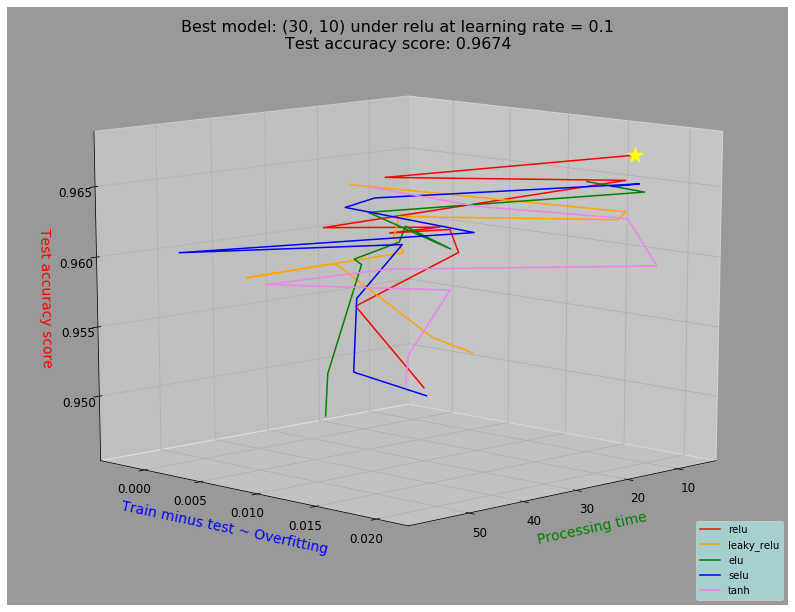

In [70]:
fig = plt.figure(figsize = (14, 11))
ax = fig.gca(projection='3d')
# fig, ax = plt.subplots(figsize = (10, 8))
fig.set_facecolor("white")
ax.set_facecolor("#999999")

ax.set_xlabel("\nProcessing time", color = "green")
ax.set_ylabel("\nTrain minus test ~ Overfitting", color = "b")
ax.set_zlabel("\nTest accuracy score", color = "red")

winning_entry = combined_frame.sort_values(by = "test", ascending = False).head(1)
winning_score = float(winning_entry.test)
winning_tuple = str(winning_entry.topology).partition("(")[2].partition(")")[0]
winning_func  = str(winning_entry.activation).partition("    ")[2].partition("\n")[0]
winning_rate  = float(winning_entry.rate)
winning_label = "Best model: (" + winning_tuple + ") under " + winning_func
winning_label += " at learning rate = " + str(winning_rate) + "\n"
winning_label += "Test accuracy score: " + str(round(winning_score, 4))

def plot_func_lines(func_name, func_color):
    ax.plot(combined_frame[combined_frame.activation == func_name]["time"],
        combined_frame[combined_frame.activation == func_name]["train_minus_test"],
        combined_frame[combined_frame.activation == func_name]["test"],
        color = func_color, label = func_name)

"""
def scatter_model_dots(model_name, model_color, model_marker):
    ax.scatter(final_pipe[final_pipe.model == model_name]["standardized_time"],
               final_pipe[final_pipe.model == model_name]["train_minus_test"],
               final_pipe[final_pipe.model == model_name]["test_score"],
               s = 96, marker = model_marker, color = model_color, label = model_name)
"""
 
# scatter_model_dots("RandomForest", "red", "o")

plot_func_lines("relu", "red")
plot_func_lines("leaky_relu", "orange")
plot_func_lines("elu", "green")
plot_func_lines("selu", "blue")
plot_func_lines("tanh", "violet")

x_locate = float(winning_entry.time)
y_locate = float(winning_entry.train_minus_test)

ax.scatter(x_locate, y_locate, winning_score, s = 250, marker = "*", color = "yellow")

time_space =    np.linspace(combined_frame.time.min(), combined_frame.time.max(), 120)
overfit_space = np.linspace(combined_frame.train_minus_test.min(), combined_frame.train_minus_test.max(), 120)

# plot3d_title = winning_label + " | F1 score ≈ " + str(round(pipe_score, 6))
# plot3d_title +=  "\nStandardized time ≈ " + str(round(x_locate, 6))
# plot3d_title += " | Train minus test ≈ " + str(round(y_locate, 6))
ax.set_title(winning_label, fontsize = 16)

plot_x, plot_y = np.meshgrid(time_space, overfit_space)
score_plane = 0 * plot_x + 0 * plot_y + winning_score

# ax.plot_wireframe(plot_x, plot_y, score_plane, rcount = 6, ccount = 6, color = "orange")

# ax.plot_surface(plot_x, plot_y, score_plane, color = "#00884466")

ax.legend(loc ="lower right", facecolor = "#aadddd22")
ax.view_init(12, 45)
plt.savefig("combined_frame.png")
plt.savefig("combined_frame.pdf")

0 batch training accuracy:	0.92	Validation accuracy:	0.9142	 Loss score:	0.4072
1 batch training accuracy:	0.96	Validation accuracy:	0.9420	 Loss score:	0.3336
2 batch training accuracy:	0.98	Validation accuracy:	0.9518	 Loss score:	0.3000
3 batch training accuracy:	0.98	Validation accuracy:	0.9542	 Loss score:	0.2837
4 batch training accuracy:	1.00	Validation accuracy:	0.9604	 Loss score:	0.2612
5 batch training accuracy:	1.00	Validation accuracy:	0.9618	 Loss score:	0.2549
6 batch training accuracy:	0.94	Validation accuracy:	0.9624	 Loss score:	0.2586
7 batch training accuracy:	1.00	Validation accuracy:	0.9638	 Loss score:	0.2512
8 batch training accuracy:	0.98	Validation accuracy:	0.9662	 Loss score:	0.2423
9 batch training accuracy:	0.96	Validation accuracy:	0.9686	 Loss score:	0.2365
10 batch training accuracy:	0.98	Validation accuracy:	0.9672	 Loss score:	0.2365
11 batch training accuracy:	1.00	Validation accuracy:	0.9696	 Loss score:	0.2298
12 batch training accuracy:	0.98	Valid

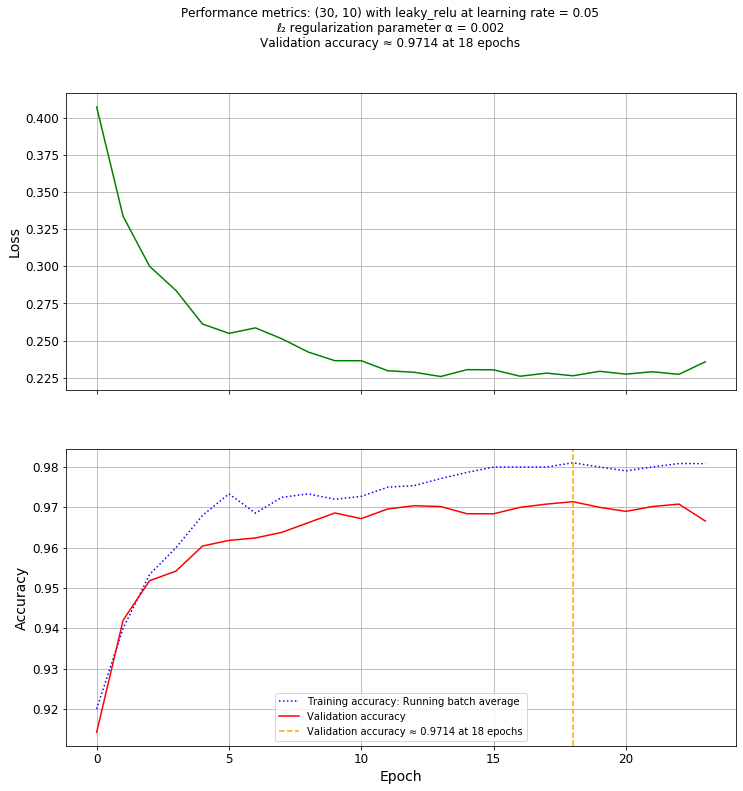

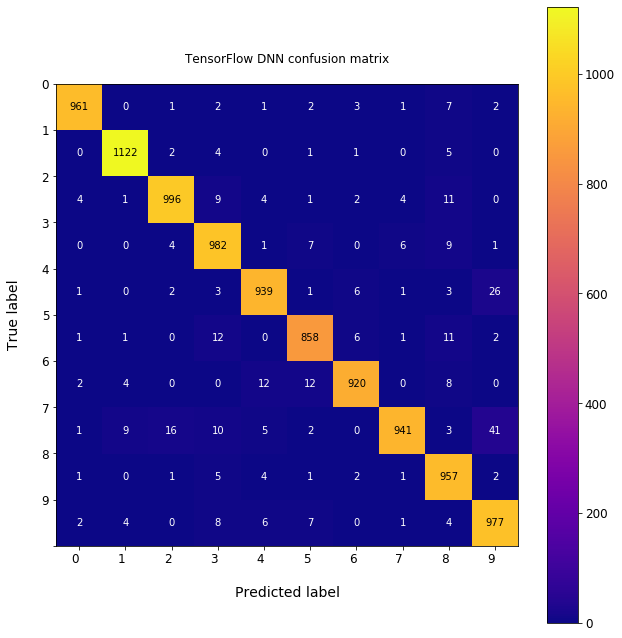

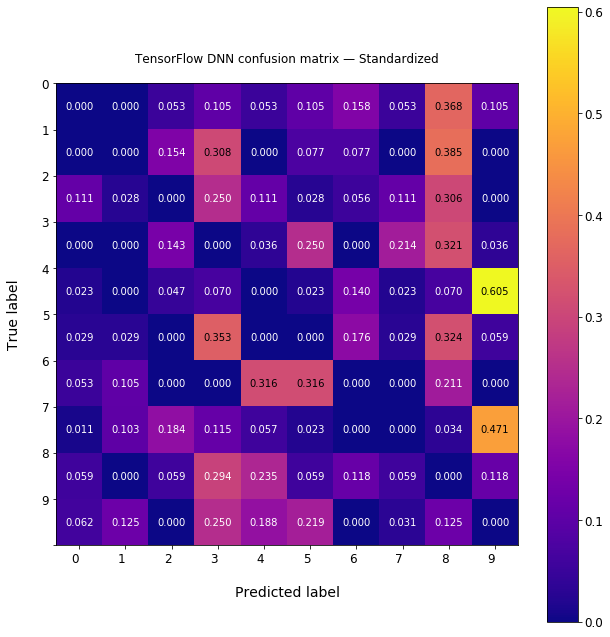

In [71]:
run_one_tf_model(topology_tuple = (30, 10), activation = "leaky_relu", learning_rate = 0.05, L2 = 0.002, verbose = True)

Let's advance one instance of each activiation function to an initial test of network topologies …

In [72]:
func_dict = {"relu": [0.01, 0.0], "leaky_relu": [0.05, 0.002],
             "elu": [0.05, 0.001], "selu": [0.01, 0.0], "tanh": [0.05, 0.0]}

for func in func_dict:
    print(func, func_dict[func][0], func_dict[func][1])


relu 0.01 0.0
leaky_relu 0.05 0.002
elu 0.05 0.001
selu 0.01 0.0
tanh 0.05 0.0


In [73]:
# New dataframe: Time to tackle network topology!
# Use _one_ instance of each activation function, since each finished in the top 10 of combined_frame
# frame_columns continues to supply the basic structure
# longcent means "long century," or 120

longcent_frame = pd.DataFrame(columns = frame_columns)

func_dict = {"relu": [0.01, 0.0], "leaky_relu": [0.05, 0.002],
             "elu": [0.05, 0.001], "selu": [0.01, 0.0], "tanh": [0.05, 0.0]}
count = 0

for func in func_dict:
    longcent_frame.loc[count, "topology"] = (120, )
    longcent_frame.loc[count, "activation"] = func
    longcent_frame.loc[count, "rate"] = func_dict[func][0]
    longcent_frame.loc[count, "L1"] = 0.0
    longcent_frame.loc[count, "L2"] = func_dict[func][1]
    longcent_frame.loc[count, "train"] = 0.0
    longcent_frame.loc[count, "test"] = 0.0
    longcent_frame.loc[count, "train_minus_test"] = 0.0
    longcent_frame.loc[count, "time"] = 0.0
    count += 1

for func in func_dict:
    longcent_frame.loc[count, "topology"] = (90, 30)
    longcent_frame.loc[count, "activation"] = func
    longcent_frame.loc[count, "rate"] = func_dict[func][0]
    longcent_frame.loc[count, "L1"] = 0.0
    longcent_frame.loc[count, "L2"] = func_dict[func][1]
    longcent_frame.loc[count, "train"] = 0.0
    longcent_frame.loc[count, "test"] = 0.0
    longcent_frame.loc[count, "train_minus_test"] = 0.0
    longcent_frame.loc[count, "time"] = 0.0
    count += 1

for func in func_dict:
    longcent_frame.loc[count, "topology"] = (80, 25, 15)
    longcent_frame.loc[count, "activation"] = func
    longcent_frame.loc[count, "rate"] = func_dict[func][0]
    longcent_frame.loc[count, "L1"] = 0.0
    longcent_frame.loc[count, "L2"] = func_dict[func][1]
    longcent_frame.loc[count, "train"] = 0.0
    longcent_frame.loc[count, "test"] = 0.0
    longcent_frame.loc[count, "train_minus_test"] = 0.0
    longcent_frame.loc[count, "time"] = 0.0
    count += 1

longcent_frame

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
0,"(120,)",relu,0.01,0,0,0,0,0,0
1,"(120,)",leaky_relu,0.05,0,0.002,0,0,0,0
2,"(120,)",elu,0.05,0,0.001,0,0,0,0
3,"(120,)",selu,0.01,0,0,0,0,0,0
4,"(120,)",tanh,0.05,0,0,0,0,0,0
5,"(90, 30)",relu,0.01,0,0,0,0,0,0
6,"(90, 30)",leaky_relu,0.05,0,0.002,0,0,0,0
7,"(90, 30)",elu,0.05,0,0.001,0,0,0,0
8,"(90, 30)",selu,0.01,0,0,0,0,0,0
9,"(90, 30)",tanh,0.05,0,0,0,0,0,0


In [74]:
fill_frame(longcent_frame)

In [75]:
longcent_frame

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
0,"(120,)",relu,0.01,0,0,0.986218,0.9748,0.0114182,52.375
1,"(120,)",leaky_relu,0.05,0,0.002,0.975636,0.9707,0.00493634,25.718
2,"(120,)",elu,0.05,0,0.001,0.979891,0.9736,0.00629091,33.891
3,"(120,)",selu,0.01,0,0,0.986455,0.9731,0.0133545,69.375
4,"(120,)",tanh,0.05,0,0,0.994691,0.977,0.0176909,25.328
5,"(90, 30)",relu,0.01,0,0,0.988109,0.9741,0.0140091,30.968
6,"(90, 30)",leaky_relu,0.05,0,0.002,0.984055,0.9769,0.00715458,23.704
7,"(90, 30)",elu,0.05,0,0.001,0.982055,0.9728,0.00925452,21.562
8,"(90, 30)",selu,0.01,0,0,0.9924,0.9716,0.0208,56.938
9,"(90, 30)",tanh,0.05,0,0,0.994455,0.9763,0.0181546,16.109


In [76]:
longcent_frame.sort_values(by = "test", ascending = False)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
4,"(120,)",tanh,0.05,0,0,0.994691,0.977,0.0176909,25.328
6,"(90, 30)",leaky_relu,0.05,0,0.002,0.984055,0.9769,0.00715458,23.704
11,"(80, 25, 15)",leaky_relu,0.05,0,0.002,0.989545,0.9764,0.0131454,34.016
9,"(90, 30)",tanh,0.05,0,0,0.994455,0.9763,0.0181546,16.109
12,"(80, 25, 15)",elu,0.05,0,0.001,0.988709,0.9761,0.0126091,27
14,"(80, 25, 15)",tanh,0.05,0,0,0.998236,0.9751,0.0231364,18.063
0,"(120,)",relu,0.01,0,0,0.986218,0.9748,0.0114182,52.375
5,"(90, 30)",relu,0.01,0,0,0.988109,0.9741,0.0140091,30.968
2,"(120,)",elu,0.05,0,0.001,0.979891,0.9736,0.00629091,33.891
3,"(120,)",selu,0.01,0,0,0.986455,0.9731,0.0133545,69.375


In [77]:
longcent_frame.sort_values(by = "time", ascending = True)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
9,"(90, 30)",tanh,0.05,0,0,0.994455,0.9763,0.0181546,16.109
14,"(80, 25, 15)",tanh,0.05,0,0,0.998236,0.9751,0.0231364,18.063
7,"(90, 30)",elu,0.05,0,0.001,0.982055,0.9728,0.00925452,21.562
6,"(90, 30)",leaky_relu,0.05,0,0.002,0.984055,0.9769,0.00715458,23.704
4,"(120,)",tanh,0.05,0,0,0.994691,0.977,0.0176909,25.328
1,"(120,)",leaky_relu,0.05,0,0.002,0.975636,0.9707,0.00493634,25.718
10,"(80, 25, 15)",relu,0.01,0,0,0.988309,0.9721,0.0162091,25.734
12,"(80, 25, 15)",elu,0.05,0,0.001,0.988709,0.9761,0.0126091,27
5,"(90, 30)",relu,0.01,0,0,0.988109,0.9741,0.0140091,30.968
2,"(120,)",elu,0.05,0,0.001,0.979891,0.9736,0.00629091,33.891


The high (0.05) learning rate models have blazing speed. The ones under some regularization are also exhibiting good discipline, in the sense that they have very small margins between training and test scores.

This look at processing times shows a clear outlier: selu as applied to a large, single layer network. Selu is lagging the other activation functions in performance as well as time. It might not advance to the largest models. What we can say now is that it makes sense to confine selu to multi-layered topologies from this point forward.

In [78]:
longcent_backup = longcent_frame.copy()

In [79]:
longcent_frame.sort_values(by = "test", ascending = False, inplace = True)
longcent_frame

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
4,"(120,)",tanh,0.05,0,0,0.994691,0.977,0.0176909,25.328
6,"(90, 30)",leaky_relu,0.05,0,0.002,0.984055,0.9769,0.00715458,23.704
11,"(80, 25, 15)",leaky_relu,0.05,0,0.002,0.989545,0.9764,0.0131454,34.016
9,"(90, 30)",tanh,0.05,0,0,0.994455,0.9763,0.0181546,16.109
12,"(80, 25, 15)",elu,0.05,0,0.001,0.988709,0.9761,0.0126091,27
14,"(80, 25, 15)",tanh,0.05,0,0,0.998236,0.9751,0.0231364,18.063
0,"(120,)",relu,0.01,0,0,0.986218,0.9748,0.0114182,52.375
5,"(90, 30)",relu,0.01,0,0,0.988109,0.9741,0.0140091,30.968
2,"(120,)",elu,0.05,0,0.001,0.979891,0.9736,0.00629091,33.891
3,"(120,)",selu,0.01,0,0,0.986455,0.9731,0.0133545,69.375


In [80]:
# The best outcome

winning_entry = longcent_frame.sort_values(by = "test", ascending = False).head(1)
winning_entry

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
4,"(120,)",tanh,0.05,0,0,0.994691,0.977,0.0176909,25.328


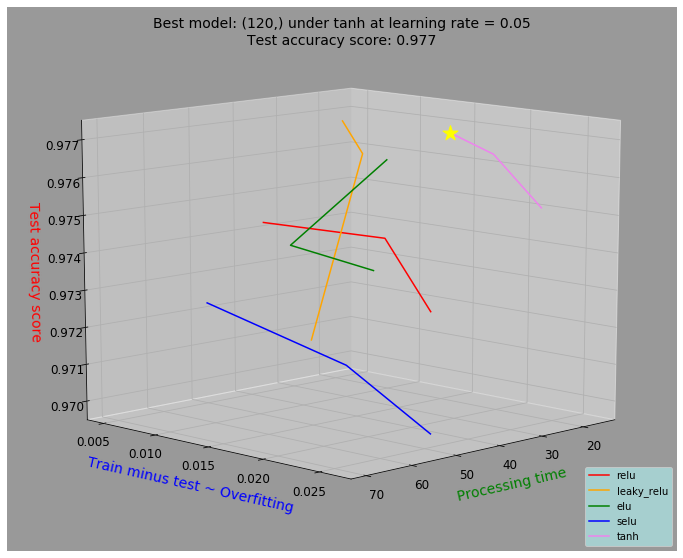

In [81]:
fig = plt.figure(figsize = (12, 10))
ax = fig.gca(projection='3d')
# fig, ax = plt.subplots(figsize = (10, 8))
fig.set_facecolor("white")
ax.set_facecolor("#999999")

ax.set_xlabel("\nProcessing time", color = "green")
ax.set_ylabel("\nTrain minus test ~ Overfitting", color = "b")
ax.set_zlabel("\nTest accuracy score", color = "red")

winning_entry = longcent_frame.sort_values(by = "test", ascending = False).head(1)
winning_score = float(winning_entry.test)
winning_tuple = str(winning_entry.topology).partition("(")[2].partition(")")[0]
winning_func  = str(winning_entry.activation).partition("    ")[2].partition("\n")[0]
winning_rate  = float(winning_entry.rate)
winning_label = "Best model: (" + winning_tuple + ") under " + winning_func
winning_label += " at learning rate = " + str(winning_rate) + "\n"
winning_label += "Test accuracy score: " + str(round(winning_score, 4))

def plot_func_lines(func_name, func_color):
    ax.plot(longcent_frame[longcent_frame.activation == func_name]["time"],
        longcent_frame[longcent_frame.activation == func_name]["train_minus_test"],
        longcent_frame[longcent_frame.activation == func_name]["test"],
        color = func_color, label = func_name)

"""
def scatter_model_dots(model_name, model_color, model_marker):
    ax.scatter(final_pipe[final_pipe.model == model_name]["standardized_time"],
               final_pipe[final_pipe.model == model_name]["train_minus_test"],
               final_pipe[final_pipe.model == model_name]["test_score"],
               s = 96, marker = model_marker, color = model_color, label = model_name)
"""
 
# scatter_model_dots("RandomForest", "red", "o")

plot_func_lines("relu", "red")
plot_func_lines("leaky_relu", "orange")
plot_func_lines("elu", "green")
plot_func_lines("selu", "blue")
plot_func_lines("tanh", "violet")

x_locate = float(winning_entry.time)
y_locate = float(winning_entry.train_minus_test)

ax.scatter(x_locate, y_locate, winning_score, s = 250, marker = "*", color = "yellow")

time_space =    np.linspace(longcent_frame.time.min(), longcent_frame.time.max(), 120)
overfit_space = np.linspace(longcent_frame.train_minus_test.min(), longcent_frame.train_minus_test.max(), 120)

# plot3d_title = winning_label + " | F1 score ≈ " + str(round(pipe_score, 6))
# plot3d_title +=  "\nStandardized time ≈ " + str(round(x_locate, 6))
# plot3d_title += " | Train minus test ≈ " + str(round(y_locate, 6))
ax.set_title(winning_label, fontsize = 14)

plot_x, plot_y = np.meshgrid(time_space, overfit_space)
score_plane = 0 * plot_x + 0 * plot_y + winning_score

# ax.plot_wireframe(plot_x, plot_y, score_plane, rcount = 6, ccount = 6, color = "orange")

# ax.plot_surface(plot_x, plot_y, score_plane, color = "#00884466")

ax.legend(loc ="lower right", facecolor = "#aadddd22")
ax.view_init(12, 45)
plt.savefig("longcent_frame.png")
plt.savefig("longcent_frame.pdf")

0 batch training accuracy:	0.96	Validation accuracy:	0.9236	 Loss score:	0.2822
1 batch training accuracy:	0.94	Validation accuracy:	0.9350	 Loss score:	0.2355
2 batch training accuracy:	0.92	Validation accuracy:	0.9438	 Loss score:	0.2014
3 batch training accuracy:	0.94	Validation accuracy:	0.9520	 Loss score:	0.1775
4 batch training accuracy:	1.00	Validation accuracy:	0.9546	 Loss score:	0.1620
5 batch training accuracy:	0.96	Validation accuracy:	0.9596	 Loss score:	0.1473
6 batch training accuracy:	0.98	Validation accuracy:	0.9634	 Loss score:	0.1364
7 batch training accuracy:	0.98	Validation accuracy:	0.9654	 Loss score:	0.1281
8 batch training accuracy:	1.00	Validation accuracy:	0.9664	 Loss score:	0.1211
9 batch training accuracy:	1.00	Validation accuracy:	0.9702	 Loss score:	0.1144
10 batch training accuracy:	1.00	Validation accuracy:	0.9698	 Loss score:	0.1105
11 batch training accuracy:	1.00	Validation accuracy:	0.9726	 Loss score:	0.1061
12 batch training accuracy:	0.94	Valid

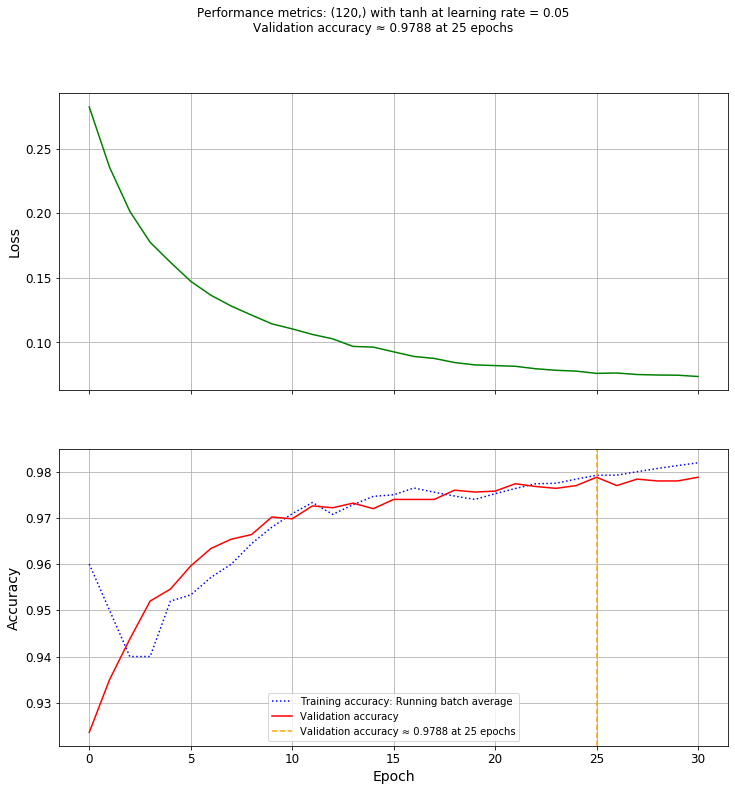

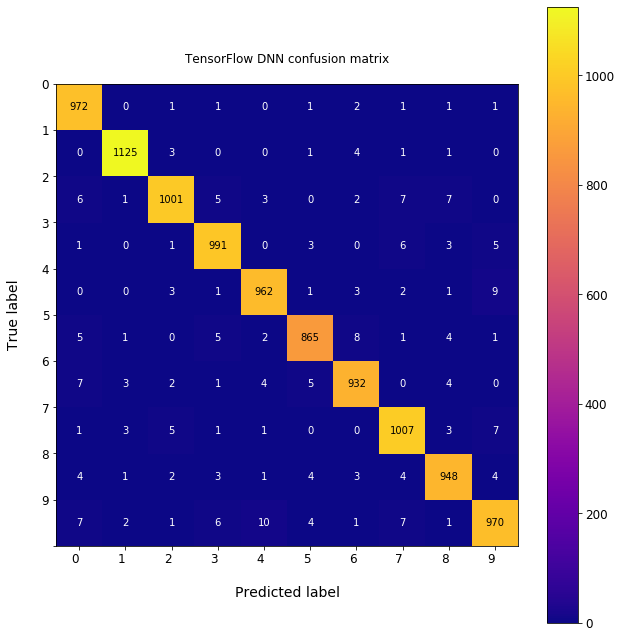

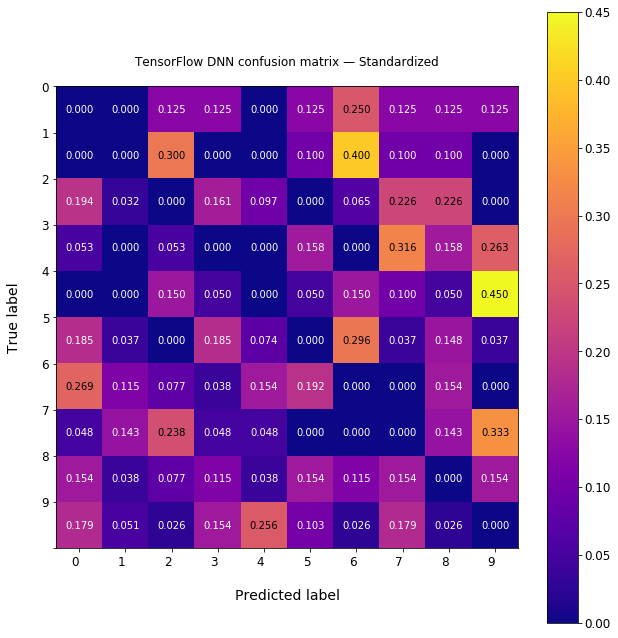

In [82]:
# The tanh model at (120, ) and learning rate = 0.05 does not appear to raise serious overfitting concerns

run_one_tf_model(topology_tuple = (120, ), activation = "tanh", learning_rate = 0.05, verbose = True)

In [83]:
# Now move to the 256 class
# hexsquared, of course, is 16²
# We will drop selu from single-layer models from this point forward

hexsquared_frame = pd.DataFrame(columns = frame_columns)

func_dict = {"relu": [0.01, 0.0], "leaky_relu": [0.05, 0.002],
             "elu": [0.05, 0.001], "selu": [0.01, 0.0], "tanh": [0.05, 0.0]}
count = 0

for func in func_dict:
    if func != "selu":
        hexsquared_frame.loc[count, "topology"] = (256, )
        hexsquared_frame.loc[count, "activation"] = func
        hexsquared_frame.loc[count, "rate"] = func_dict[func][0]
        hexsquared_frame.loc[count, "L1"] = 0.0
        hexsquared_frame.loc[count, "L2"] = func_dict[func][1]
        hexsquared_frame.loc[count, "train"] = 0.0
        hexsquared_frame.loc[count, "test"] = 0.0
        hexsquared_frame.loc[count, "train_minus_test"] = 0.0
        hexsquared_frame.loc[count, "time"] = 0.0
        count += 1

for func in func_dict:
    hexsquared_frame.loc[count, "topology"] = (192, 64)
    hexsquared_frame.loc[count, "activation"] = func
    hexsquared_frame.loc[count, "rate"] = func_dict[func][0]
    hexsquared_frame.loc[count, "L1"] = 0.0
    hexsquared_frame.loc[count, "L2"] = func_dict[func][1]
    hexsquared_frame.loc[count, "train"] = 0.0
    hexsquared_frame.loc[count, "test"] = 0.0
    hexsquared_frame.loc[count, "train_minus_test"] = 0.0
    hexsquared_frame.loc[count, "time"] = 0.0
    count += 1

for func in func_dict:
    hexsquared_frame.loc[count, "topology"] = (176, 60, 20)
    hexsquared_frame.loc[count, "activation"] = func
    hexsquared_frame.loc[count, "rate"] = func_dict[func][0]
    hexsquared_frame.loc[count, "L1"] = 0.0
    hexsquared_frame.loc[count, "L2"] = func_dict[func][1]
    hexsquared_frame.loc[count, "train"] = 0.0
    hexsquared_frame.loc[count, "test"] = 0.0
    hexsquared_frame.loc[count, "train_minus_test"] = 0.0
    hexsquared_frame.loc[count, "time"] = 0.0
    count += 1

for func in func_dict:
    hexsquared_frame.loc[count, "topology"] = (160, 56, 30, 10)
    hexsquared_frame.loc[count, "activation"] = func
    hexsquared_frame.loc[count, "rate"] = func_dict[func][0]
    hexsquared_frame.loc[count, "L1"] = 0.0
    hexsquared_frame.loc[count, "L2"] = func_dict[func][1]
    hexsquared_frame.loc[count, "train"] = 0.0
    hexsquared_frame.loc[count, "test"] = 0.0
    hexsquared_frame.loc[count, "train_minus_test"] = 0.0
    hexsquared_frame.loc[count, "time"] = 0.0
    count += 1
    
hexsquared_frame

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
0,"(256,)",relu,0.01,0,0,0,0,0,0
1,"(256,)",leaky_relu,0.05,0,0.002,0,0,0,0
2,"(256,)",elu,0.05,0,0.001,0,0,0,0
3,"(256,)",tanh,0.05,0,0,0,0,0,0
4,"(192, 64)",relu,0.01,0,0,0,0,0,0
5,"(192, 64)",leaky_relu,0.05,0,0.002,0,0,0,0
6,"(192, 64)",elu,0.05,0,0.001,0,0,0,0
7,"(192, 64)",selu,0.01,0,0,0,0,0,0
8,"(192, 64)",tanh,0.05,0,0,0,0,0,0
9,"(176, 60, 20)",relu,0.01,0,0,0,0,0,0


In [84]:
fill_frame(hexsquared_frame)

In [85]:
hexsquared_frame

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
0,"(256,)",relu,0.01,0,0,0.988782,0.9766,0.0121818,85.625
1,"(256,)",leaky_relu,0.05,0,0.002,0.978691,0.9739,0.0047909,56.469
2,"(256,)",elu,0.05,0,0.001,0.976582,0.9692,0.0073818,40.672
3,"(256,)",tanh,0.05,0,0,0.997655,0.9797,0.0179545,43.531
4,"(192, 64)",relu,0.01,0,0,0.990073,0.9748,0.0152727,34.703
5,"(192, 64)",leaky_relu,0.05,0,0.002,0.986073,0.976,0.0100727,30.391
6,"(192, 64)",elu,0.05,0,0.001,0.983909,0.9749,0.00900906,38.703
7,"(192, 64)",selu,0.01,0,0,0.991982,0.9734,0.0185818,58.406
8,"(192, 64)",tanh,0.05,0,0,0.998145,0.9789,0.0192454,24.61
9,"(176, 60, 20)",relu,0.01,0,0,0.994055,0.9745,0.0195546,33.328


In [86]:
hexsquared_frame.sort_values(by = "test", ascending = False)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
3,"(256,)",tanh,0.05,0,0,0.997655,0.9797,0.0179545,43.531
8,"(192, 64)",tanh,0.05,0,0,0.998145,0.9789,0.0192454,24.61
10,"(176, 60, 20)",leaky_relu,0.05,0,0.002,0.989127,0.9778,0.0113273,33.406
13,"(176, 60, 20)",tanh,0.05,0,0,0.998964,0.9769,0.0220637,21.953
0,"(256,)",relu,0.01,0,0,0.988782,0.9766,0.0121818,85.625
5,"(192, 64)",leaky_relu,0.05,0,0.002,0.986073,0.976,0.0100727,30.391
11,"(176, 60, 20)",elu,0.05,0,0.001,0.987655,0.9757,0.0119545,40.281
15,"(160, 56, 30, 10)",leaky_relu,0.05,0,0.002,0.985618,0.9756,0.0100182,20.609
14,"(160, 56, 30, 10)",relu,0.01,0,0,0.993618,0.9755,0.0181182,32.985
16,"(160, 56, 30, 10)",elu,0.05,0,0.001,0.985055,0.9749,0.0101545,26.078


In [87]:
hexsquared_frame.sort_values(by = "time", ascending = True)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
18,"(160, 56, 30, 10)",tanh,0.05,0,0,0.991582,0.9748,0.0167818,13.703
15,"(160, 56, 30, 10)",leaky_relu,0.05,0,0.002,0.985618,0.9756,0.0100182,20.609
13,"(176, 60, 20)",tanh,0.05,0,0,0.998964,0.9769,0.0220637,21.953
8,"(192, 64)",tanh,0.05,0,0,0.998145,0.9789,0.0192454,24.61
16,"(160, 56, 30, 10)",elu,0.05,0,0.001,0.985055,0.9749,0.0101545,26.078
5,"(192, 64)",leaky_relu,0.05,0,0.002,0.986073,0.976,0.0100727,30.391
14,"(160, 56, 30, 10)",relu,0.01,0,0,0.993618,0.9755,0.0181182,32.985
9,"(176, 60, 20)",relu,0.01,0,0,0.994055,0.9745,0.0195546,33.328
10,"(176, 60, 20)",leaky_relu,0.05,0,0.002,0.989127,0.9778,0.0113273,33.406
4,"(192, 64)",relu,0.01,0,0,0.990073,0.9748,0.0152727,34.703


In [88]:
hexsquared_frame.sort_values(by = "train_minus_test", ascending = False)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
17,"(160, 56, 30, 10)",selu,0.01,0,0,0.999236,0.9733,0.0259364,73.969
13,"(176, 60, 20)",tanh,0.05,0,0,0.998964,0.9769,0.0220637,21.953
12,"(176, 60, 20)",selu,0.01,0,0,0.993527,0.9723,0.0212273,45.36
9,"(176, 60, 20)",relu,0.01,0,0,0.994055,0.9745,0.0195546,33.328
8,"(192, 64)",tanh,0.05,0,0,0.998145,0.9789,0.0192454,24.61
7,"(192, 64)",selu,0.01,0,0,0.991982,0.9734,0.0185818,58.406
14,"(160, 56, 30, 10)",relu,0.01,0,0,0.993618,0.9755,0.0181182,32.985
3,"(256,)",tanh,0.05,0,0,0.997655,0.9797,0.0179545,43.531
18,"(160, 56, 30, 10)",tanh,0.05,0,0,0.991582,0.9748,0.0167818,13.703
4,"(192, 64)",relu,0.01,0,0,0.990073,0.9748,0.0152727,34.703


In [89]:
hexsquared_backup = hexsquared_frame.copy()
hexsquared_frame.sort_values(by = "test", ascending = False, inplace = True)

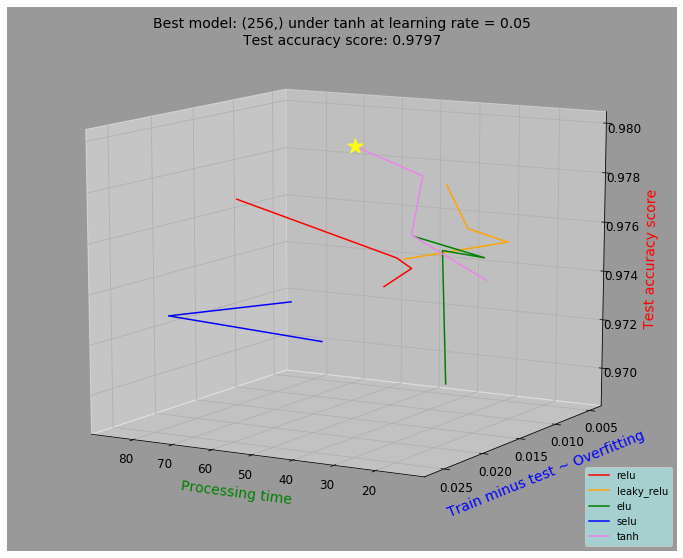

In [90]:
fig = plt.figure(figsize = (12, 10))
ax = fig.gca(projection='3d')
# fig, ax = plt.subplots(figsize = (10, 8))
fig.set_facecolor("white")
ax.set_facecolor("#999999")

ax.set_xlabel("\nProcessing time", color = "green")
ax.set_ylabel("\nTrain minus test ~ Overfitting", color = "b")
ax.set_zlabel("\nTest accuracy score", color = "red")

winning_entry = hexsquared_frame.sort_values(by = "test", ascending = False).head(1)
winning_score = float(winning_entry.test)
winning_tuple = str(winning_entry.topology).partition("(")[2].partition(")")[0]
winning_func  = str(winning_entry.activation).partition("    ")[2].partition("\n")[0]
winning_rate  = float(winning_entry.rate)
winning_label = "Best model: (" + winning_tuple + ") under " + winning_func
winning_label += " at learning rate = " + str(winning_rate) + "\n"
winning_label += "Test accuracy score: " + str(round(winning_score, 4))

def plot_func_lines(func_name, func_color):
    ax.plot(hexsquared_frame[hexsquared_frame.activation == func_name]["time"],
        hexsquared_frame[hexsquared_frame.activation == func_name]["train_minus_test"],
        hexsquared_frame[hexsquared_frame.activation == func_name]["test"],
        color = func_color, label = func_name)

"""
def scatter_model_dots(model_name, model_color, model_marker):
    ax.scatter(final_pipe[final_pipe.model == model_name]["standardized_time"],
               final_pipe[final_pipe.model == model_name]["train_minus_test"],
               final_pipe[final_pipe.model == model_name]["test_score"],
               s = 96, marker = model_marker, color = model_color, label = model_name)
"""
 
# scatter_model_dots("RandomForest", "red", "o")

plot_func_lines("relu", "red")
plot_func_lines("leaky_relu", "orange")
plot_func_lines("elu", "green")
plot_func_lines("selu", "blue")
plot_func_lines("tanh", "violet")

x_locate = float(winning_entry.time)
y_locate = float(winning_entry.train_minus_test)

ax.scatter(x_locate, y_locate, winning_score, s = 250, marker = "*", color = "yellow")

time_space =    np.linspace(hexsquared_frame.time.min(), hexsquared_frame.time.max(), 120)
overfit_space = np.linspace(hexsquared_frame.train_minus_test.min(), hexsquared_frame.train_minus_test.max(), 120)

# plot3d_title = winning_label + " | F1 score ≈ " + str(round(pipe_score, 6))
# plot3d_title +=  "\nStandardized time ≈ " + str(round(x_locate, 6))
# plot3d_title += " | Train minus test ≈ " + str(round(y_locate, 6))
ax.set_title(winning_label, fontsize = 14)

plot_x, plot_y = np.meshgrid(time_space, overfit_space)
score_plane = 0 * plot_x + 0 * plot_y + winning_score

# ax.plot_wireframe(plot_x, plot_y, score_plane, rcount = 6, ccount = 6, color = "orange")

# ax.plot_surface(plot_x, plot_y, score_plane, color = "#00884466")

ax.legend(loc ="lower right", facecolor = "#aadddd22")
ax.view_init(12, 120)
plt.savefig("hexsquared_frame.png")
plt.savefig("hexsquared_frame.pdf")

There are other perspectives available, but this 120° view beats the 45° default in showing how selu is struggling with overfitting, processing time, *and* predictive performance as the model grows in topological complexity. We will drop selu from further trials.

Tanh is doing quite well, though its processing time advantage in previous rounds is eroding. Concerns with overfitting warrant dropping the learning rate for tanh down to 0.03.

Let's move to 400 neurons, which is the number implied by Géron's default choice of a (300, 100) DNN.

In [91]:
# Now move to the 400 class
# fourhundred is the easily remembered name!
# In light of its poor performance as complexity rises, we will drop selu altogether from this point forward
# In addition, tanh's tendency toward overfitting prompts us to drop its learning rate from 0.05 to 0.03

fourhundred_frame = pd.DataFrame(columns = frame_columns)

func_dict = {"relu": [0.01, 0.0], "leaky_relu": [0.05, 0.002],
             "elu": [0.05, 0.001], "tanh": [0.03, 0.0]}
count = 0

for func in func_dict:
    fourhundred_frame.loc[count, "topology"] = (400, )
    fourhundred_frame.loc[count, "activation"] = func
    fourhundred_frame.loc[count, "rate"] = func_dict[func][0]
    fourhundred_frame.loc[count, "L1"] = 0.0
    fourhundred_frame.loc[count, "L2"] = func_dict[func][1]
    fourhundred_frame.loc[count, "train"] = 0.0
    fourhundred_frame.loc[count, "test"] = 0.0
    fourhundred_frame.loc[count, "train_minus_test"] = 0.0
    fourhundred_frame.loc[count, "time"] = 0.0
    count += 1

for func in func_dict:
    fourhundred_frame.loc[count, "topology"] = (300, 100)
    fourhundred_frame.loc[count, "activation"] = func
    fourhundred_frame.loc[count, "rate"] = func_dict[func][0]
    fourhundred_frame.loc[count, "L1"] = 0.0
    fourhundred_frame.loc[count, "L2"] = func_dict[func][1]
    fourhundred_frame.loc[count, "train"] = 0.0
    fourhundred_frame.loc[count, "test"] = 0.0
    fourhundred_frame.loc[count, "train_minus_test"] = 0.0
    fourhundred_frame.loc[count, "time"] = 0.0
    count += 1

for func in func_dict:
    fourhundred_frame.loc[count, "topology"] = (250, 100, 50)
    fourhundred_frame.loc[count, "activation"] = func
    fourhundred_frame.loc[count, "rate"] = func_dict[func][0]
    fourhundred_frame.loc[count, "L1"] = 0.0
    fourhundred_frame.loc[count, "L2"] = func_dict[func][1]
    fourhundred_frame.loc[count, "train"] = 0.0
    fourhundred_frame.loc[count, "test"] = 0.0
    fourhundred_frame.loc[count, "train_minus_test"] = 0.0
    fourhundred_frame.loc[count, "time"] = 0.0
    count += 1

for func in func_dict:
    fourhundred_frame.loc[count, "topology"] = (200, 100, 65, 25, 10)
    fourhundred_frame.loc[count, "activation"] = func
    fourhundred_frame.loc[count, "rate"] = func_dict[func][0]
    fourhundred_frame.loc[count, "L1"] = 0.0
    fourhundred_frame.loc[count, "L2"] = func_dict[func][1]
    fourhundred_frame.loc[count, "train"] = 0.0
    fourhundred_frame.loc[count, "test"] = 0.0
    fourhundred_frame.loc[count, "train_minus_test"] = 0.0
    fourhundred_frame.loc[count, "time"] = 0.0
    count += 1
    
fourhundred_frame

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
0,"(400,)",relu,0.01,0,0,0,0,0,0
1,"(400,)",leaky_relu,0.05,0,0.002,0,0,0,0
2,"(400,)",elu,0.05,0,0.001,0,0,0,0
3,"(400,)",tanh,0.03,0,0,0,0,0,0
4,"(300, 100)",relu,0.01,0,0,0,0,0,0
5,"(300, 100)",leaky_relu,0.05,0,0.002,0,0,0,0
6,"(300, 100)",elu,0.05,0,0.001,0,0,0,0
7,"(300, 100)",tanh,0.03,0,0,0,0,0,0
8,"(250, 100, 50)",relu,0.01,0,0,0,0,0,0
9,"(250, 100, 50)",leaky_relu,0.05,0,0.002,0,0,0,0


In [92]:
fill_frame(fourhundred_frame)

In [93]:
fourhundred_frame

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
0,"(400,)",relu,0.01,0,0,0.988164,0.9761,0.0120636,77.422
1,"(400,)",leaky_relu,0.05,0,0.002,0.977436,0.9727,0.00473636,72.141
2,"(400,)",elu,0.05,0,0.001,0.979655,0.9728,0.00685453,79.234
3,"(400,)",tanh,0.03,0,0,0.987855,0.9754,0.0124546,44.375
4,"(300, 100)",relu,0.01,0,0,0.993564,0.9774,0.0161636,53.188
5,"(300, 100)",leaky_relu,0.05,0,0.002,0.986636,0.9789,0.00773633,53.062
6,"(300, 100)",elu,0.05,0,0.001,0.983909,0.9747,0.0092091,44.453
7,"(300, 100)",tanh,0.03,0,0,0.992855,0.9777,0.0151545,35.297
8,"(250, 100, 50)",relu,0.01,0,0,0.9956,0.9751,0.0205,48.75
9,"(250, 100, 50)",leaky_relu,0.05,0,0.002,0.987491,0.9783,0.00919092,35.375


In [94]:
fourhundred_backup = fourhundred_frame.copy()

In [95]:
fourhundred_frame.sort_values(by = "test", ascending = False)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
11,"(250, 100, 50)",tanh,0.03,0,0,0.999309,0.9795,0.0198091,41.953
5,"(300, 100)",leaky_relu,0.05,0,0.002,0.986636,0.9789,0.00773633,53.062
9,"(250, 100, 50)",leaky_relu,0.05,0,0.002,0.987491,0.9783,0.00919092,35.375
7,"(300, 100)",tanh,0.03,0,0,0.992855,0.9777,0.0151545,35.297
4,"(300, 100)",relu,0.01,0,0,0.993564,0.9774,0.0161636,53.188
13,"(200, 100, 65, 25, 10)",leaky_relu,0.05,0,0.002,0.989909,0.9769,0.0130091,23.469
15,"(200, 100, 65, 25, 10)",tanh,0.03,0,0,0.998309,0.9768,0.0215091,33.797
0,"(400,)",relu,0.01,0,0,0.988164,0.9761,0.0120636,77.422
10,"(250, 100, 50)",elu,0.05,0,0.001,0.984655,0.9756,0.00905454,36.438
3,"(400,)",tanh,0.03,0,0,0.987855,0.9754,0.0124546,44.375


In [96]:
fourhundred_frame.sort_values(by = "time", ascending = True)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
13,"(200, 100, 65, 25, 10)",leaky_relu,0.05,0,0.002,0.989909,0.9769,0.0130091,23.469
12,"(200, 100, 65, 25, 10)",relu,0.01,0,0,0.993273,0.9714,0.0218727,25.64
15,"(200, 100, 65, 25, 10)",tanh,0.03,0,0,0.998309,0.9768,0.0215091,33.797
7,"(300, 100)",tanh,0.03,0,0,0.992855,0.9777,0.0151545,35.297
9,"(250, 100, 50)",leaky_relu,0.05,0,0.002,0.987491,0.9783,0.00919092,35.375
14,"(200, 100, 65, 25, 10)",elu,0.05,0,0.001,0.984764,0.9733,0.0114636,36.297
10,"(250, 100, 50)",elu,0.05,0,0.001,0.984655,0.9756,0.00905454,36.438
11,"(250, 100, 50)",tanh,0.03,0,0,0.999309,0.9795,0.0198091,41.953
3,"(400,)",tanh,0.03,0,0,0.987855,0.9754,0.0124546,44.375
6,"(300, 100)",elu,0.05,0,0.001,0.983909,0.9747,0.0092091,44.453


In [97]:
fourhundred_frame.sort_values(by = "train_minus_test", ascending = True)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
1,"(400,)",leaky_relu,0.05,0,0.002,0.977436,0.9727,0.00473636,72.141
2,"(400,)",elu,0.05,0,0.001,0.979655,0.9728,0.00685453,79.234
5,"(300, 100)",leaky_relu,0.05,0,0.002,0.986636,0.9789,0.00773633,53.062
10,"(250, 100, 50)",elu,0.05,0,0.001,0.984655,0.9756,0.00905454,36.438
9,"(250, 100, 50)",leaky_relu,0.05,0,0.002,0.987491,0.9783,0.00919092,35.375
6,"(300, 100)",elu,0.05,0,0.001,0.983909,0.9747,0.0092091,44.453
14,"(200, 100, 65, 25, 10)",elu,0.05,0,0.001,0.984764,0.9733,0.0114636,36.297
0,"(400,)",relu,0.01,0,0,0.988164,0.9761,0.0120636,77.422
3,"(400,)",tanh,0.03,0,0,0.987855,0.9754,0.0124546,44.375
13,"(200, 100, 65, 25, 10)",leaky_relu,0.05,0,0.002,0.989909,0.9769,0.0130091,23.469


In [98]:
fourhundred_frame.sort_values(by = "test", ascending = False, inplace = True)

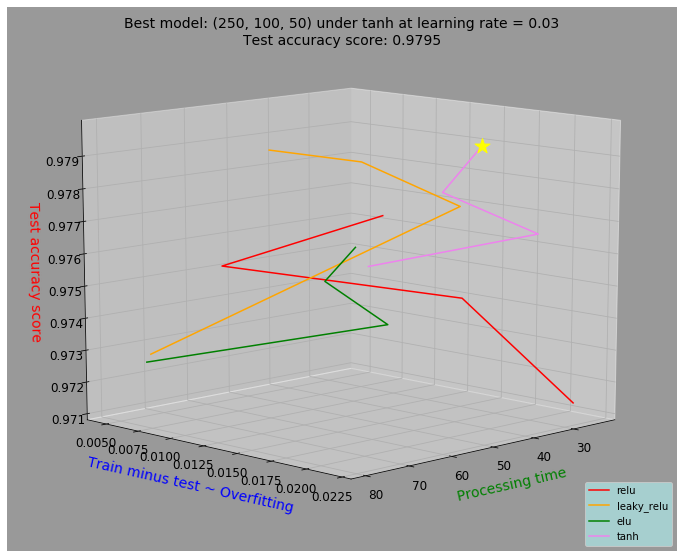

In [99]:
fig = plt.figure(figsize = (12, 10))
ax = fig.gca(projection='3d')
# fig, ax = plt.subplots(figsize = (10, 8))
fig.set_facecolor("white")
ax.set_facecolor("#999999")

ax.set_xlabel("\nProcessing time", color = "green")
ax.set_ylabel("\nTrain minus test ~ Overfitting", color = "b")
ax.set_zlabel("\nTest accuracy score", color = "red")

winning_entry = fourhundred_frame.sort_values(by = "test", ascending = False).head(1)
winning_score = float(winning_entry.test)
winning_tuple = str(winning_entry.topology).partition("(")[2].partition(")")[0]
winning_func  = str(winning_entry.activation).partition("    ")[2].partition("\n")[0]
winning_rate  = float(winning_entry.rate)
winning_label = "Best model: (" + winning_tuple + ") under " + winning_func
winning_label += " at learning rate = " + str(winning_rate) + "\n"
winning_label += "Test accuracy score: " + str(round(winning_score, 4))

def plot_func_lines(func_name, func_color):
    ax.plot(fourhundred_frame[fourhundred_frame.activation == func_name]["time"],
        fourhundred_frame[fourhundred_frame.activation == func_name]["train_minus_test"],
        fourhundred_frame[fourhundred_frame.activation == func_name]["test"],
        color = func_color, label = func_name)

"""
def scatter_model_dots(model_name, model_color, model_marker):
    ax.scatter(final_pipe[final_pipe.model == model_name]["standardized_time"],
               final_pipe[final_pipe.model == model_name]["train_minus_test"],
               final_pipe[final_pipe.model == model_name]["test_score"],
               s = 96, marker = model_marker, color = model_color, label = model_name)
"""
 
# scatter_model_dots("RandomForest", "red", "o")

plot_func_lines("relu", "red")
plot_func_lines("leaky_relu", "orange")
plot_func_lines("elu", "green")
# plot_func_lines("selu", "blue")
plot_func_lines("tanh", "violet")

x_locate = float(winning_entry.time)
y_locate = float(winning_entry.train_minus_test)

ax.scatter(x_locate, y_locate, winning_score, s = 250, marker = "*", color = "yellow")

time_space =    np.linspace(fourhundred_frame.time.min(), fourhundred_frame.time.max(), 120)
overfit_space = np.linspace(fourhundred_frame.train_minus_test.min(), fourhundred_frame.train_minus_test.max(), 120)

# plot3d_title = winning_label + " | F1 score ≈ " + str(round(pipe_score, 6))
# plot3d_title +=  "\nStandardized time ≈ " + str(round(x_locate, 6))
# plot3d_title += " | Train minus test ≈ " + str(round(y_locate, 6))
ax.set_title(winning_label, fontsize = 14)

plot_x, plot_y = np.meshgrid(time_space, overfit_space)
score_plane = 0 * plot_x + 0 * plot_y + winning_score

# ax.plot_wireframe(plot_x, plot_y, score_plane, rcount = 6, ccount = 6, color = "orange")

# ax.plot_surface(plot_x, plot_y, score_plane, color = "#00884466")

ax.legend(loc ="lower right", facecolor = "#aadddd22")
ax.view_init(12, 45)
plt.savefig("fourhundred_frame.png")
plt.savefig("fourhundred_frame.pdf")

One thing does emerge from the round of 400 neurons. As we approach or exceed the predictive capabilities of this class of machine-learning models, single-layer topologies are beginning to lag. They also consume considerable amounts of time. As we proceed to 625 neurons, we will abandon further examination of single-layer models.

In [100]:
# Now move to the 625 class
# fivefour is the new name, based on 5 ** 4 = 625
# No more single-layer models
# In addition, tanh's tendency toward overfitting prompts us to drop its learning rate from 0.05 to 0.03

fivefour_frame = pd.DataFrame(columns = frame_columns)

func_dict = {"relu": [0.01, 0.0], "leaky_relu": [0.05, 0.002],
             "elu": [0.05, 0.001], "tanh": [0.03, 0.0]}
count = 0

for func in func_dict:
    fivefour_frame.loc[count, "topology"] = (475, 150)
    fivefour_frame.loc[count, "activation"] = func
    fivefour_frame.loc[count, "rate"] = func_dict[func][0]
    fivefour_frame.loc[count, "L1"] = 0.0
    fivefour_frame.loc[count, "L2"] = func_dict[func][1]
    fivefour_frame.loc[count, "train"] = 0.0
    fivefour_frame.loc[count, "test"] = 0.0
    fivefour_frame.loc[count, "train_minus_test"] = 0.0
    fivefour_frame.loc[count, "time"] = 0.0
    count += 1

for func in func_dict:
    fivefour_frame.loc[count, "topology"] = (375, 150, 75, 25)
    fivefour_frame.loc[count, "activation"] = func
    fivefour_frame.loc[count, "rate"] = func_dict[func][0]
    fivefour_frame.loc[count, "L1"] = 0.0
    fivefour_frame.loc[count, "L2"] = func_dict[func][1]
    fivefour_frame.loc[count, "train"] = 0.0
    fivefour_frame.loc[count, "test"] = 0.0
    fivefour_frame.loc[count, "train_minus_test"] = 0.0
    fivefour_frame.loc[count, "time"] = 0.0
    count += 1

for func in func_dict:
    fivefour_frame.loc[count, "topology"] = (300, 135, 90, 60, 30, 10)
    fivefour_frame.loc[count, "activation"] = func
    fivefour_frame.loc[count, "rate"] = func_dict[func][0]
    fivefour_frame.loc[count, "L1"] = 0.0
    fivefour_frame.loc[count, "L2"] = func_dict[func][1]
    fivefour_frame.loc[count, "train"] = 0.0
    fivefour_frame.loc[count, "test"] = 0.0
    fivefour_frame.loc[count, "train_minus_test"] = 0.0
    fivefour_frame.loc[count, "time"] = 0.0
    count += 1

fivefour_frame

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
0,"(475, 150)",relu,0.01,0,0,0,0,0,0
1,"(475, 150)",leaky_relu,0.05,0,0.002,0,0,0,0
2,"(475, 150)",elu,0.05,0,0.001,0,0,0,0
3,"(475, 150)",tanh,0.03,0,0,0,0,0,0
4,"(375, 150, 75, 25)",relu,0.01,0,0,0,0,0,0
5,"(375, 150, 75, 25)",leaky_relu,0.05,0,0.002,0,0,0,0
6,"(375, 150, 75, 25)",elu,0.05,0,0.001,0,0,0,0
7,"(375, 150, 75, 25)",tanh,0.03,0,0,0,0,0,0
8,"(300, 135, 90, 60, 30, 10)",relu,0.01,0,0,0,0,0,0
9,"(300, 135, 90, 60, 30, 10)",leaky_relu,0.05,0,0.002,0,0,0,0


In [101]:
fill_frame(fivefour_frame)

In [102]:
fivefour_frame

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
0,"(475, 150)",relu,0.01,0,0,0.995436,0.979,0.0164364,78.313
1,"(475, 150)",leaky_relu,0.05,0,0.002,0.987545,0.9769,0.0106454,62.625
2,"(475, 150)",elu,0.05,0,0.001,0.985618,0.9749,0.0107182,114.219
3,"(475, 150)",tanh,0.03,0,0,0.998709,0.9804,0.0183091,72.75
4,"(375, 150, 75, 25)",relu,0.01,0,0,0.992655,0.9766,0.0160546,44.578
5,"(375, 150, 75, 25)",leaky_relu,0.05,0,0.002,0.983055,0.974,0.00905454,46.515
6,"(375, 150, 75, 25)",elu,0.05,0,0.001,0.987164,0.9765,0.0106637,83.329
7,"(375, 150, 75, 25)",tanh,0.03,0,0,0.999182,0.9784,0.0207818,52.218
8,"(300, 135, 90, 60, 30, 10)",relu,0.01,0,0,0.994873,0.9679,0.0269728,43.141
9,"(300, 135, 90, 60, 30, 10)",leaky_relu,0.05,0,0.002,0.9922,0.9764,0.0158,30.968


In [103]:
fivefour_backup = fivefour_frame.copy()

In [104]:
fivefour_frame.sort_values(by = "test", ascending = False)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
3,"(475, 150)",tanh,0.03,0,0,0.998709,0.9804,0.0183091,72.75
11,"(300, 135, 90, 60, 30, 10)",tanh,0.03,0,0,0.999636,0.9792,0.0204363,51.063
0,"(475, 150)",relu,0.01,0,0,0.995436,0.979,0.0164364,78.313
7,"(375, 150, 75, 25)",tanh,0.03,0,0,0.999182,0.9784,0.0207818,52.218
1,"(475, 150)",leaky_relu,0.05,0,0.002,0.987545,0.9769,0.0106454,62.625
4,"(375, 150, 75, 25)",relu,0.01,0,0,0.992655,0.9766,0.0160546,44.578
6,"(375, 150, 75, 25)",elu,0.05,0,0.001,0.987164,0.9765,0.0106637,83.329
9,"(300, 135, 90, 60, 30, 10)",leaky_relu,0.05,0,0.002,0.9922,0.9764,0.0158,30.968
2,"(475, 150)",elu,0.05,0,0.001,0.985618,0.9749,0.0107182,114.219
10,"(300, 135, 90, 60, 30, 10)",elu,0.05,0,0.001,0.985782,0.9749,0.0108818,32.688


In [105]:
fivefour_frame.sort_values(by = "time", ascending = True)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
9,"(300, 135, 90, 60, 30, 10)",leaky_relu,0.05,0,0.002,0.9922,0.9764,0.0158,30.968
10,"(300, 135, 90, 60, 30, 10)",elu,0.05,0,0.001,0.985782,0.9749,0.0108818,32.688
8,"(300, 135, 90, 60, 30, 10)",relu,0.01,0,0,0.994873,0.9679,0.0269728,43.141
4,"(375, 150, 75, 25)",relu,0.01,0,0,0.992655,0.9766,0.0160546,44.578
5,"(375, 150, 75, 25)",leaky_relu,0.05,0,0.002,0.983055,0.974,0.00905454,46.515
11,"(300, 135, 90, 60, 30, 10)",tanh,0.03,0,0,0.999636,0.9792,0.0204363,51.063
7,"(375, 150, 75, 25)",tanh,0.03,0,0,0.999182,0.9784,0.0207818,52.218
1,"(475, 150)",leaky_relu,0.05,0,0.002,0.987545,0.9769,0.0106454,62.625
3,"(475, 150)",tanh,0.03,0,0,0.998709,0.9804,0.0183091,72.75
0,"(475, 150)",relu,0.01,0,0,0.995436,0.979,0.0164364,78.313


When it comes to processing time, relu registers an interesting result. The bigger the first layer in a model containing many neurons, the harder and longer relu strains.

In [106]:
fivefour_frame.sort_values(by = "train_minus_test", ascending = True)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
5,"(375, 150, 75, 25)",leaky_relu,0.05,0,0.002,0.983055,0.974,0.00905454,46.515
1,"(475, 150)",leaky_relu,0.05,0,0.002,0.987545,0.9769,0.0106454,62.625
6,"(375, 150, 75, 25)",elu,0.05,0,0.001,0.987164,0.9765,0.0106637,83.329
2,"(475, 150)",elu,0.05,0,0.001,0.985618,0.9749,0.0107182,114.219
10,"(300, 135, 90, 60, 30, 10)",elu,0.05,0,0.001,0.985782,0.9749,0.0108818,32.688
9,"(300, 135, 90, 60, 30, 10)",leaky_relu,0.05,0,0.002,0.9922,0.9764,0.0158,30.968
4,"(375, 150, 75, 25)",relu,0.01,0,0,0.992655,0.9766,0.0160546,44.578
0,"(475, 150)",relu,0.01,0,0,0.995436,0.979,0.0164364,78.313
3,"(475, 150)",tanh,0.03,0,0,0.998709,0.9804,0.0183091,72.75
11,"(300, 135, 90, 60, 30, 10)",tanh,0.03,0,0,0.999636,0.9792,0.0204363,51.063


All of the regularized models outperform their unregularized counterparts in avoidance of overfitting. This is not a particularly surprising result.

In [107]:
fivefour_frame.sort_values(by = "test", ascending = False, inplace = True)

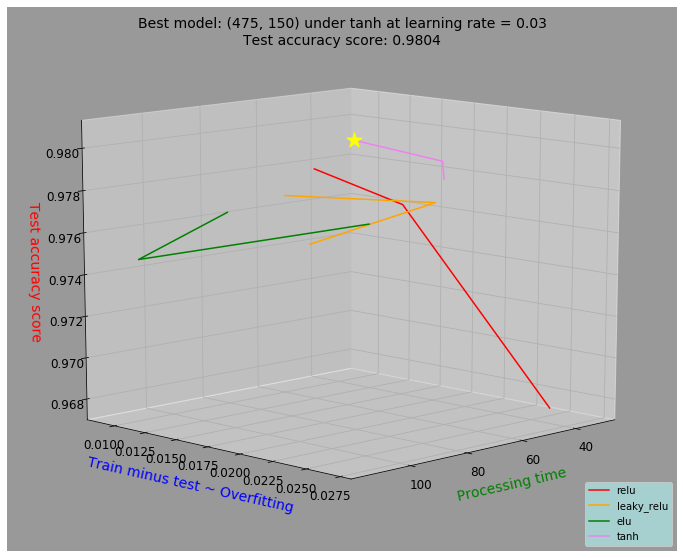

In [108]:
fig = plt.figure(figsize = (12, 10))
ax = fig.gca(projection='3d')
# fig, ax = plt.subplots(figsize = (10, 8))
fig.set_facecolor("white")
ax.set_facecolor("#999999")

ax.set_xlabel("\nProcessing time", color = "green")
ax.set_ylabel("\nTrain minus test ~ Overfitting", color = "b")
ax.set_zlabel("\nTest accuracy score", color = "red")

winning_entry = fivefour_frame.sort_values(by = "test", ascending = False).head(1)
winning_score = float(winning_entry.test)
winning_tuple = str(winning_entry.topology).partition("(")[2].partition(")")[0]
winning_func  = str(winning_entry.activation).partition("    ")[2].partition("\n")[0]
winning_rate  = float(winning_entry.rate)
winning_label = "Best model: (" + winning_tuple + ") under " + winning_func
winning_label += " at learning rate = " + str(winning_rate) + "\n"
winning_label += "Test accuracy score: " + str(round(winning_score, 4))

def plot_func_lines(func_name, func_color):
    ax.plot(fivefour_frame[fivefour_frame.activation == func_name]["time"],
        fivefour_frame[fivefour_frame.activation == func_name]["train_minus_test"],
        fivefour_frame[fivefour_frame.activation == func_name]["test"],
        color = func_color, label = func_name)

"""
def scatter_model_dots(model_name, model_color, model_marker):
    ax.scatter(final_pipe[final_pipe.model == model_name]["standardized_time"],
               final_pipe[final_pipe.model == model_name]["train_minus_test"],
               final_pipe[final_pipe.model == model_name]["test_score"],
               s = 96, marker = model_marker, color = model_color, label = model_name)
"""
 
# scatter_model_dots("RandomForest", "red", "o")

plot_func_lines("relu", "red")
plot_func_lines("leaky_relu", "orange")
plot_func_lines("elu", "green")
# plot_func_lines("selu", "blue")
plot_func_lines("tanh", "violet")

x_locate = float(winning_entry.time)
y_locate = float(winning_entry.train_minus_test)

ax.scatter(x_locate, y_locate, winning_score, s = 250, marker = "*", color = "yellow")

time_space =    np.linspace(fivefour_frame.time.min(), fivefour_frame.time.max(), 120)
overfit_space = np.linspace(fivefour_frame.train_minus_test.min(), fivefour_frame.train_minus_test.max(), 120)

# plot3d_title = winning_label + " | F1 score ≈ " + str(round(pipe_score, 6))
# plot3d_title +=  "\nStandardized time ≈ " + str(round(x_locate, 6))
# plot3d_title += " | Train minus test ≈ " + str(round(y_locate, 6))
ax.set_title(winning_label, fontsize = 14)

plot_x, plot_y = np.meshgrid(time_space, overfit_space)
score_plane = 0 * plot_x + 0 * plot_y + winning_score

# ax.plot_wireframe(plot_x, plot_y, score_plane, rcount = 6, ccount = 6, color = "orange")

# ax.plot_surface(plot_x, plot_y, score_plane, color = "#00884466")

ax.legend(loc ="lower right", facecolor = "#aadddd22")
ax.view_init(12, 45)
plt.savefig("fivefour_frame.png")
plt.savefig("fivefour_frame.pdf")

Perhaps surprisingly, neither predictive performance nor processing efficiency has begun to deteriorate. This may be tempting fate, but we will run one final round. Two 1000-neuron objects, both cut up among many layers.

In [109]:
# We end with a pair of 1000-neuron models
# The name of the dataframe, unsurprisingly, is thousand_frame
# These must be deeply layered: One is six deep. The other has eight layers.

thousand_frame = pd.DataFrame(columns = frame_columns)

func_dict = {"relu": [0.01, 0.0], "leaky_relu": [0.05, 0.002],
             "elu": [0.05, 0.001], "tanh": [0.03, 0.0]}
count = 0

for func in func_dict:
    thousand_frame.loc[count, "topology"] = (512, 256, 128, 64, 30, 10)
    thousand_frame.loc[count, "activation"] = func
    thousand_frame.loc[count, "rate"] = func_dict[func][0]
    thousand_frame.loc[count, "L1"] = 0.0
    thousand_frame.loc[count, "L2"] = func_dict[func][1]
    thousand_frame.loc[count, "train"] = 0.0
    thousand_frame.loc[count, "test"] = 0.0
    thousand_frame.loc[count, "train_minus_test"] = 0.0
    thousand_frame.loc[count, "time"] = 0.0
    count += 1

for func in func_dict:
    thousand_frame.loc[count, "topology"] = (300, 200, 160, 120, 90, 70, 40, 20)
    thousand_frame.loc[count, "activation"] = func
    thousand_frame.loc[count, "rate"] = func_dict[func][0]
    thousand_frame.loc[count, "L1"] = 0.0
    thousand_frame.loc[count, "L2"] = func_dict[func][1]
    thousand_frame.loc[count, "train"] = 0.0
    thousand_frame.loc[count, "test"] = 0.0
    thousand_frame.loc[count, "train_minus_test"] = 0.0
    thousand_frame.loc[count, "time"] = 0.0
    count += 1

thousand_frame

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
0,"(512, 256, 128, 64, 30, 10)",relu,0.01,0,0,0,0,0,0
1,"(512, 256, 128, 64, 30, 10)",leaky_relu,0.05,0,0.002,0,0,0,0
2,"(512, 256, 128, 64, 30, 10)",elu,0.05,0,0.001,0,0,0,0
3,"(512, 256, 128, 64, 30, 10)",tanh,0.03,0,0,0,0,0,0
4,"(300, 200, 160, 120, 90, 70, 40, 20)",relu,0.01,0,0,0,0,0,0
5,"(300, 200, 160, 120, 90, 70, 40, 20)",leaky_relu,0.05,0,0.002,0,0,0,0
6,"(300, 200, 160, 120, 90, 70, 40, 20)",elu,0.05,0,0.001,0,0,0,0
7,"(300, 200, 160, 120, 90, 70, 40, 20)",tanh,0.03,0,0,0,0,0,0


In [110]:
fill_frame(thousand_frame)

In [111]:
thousand_frame

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
0,"(512, 256, 128, 64, 30, 10)",relu,0.01,0,0,0.999636,0.9741,0.0255364,65.141
1,"(512, 256, 128, 64, 30, 10)",leaky_relu,0.05,0,0.002,0.991764,0.9756,0.0161636,62.64
2,"(512, 256, 128, 64, 30, 10)",elu,0.05,0,0.001,0.986964,0.9752,0.0117636,78.094
3,"(512, 256, 128, 64, 30, 10)",tanh,0.03,0,0,0.999127,0.979,0.0201273,56.906
4,"(300, 200, 160, 120, 90, 70, 40, 20)",relu,0.01,0,0,1,0.9734,0.0266,95.25
5,"(300, 200, 160, 120, 90, 70, 40, 20)",leaky_relu,0.05,0,0.002,0.985109,0.9697,0.0154091,55.937
6,"(300, 200, 160, 120, 90, 70, 40, 20)",elu,0.05,0,0.001,0.985145,0.9756,0.00954545,56.063
7,"(300, 200, 160, 120, 90, 70, 40, 20)",tanh,0.03,0,0,0.996364,0.9749,0.0214636,43.047


In [112]:
thousand_backup = thousand_frame.copy()

In [113]:
thousand_frame.sort_values(by = "test", ascending = False)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
3,"(512, 256, 128, 64, 30, 10)",tanh,0.03,0,0,0.999127,0.979,0.0201273,56.906
1,"(512, 256, 128, 64, 30, 10)",leaky_relu,0.05,0,0.002,0.991764,0.9756,0.0161636,62.64
6,"(300, 200, 160, 120, 90, 70, 40, 20)",elu,0.05,0,0.001,0.985145,0.9756,0.00954545,56.063
2,"(512, 256, 128, 64, 30, 10)",elu,0.05,0,0.001,0.986964,0.9752,0.0117636,78.094
7,"(300, 200, 160, 120, 90, 70, 40, 20)",tanh,0.03,0,0,0.996364,0.9749,0.0214636,43.047
0,"(512, 256, 128, 64, 30, 10)",relu,0.01,0,0,0.999636,0.9741,0.0255364,65.141
4,"(300, 200, 160, 120, 90, 70, 40, 20)",relu,0.01,0,0,1,0.9734,0.0266,95.25
5,"(300, 200, 160, 120, 90, 70, 40, 20)",leaky_relu,0.05,0,0.002,0.985109,0.9697,0.0154091,55.937


In [114]:
thousand_frame.sort_values(by = "time", ascending = True)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
7,"(300, 200, 160, 120, 90, 70, 40, 20)",tanh,0.03,0,0,0.996364,0.9749,0.0214636,43.047
5,"(300, 200, 160, 120, 90, 70, 40, 20)",leaky_relu,0.05,0,0.002,0.985109,0.9697,0.0154091,55.937
6,"(300, 200, 160, 120, 90, 70, 40, 20)",elu,0.05,0,0.001,0.985145,0.9756,0.00954545,56.063
3,"(512, 256, 128, 64, 30, 10)",tanh,0.03,0,0,0.999127,0.979,0.0201273,56.906
1,"(512, 256, 128, 64, 30, 10)",leaky_relu,0.05,0,0.002,0.991764,0.9756,0.0161636,62.64
0,"(512, 256, 128, 64, 30, 10)",relu,0.01,0,0,0.999636,0.9741,0.0255364,65.141
2,"(512, 256, 128, 64, 30, 10)",elu,0.05,0,0.001,0.986964,0.9752,0.0117636,78.094
4,"(300, 200, 160, 120, 90, 70, 40, 20)",relu,0.01,0,0,1,0.9734,0.0266,95.25


In [115]:
thousand_frame.sort_values(by = "train_minus_test", ascending = True)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
6,"(300, 200, 160, 120, 90, 70, 40, 20)",elu,0.05,0,0.001,0.985145,0.9756,0.00954545,56.063
2,"(512, 256, 128, 64, 30, 10)",elu,0.05,0,0.001,0.986964,0.9752,0.0117636,78.094
5,"(300, 200, 160, 120, 90, 70, 40, 20)",leaky_relu,0.05,0,0.002,0.985109,0.9697,0.0154091,55.937
1,"(512, 256, 128, 64, 30, 10)",leaky_relu,0.05,0,0.002,0.991764,0.9756,0.0161636,62.64
3,"(512, 256, 128, 64, 30, 10)",tanh,0.03,0,0,0.999127,0.979,0.0201273,56.906
7,"(300, 200, 160, 120, 90, 70, 40, 20)",tanh,0.03,0,0,0.996364,0.9749,0.0214636,43.047
0,"(512, 256, 128, 64, 30, 10)",relu,0.01,0,0,0.999636,0.9741,0.0255364,65.141
4,"(300, 200, 160, 120, 90, 70, 40, 20)",relu,0.01,0,0,1,0.9734,0.0266,95.25


In [116]:
thousand_frame.sort_values(by = "test", ascending = False, inplace = True)

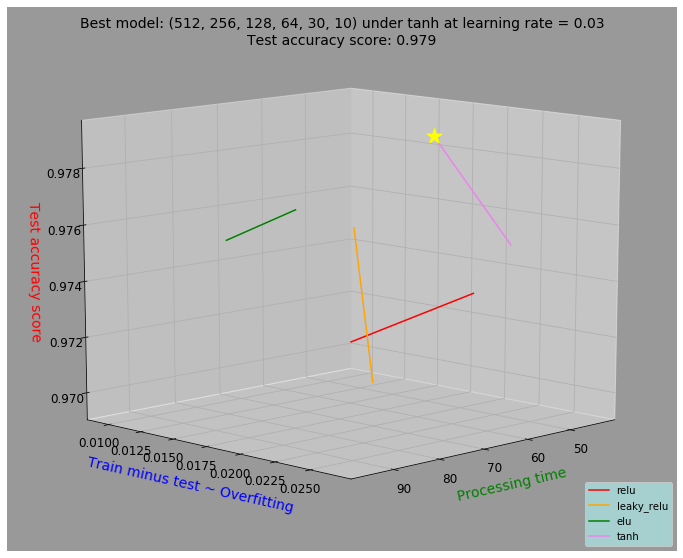

In [117]:
fig = plt.figure(figsize = (12, 10))
ax = fig.gca(projection='3d')
# fig, ax = plt.subplots(figsize = (10, 8))
fig.set_facecolor("white")
ax.set_facecolor("#999999")

ax.set_xlabel("\nProcessing time", color = "green")
ax.set_ylabel("\nTrain minus test ~ Overfitting", color = "b")
ax.set_zlabel("\nTest accuracy score", color = "red")

winning_entry = thousand_frame.sort_values(by = "test", ascending = False).head(1)
winning_score = float(winning_entry.test)
winning_tuple = str(winning_entry.topology).partition("(")[2].partition(")")[0]
winning_func  = str(winning_entry.activation).partition("    ")[2].partition("\n")[0]
winning_rate  = float(winning_entry.rate)
winning_label = "Best model: (" + winning_tuple + ") under " + winning_func
winning_label += " at learning rate = " + str(winning_rate) + "\n"
winning_label += "Test accuracy score: " + str(round(winning_score, 4))

def plot_func_lines(func_name, func_color):
    ax.plot(thousand_frame[thousand_frame.activation == func_name]["time"],
        thousand_frame[thousand_frame.activation == func_name]["train_minus_test"],
        thousand_frame[thousand_frame.activation == func_name]["test"],
        color = func_color, label = func_name)

"""
def scatter_model_dots(model_name, model_color, model_marker):
    ax.scatter(final_pipe[final_pipe.model == model_name]["standardized_time"],
               final_pipe[final_pipe.model == model_name]["train_minus_test"],
               final_pipe[final_pipe.model == model_name]["test_score"],
               s = 96, marker = model_marker, color = model_color, label = model_name)
"""
 
# scatter_model_dots("RandomForest", "red", "o")

plot_func_lines("relu", "red")
plot_func_lines("leaky_relu", "orange")
plot_func_lines("elu", "green")
# plot_func_lines("selu", "blue")
plot_func_lines("tanh", "violet")

x_locate = float(winning_entry.time)
y_locate = float(winning_entry.train_minus_test)

ax.scatter(x_locate, y_locate, winning_score, s = 250, marker = "*", color = "yellow")

time_space =    np.linspace(thousand_frame.time.min(), thousand_frame.time.max(), 120)
overfit_space = np.linspace(thousand_frame.train_minus_test.min(), thousand_frame.train_minus_test.max(), 120)

# plot3d_title = winning_label + " | F1 score ≈ " + str(round(pipe_score, 6))
# plot3d_title +=  "\nStandardized time ≈ " + str(round(x_locate, 6))
# plot3d_title += " | Train minus test ≈ " + str(round(y_locate, 6))
ax.set_title(winning_label, fontsize = 14)

plot_x, plot_y = np.meshgrid(time_space, overfit_space)
score_plane = 0 * plot_x + 0 * plot_y + winning_score

# ax.plot_wireframe(plot_x, plot_y, score_plane, rcount = 6, ccount = 6, color = "orange")

# ax.plot_surface(plot_x, plot_y, score_plane, color = "#00884466")

ax.legend(loc ="lower right", facecolor = "#aadddd22")
ax.view_init(12, 45)
plt.savefig("thousand_frame.png")
plt.savefig("thousand_frame.pdf")

We are still finishing near or above 0.98 test accuracy with processing times — at least for some activation functions — that remain (well) under 90 seconds. But it does appear that we have reached a plateau in predictive performance. We will therefore stop testing models and review our results.

In [118]:
frame_coalition = [combined_frame, longcent_frame, hexsquared_frame, fourhundred_frame, fivefour_frame, thousand_frame]
final_frame = pd.concat(frame_coalition)

In [119]:
final_backup = final_frame.copy()

In [120]:
final_frame.sort_values(by = "test", ascending = False)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
3,"(475, 150)",tanh,0.03,0,0,0.998709,0.9804,0.0183091,72.75
3,"(256,)",tanh,0.05,0,0,0.997655,0.9797,0.0179545,43.531
11,"(250, 100, 50)",tanh,0.03,0,0,0.999309,0.9795,0.0198091,41.953
11,"(300, 135, 90, 60, 30, 10)",tanh,0.03,0,0,0.999636,0.9792,0.0204363,51.063
3,"(512, 256, 128, 64, 30, 10)",tanh,0.03,0,0,0.999127,0.979,0.0201273,56.906
0,"(475, 150)",relu,0.01,0,0,0.995436,0.979,0.0164364,78.313
8,"(192, 64)",tanh,0.05,0,0,0.998145,0.9789,0.0192454,24.61
5,"(300, 100)",leaky_relu,0.05,0,0.002,0.986636,0.9789,0.00773633,53.062
7,"(375, 150, 75, 25)",tanh,0.03,0,0,0.999182,0.9784,0.0207818,52.218
9,"(250, 100, 50)",leaky_relu,0.05,0,0.002,0.987491,0.9783,0.00919092,35.375


In [121]:
final_frame.sort_values(by = "time", ascending = True)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
19,"(30, 10)",tanh,0.1,0.0005,0,0.947255,0.9496,-0.00234544,5.906
10,"(30, 10)",relu,0.05,0.0005,0,0.9634,0.9601,0.00330001,10.203
7,"(30, 10)",elu,0.1,0,0,0.984345,0.9647,0.0196455,10.204
9,"(30, 10)",tanh,0.1,0,0,0.980345,0.9596,0.0207455,10.219
15,"(30, 10)",relu,0.1,0.0005,0,0.949345,0.948,0.00134546,10.954
6,"(30, 10)",leaky_relu,0.1,0,0,0.980527,0.9626,0.0179273,11.125
27,"(30, 10)",elu,0.1,0,0.004,0.958364,0.9588,-0.000436366,11.922
5,"(30, 10)",relu,0.1,0,0,0.987073,0.9674,0.0196727,12.203
14,"(30, 10)",tanh,0.05,0.0005,0,0.960364,0.9559,0.00446361,12.75
0,"(30, 10)",relu,0.05,0,0,0.984764,0.9656,0.0191636,12.797


In [122]:
final_frame.sort_values(by = "train_minus_test", ascending = False)  # Put the most troublesome overfits on top

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
8,"(300, 135, 90, 60, 30, 10)",relu,0.01,0,0,0.994873,0.9679,0.0269728,43.141
4,"(300, 200, 160, 120, 90, 70, 40, 20)",relu,0.01,0,0,1,0.9734,0.0266,95.25
13,"(80, 25, 15)",selu,0.01,0,0,0.996182,0.97,0.0261818,51.797
17,"(160, 56, 30, 10)",selu,0.01,0,0,0.999236,0.9733,0.0259364,73.969
0,"(512, 256, 128, 64, 30, 10)",relu,0.01,0,0,0.999636,0.9741,0.0255364,65.141
14,"(80, 25, 15)",tanh,0.05,0,0,0.998236,0.9751,0.0231364,18.063
13,"(176, 60, 20)",tanh,0.05,0,0,0.998964,0.9769,0.0220637,21.953
12,"(200, 100, 65, 25, 10)",relu,0.01,0,0,0.993273,0.9714,0.0218727,25.64
15,"(200, 100, 65, 25, 10)",tanh,0.03,0,0,0.998309,0.9768,0.0215091,33.797
7,"(300, 200, 160, 120, 90, 70, 40, 20)",tanh,0.03,0,0,0.996364,0.9749,0.0214636,43.047


In [123]:
plotting_frame = final_frame.sort_values(by = "test", ascending = False)
plotting_frame.head(10)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time
3,"(475, 150)",tanh,0.03,0,0,0.998709,0.9804,0.0183091,72.75
3,"(256,)",tanh,0.05,0,0,0.997655,0.9797,0.0179545,43.531
11,"(250, 100, 50)",tanh,0.03,0,0,0.999309,0.9795,0.0198091,41.953
11,"(300, 135, 90, 60, 30, 10)",tanh,0.03,0,0,0.999636,0.9792,0.0204363,51.063
3,"(512, 256, 128, 64, 30, 10)",tanh,0.03,0,0,0.999127,0.979,0.0201273,56.906
0,"(475, 150)",relu,0.01,0,0,0.995436,0.979,0.0164364,78.313
8,"(192, 64)",tanh,0.05,0,0,0.998145,0.9789,0.0192454,24.61
5,"(300, 100)",leaky_relu,0.05,0,0.002,0.986636,0.9789,0.00773633,53.062
7,"(375, 150, 75, 25)",tanh,0.03,0,0,0.999182,0.9784,0.0207818,52.218
9,"(250, 100, 50)",leaky_relu,0.05,0,0.002,0.987491,0.9783,0.00919092,35.375


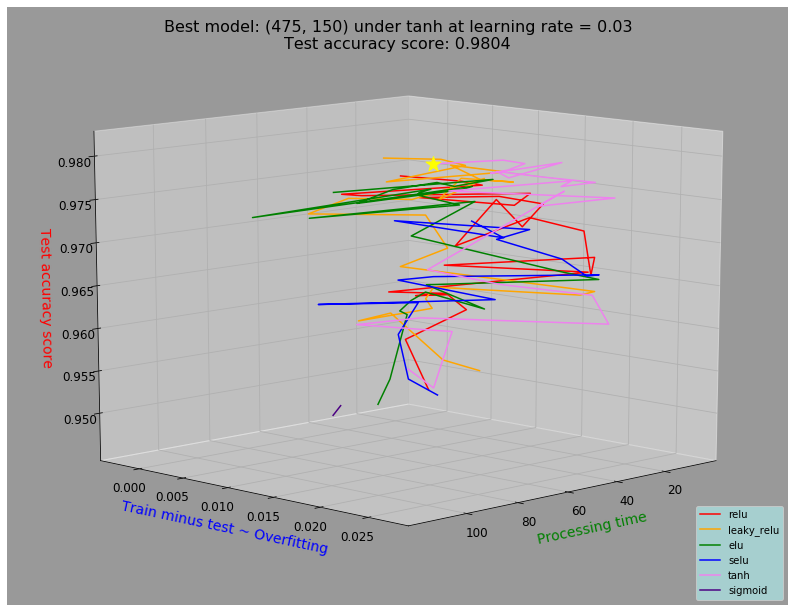

In [124]:
fig = plt.figure(figsize = (14, 11))
ax = fig.gca(projection='3d')
# fig, ax = plt.subplots(figsize = (10, 8))
fig.set_facecolor("white")
ax.set_facecolor("#999999")

ax.set_xlabel("\nProcessing time", color = "green")
ax.set_ylabel("\nTrain minus test ~ Overfitting", color = "blue")
ax.set_zlabel("\nTest accuracy score", color = "red")

winning_entry = plotting_frame.sort_values(by = "test", ascending = False).head(1)
winning_score = float(winning_entry.test)
winning_tuple = str(winning_entry.topology).partition("(")[2].partition(")")[0]
winning_func  = str(winning_entry.activation).partition("    ")[2].partition("\n")[0]
winning_rate  = float(winning_entry.rate)
winning_label = "Best model: (" + winning_tuple + ") under " + winning_func
winning_label += " at learning rate = " + str(winning_rate) + "\n"
winning_label += "Test accuracy score: " + str(round(winning_score, 4))

def plot_func_lines(func_name, func_color):
    ax.plot(plotting_frame[plotting_frame.activation == func_name]["time"],
        plotting_frame[plotting_frame.activation == func_name]["train_minus_test"],
        plotting_frame[plotting_frame.activation == func_name]["test"],
        color = func_color, label = func_name)

"""
def scatter_model_dots(model_name, model_color, model_marker):
    ax.scatter(final_pipe[final_pipe.model == model_name]["standardized_time"],
               final_pipe[final_pipe.model == model_name]["train_minus_test"],
               final_pipe[final_pipe.model == model_name]["test_score"],
               s = 96, marker = model_marker, color = model_color, label = model_name)
"""
 
# scatter_model_dots("RandomForest", "red", "o")

plot_func_lines("relu", "red")
plot_func_lines("leaky_relu", "orange")
plot_func_lines("elu", "green")
plot_func_lines("selu", "blue")
plot_func_lines("tanh", "violet")
plot_func_lines("sigmoid", "indigo")

x_locate = float(winning_entry.time)
y_locate = float(winning_entry.train_minus_test)

ax.scatter(x_locate, y_locate, winning_score, s = 250, marker = "*", color = "yellow")

time_space =    np.linspace(plotting_frame.time.min(), plotting_frame.time.max(), 120)
overfit_space = np.linspace(plotting_frame.train_minus_test.min(), plotting_frame.train_minus_test.max(), 120)

# plot3d_title = winning_label + " | F1 score ≈ " + str(round(pipe_score, 6))
# plot3d_title +=  "\nStandardized time ≈ " + str(round(x_locate, 6))
# plot3d_title += " | Train minus test ≈ " + str(round(y_locate, 6))
ax.set_title(winning_label, fontsize = 16)

plot_x, plot_y = np.meshgrid(time_space, overfit_space)
score_plane = 0 * plot_x + 0 * plot_y + winning_score

# ax.plot_wireframe(plot_x, plot_y, score_plane, rcount = 6, ccount = 6, color = "orange")

# ax.plot_surface(plot_x, plot_y, score_plane, color = "#00884466")

ax.legend(loc ="lower right", facecolor = "#aadddd22")
ax.view_init(12, 45)
plt.savefig("plotting_frame.png")
plt.savefig("plotting_frame.pdf")

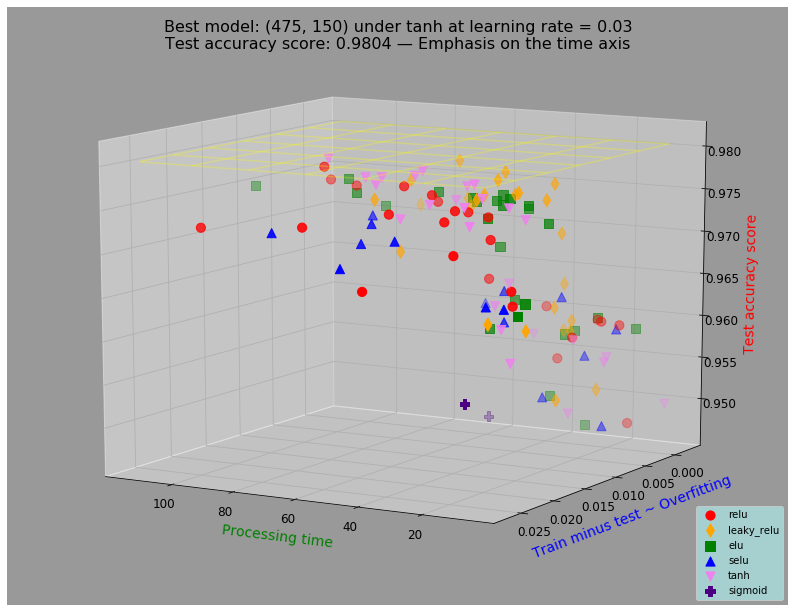

In [125]:
fig = plt.figure(figsize = (14, 11))
ax = fig.gca(projection='3d')
# fig, ax = plt.subplots(figsize = (10, 8))
fig.set_facecolor("white")
ax.set_facecolor("#999999")

ax.set_xlabel("\nProcessing time", color = "green")
ax.set_ylabel("\nTrain minus test ~ Overfitting", color = "blue")
ax.set_zlabel("\nTest accuracy score", color = "red")

winning_entry = plotting_frame.sort_values(by = "test", ascending = False).head(1)
winning_score = float(winning_entry.test)
winning_tuple = str(winning_entry.topology).partition("(")[2].partition(")")[0]
winning_func  = str(winning_entry.activation).partition("    ")[2].partition("\n")[0]
winning_rate  = float(winning_entry.rate)
winning_label = "Best model: (" + winning_tuple + ") under " + winning_func
winning_label += " at learning rate = " + str(winning_rate) + "\n"
winning_label += "Test accuracy score: " + str(round(winning_score, 4))
winning_label += " — Emphasis on the time axis"

def plot_func_lines(func_name, func_color):
    ax.plot(plotting_frame[plotting_frame.activation == func_name]["time"],
        plotting_frame[plotting_frame.activation == func_name]["train_minus_test"],
        plotting_frame[plotting_frame.activation == func_name]["test"],
        color = func_color, label = func_name)


def scatter_func_dots(func_name, func_color, func_marker):
    ax.scatter(plotting_frame[plotting_frame.activation == func_name]["time"].map(lambda x: float(x)),
               plotting_frame[plotting_frame.activation == func_name]["train_minus_test"].map(lambda x: float(x)),
               plotting_frame[plotting_frame.activation == func_name]["test"].map(lambda x: float(x)),
               s = 84, marker = func_marker, color = func_color, label = func_name)

scatter_func_dots("relu", "red", "o")
scatter_func_dots("leaky_relu", "orange", "d")
scatter_func_dots("elu", "green", "s")
scatter_func_dots("selu", "blue", "^")
scatter_func_dots("tanh", "violet", "v")
scatter_func_dots("sigmoid", "indigo", "P")

x_locate = float(winning_entry.time)
y_locate = float(winning_entry.train_minus_test)

# ax.scatter(x_locate, y_locate, winning_score, s = 250, marker = "*", color = "yellow")

time_space =    np.linspace(plotting_frame.time.min(), plotting_frame.time.max(), 120)
overfit_space = np.linspace(plotting_frame.train_minus_test.min(), plotting_frame.train_minus_test.max(), 120)

# plot3d_title = winning_label + " | F1 score ≈ " + str(round(pipe_score, 6))
# plot3d_title +=  "\nStandardized time ≈ " + str(round(x_locate, 6))
# plot3d_title += " | Train minus test ≈ " + str(round(y_locate, 6))
ax.set_title(winning_label, fontsize = 16)

plot_x, plot_y = np.meshgrid(time_space, overfit_space)
score_plane = 0 * plot_x + 0 * plot_y + winning_score

ax.plot_wireframe(plot_x, plot_y, score_plane, rcount = 6, ccount = 6, color = "#ffff0044")

# ax.plot_surface(plot_x, plot_y, score_plane, color = "#00884466")

ax.legend(loc ="lower right", facecolor = "#aadddd22")
ax.view_init(12, 120)
plt.savefig("time_view_scatter.png")
plt.savefig("time_view_scatter.pdf")

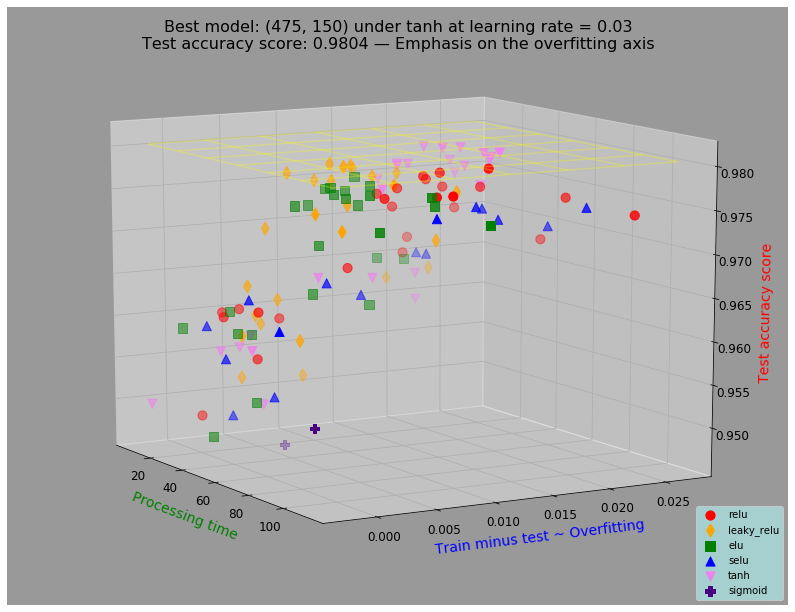

In [126]:
fig = plt.figure(figsize = (14, 11))
ax = fig.gca(projection='3d')
# fig, ax = plt.subplots(figsize = (10, 8))
fig.set_facecolor("white")
ax.set_facecolor("#999999")

ax.set_xlabel("\nProcessing time", color = "green")
ax.set_ylabel("\nTrain minus test ~ Overfitting", color = "blue")
ax.set_zlabel("\nTest accuracy score", color = "red")

winning_entry = plotting_frame.sort_values(by = "test", ascending = False).head(1)
winning_score = float(winning_entry.test)
winning_tuple = str(winning_entry.topology).partition("(")[2].partition(")")[0]
winning_func  = str(winning_entry.activation).partition("    ")[2].partition("\n")[0]
winning_rate  = float(winning_entry.rate)
winning_label = "Best model: (" + winning_tuple + ") under " + winning_func
winning_label += " at learning rate = " + str(winning_rate) + "\n"
winning_label += "Test accuracy score: " + str(round(winning_score, 4))
winning_label += " — Emphasis on the overfitting axis"

def plot_func_lines(func_name, func_color):
    ax.plot(plotting_frame[plotting_frame.activation == func_name]["time"],
        plotting_frame[plotting_frame.activation == func_name]["train_minus_test"],
        plotting_frame[plotting_frame.activation == func_name]["test"],
        color = func_color, label = func_name)


def scatter_func_dots(func_name, func_color, func_marker):
    ax.scatter(plotting_frame[plotting_frame.activation == func_name]["time"].map(lambda x: float(x)),
               plotting_frame[plotting_frame.activation == func_name]["train_minus_test"].map(lambda x: float(x)),
               plotting_frame[plotting_frame.activation == func_name]["test"].map(lambda x: float(x)),
               s = 84, marker = func_marker, color = func_color, label = func_name)

scatter_func_dots("relu", "red", "o")
scatter_func_dots("leaky_relu", "orange", "d")
scatter_func_dots("elu", "green", "s")
scatter_func_dots("selu", "blue", "^")
scatter_func_dots("tanh", "violet", "v")
scatter_func_dots("sigmoid", "indigo", "P")

x_locate = float(winning_entry.time)
y_locate = float(winning_entry.train_minus_test)

# ax.scatter(x_locate, y_locate, winning_score, s = 250, marker = "*", color = "yellow")

time_space =    np.linspace(plotting_frame.time.min(), plotting_frame.time.max(), 120)
overfit_space = np.linspace(plotting_frame.train_minus_test.min(), plotting_frame.train_minus_test.max(), 120)

# plot3d_title = winning_label + " | F1 score ≈ " + str(round(pipe_score, 6))
# plot3d_title +=  "\nStandardized time ≈ " + str(round(x_locate, 6))
# plot3d_title += " | Train minus test ≈ " + str(round(y_locate, 6))
ax.set_title(winning_label, fontsize = 16)

plot_x, plot_y = np.meshgrid(time_space, overfit_space)
score_plane = 0 * plot_x + 0 * plot_y + winning_score

ax.plot_wireframe(plot_x, plot_y, score_plane, rcount = 6, ccount = 6, color = "#ffff0044")

# ax.plot_surface(plot_x, plot_y, score_plane, color = "#00884466")

ax.legend(loc ="lower right", facecolor = "#aadddd22")
ax.view_init(12, 330)
plt.savefig("overfitting_view_scatter.png")
plt.savefig("overfitting_view_scatter.pdf")

In [127]:
plotting_backup = plotting_frame.copy()

In [128]:
plotting_backup["depth"] = plotting_backup["topology"].map(lambda x: len(x))
plotting_backup["neurons"] = plotting_backup["topology"].map(sum)
plotting_backup.head(10)

,topology,activation,rate,L1,L2,train,test,train_minus_test,time,depth,neurons
3,"(475, 150)",tanh,0.03,0,0,0.998709,0.9804,0.0183091,72.75,2,625
3,"(256,)",tanh,0.05,0,0,0.997655,0.9797,0.0179545,43.531,1,256
11,"(250, 100, 50)",tanh,0.03,0,0,0.999309,0.9795,0.0198091,41.953,3,400
11,"(300, 135, 90, 60, 30, 10)",tanh,0.03,0,0,0.999636,0.9792,0.0204363,51.063,6,625
3,"(512, 256, 128, 64, 30, 10)",tanh,0.03,0,0,0.999127,0.979,0.0201273,56.906,6,1000
0,"(475, 150)",relu,0.01,0,0,0.995436,0.979,0.0164364,78.313,2,625
8,"(192, 64)",tanh,0.05,0,0,0.998145,0.9789,0.0192454,24.61,2,256
5,"(300, 100)",leaky_relu,0.05,0,0.002,0.986636,0.9789,0.00773633,53.062,2,400
7,"(375, 150, 75, 25)",tanh,0.03,0,0,0.999182,0.9784,0.0207818,52.218,4,625
9,"(250, 100, 50)",leaky_relu,0.05,0,0.002,0.987491,0.9783,0.00919092,35.375,3,400


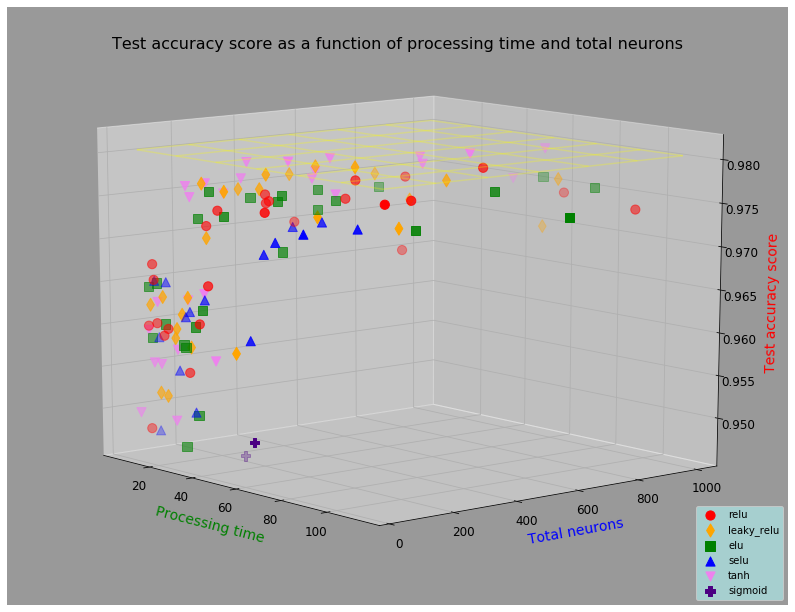

In [129]:
fig = plt.figure(figsize = (14, 11))
ax = fig.gca(projection='3d')
# fig, ax = plt.subplots(figsize = (10, 8))
fig.set_facecolor("white")
ax.set_facecolor("#999999")

ax.set_xlabel("\nProcessing time", color = "green")
ax.set_ylabel("\nTotal neurons", color = "blue")
ax.set_zlabel("\nTest accuracy score", color = "red")

winning_entry = plotting_backup.sort_values(by = "test", ascending = False).head(1)
winning_score = float(winning_entry.test)
winning_tuple = str(winning_entry.topology).partition("(")[2].partition(")")[0]
winning_func  = str(winning_entry.activation).partition("    ")[2].partition("\n")[0]
winning_rate  = float(winning_entry.rate)
winning_label = "Best model: (" + winning_tuple + ") under " + winning_func
winning_label += " at learning rate = " + str(winning_rate) + "\n"
winning_label += "Test accuracy score: " + str(round(winning_score, 4))
winning_label += " — Emphasis on the time axis"

winning_label = "Test accuracy score as a function of processing time and total neurons"

def plot_func_lines(func_name, func_color):
    ax.plot(plotting_backup[plotting_backup.activation == func_name]["time"],
        plotting_backup[plotting_backup.activation == func_name]["train_minus_test"],
        plotting_backup[plotting_backup.activation == func_name]["test"],
        color = func_color, label = func_name)

def scatter_func_dots(func_name, func_color, func_marker):
    ax.scatter(plotting_backup[plotting_backup.activation == func_name]["time"].map(lambda x: float(x)),
               plotting_backup[plotting_backup.activation == func_name]["neurons"].map(lambda x: int(x)),
               plotting_backup[plotting_backup.activation == func_name]["test"].map(lambda x: float(x)),
               s = 84, marker = func_marker, color = func_color, label = func_name)

scatter_func_dots("relu", "red", "o")
scatter_func_dots("leaky_relu", "orange", "d")
scatter_func_dots("elu", "green", "s")
scatter_func_dots("selu", "blue", "^")
scatter_func_dots("tanh", "violet", "v")
scatter_func_dots("sigmoid", "indigo", "P")

x_locate = float(winning_entry.time)
y_locate = float(winning_entry.train_minus_test)

# ax.scatter(x_locate, y_locate, winning_score, s = 250, marker = "*", color = "yellow")

time_space =    np.linspace(plotting_backup.time.min(), plotting_backup.time.max(), 120)
overfit_space = np.linspace(plotting_backup.neurons.min(), plotting_backup.neurons.max(), 120)

# plot3d_title = winning_label + " | F1 score ≈ " + str(round(pipe_score, 6))
# plot3d_title +=  "\nStandardized time ≈ " + str(round(x_locate, 6))
# plot3d_title += " | Train minus test ≈ " + str(round(y_locate, 6))
ax.set_title(winning_label, fontsize = 16)

plot_x, plot_y = np.meshgrid(time_space, overfit_space)
score_plane = 0 * plot_x + 0 * plot_y + winning_score

ax.plot_wireframe(plot_x, plot_y, score_plane, rcount = 6, ccount = 6, color = "#ffff0044")

# ax.plot_surface(plot_x, plot_y, score_plane, color = "#00884466")

ax.legend(loc ="lower right", facecolor = "#aadddd22")
ax.view_init(12, 320)
plt.savefig("time_x_neurons_scatter.png")
plt.savefig("time_x_neurons_scatter.pdf")

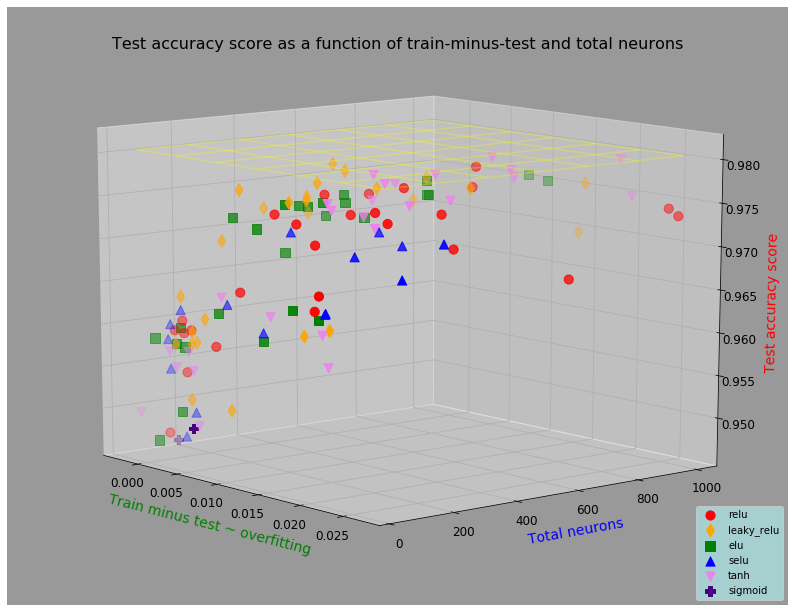

In [130]:
fig = plt.figure(figsize = (14, 11))
ax = fig.gca(projection='3d')
# fig, ax = plt.subplots(figsize = (10, 8))
fig.set_facecolor("white")
ax.set_facecolor("#999999")

ax.set_xlabel("\nTrain minus test ~ overfitting", color = "green")
ax.set_ylabel("\nTotal neurons", color = "blue")
ax.set_zlabel("\nTest accuracy score", color = "red")

winning_entry = plotting_backup.sort_values(by = "test", ascending = False).head(1)
winning_score = float(winning_entry.test)
winning_tuple = str(winning_entry.topology).partition("(")[2].partition(")")[0]
winning_func  = str(winning_entry.activation).partition("    ")[2].partition("\n")[0]
winning_rate  = float(winning_entry.rate)
winning_label = "Best model: (" + winning_tuple + ") under " + winning_func
winning_label += " at learning rate = " + str(winning_rate) + "\n"
winning_label += "Test accuracy score: " + str(round(winning_score, 4))
winning_label += " — Emphasis on the time axis"

winning_label = "Test accuracy score as a function of train-minus-test and total neurons"

def plot_func_lines(func_name, func_color):
    ax.plot(plotting_backup[plotting_backup.activation == func_name]["time"],
        plotting_backup[plotting_backup.activation == func_name]["train_minus_test"],
        plotting_backup[plotting_backup.activation == func_name]["test"],
        color = func_color, label = func_name)

def scatter_func_dots(func_name, func_color, func_marker):
    ax.scatter(plotting_backup[plotting_backup.activation == func_name]["train_minus_test"].map(lambda x: float(x)),
               plotting_backup[plotting_backup.activation == func_name]["neurons"].map(lambda x: int(x)),
               plotting_backup[plotting_backup.activation == func_name]["test"].map(lambda x: float(x)),
               s = 84, marker = func_marker, color = func_color, label = func_name)

scatter_func_dots("relu", "red", "o")
scatter_func_dots("leaky_relu", "orange", "d")
scatter_func_dots("elu", "green", "s")
scatter_func_dots("selu", "blue", "^")
scatter_func_dots("tanh", "violet", "v")
scatter_func_dots("sigmoid", "indigo", "P")

x_locate = float(winning_entry.time)
y_locate = float(winning_entry.train_minus_test)

# ax.scatter(x_locate, y_locate, winning_score, s = 250, marker = "*", color = "yellow")

time_space =    np.linspace(plotting_backup.train_minus_test.min(), plotting_backup.train_minus_test.max(), 120)
overfit_space = np.linspace(plotting_backup.neurons.min(), plotting_backup.neurons.max(), 120)

# plot3d_title = winning_label + " | F1 score ≈ " + str(round(pipe_score, 6))
# plot3d_title +=  "\nStandardized time ≈ " + str(round(x_locate, 6))
# plot3d_title += " | Train minus test ≈ " + str(round(y_locate, 6))
ax.set_title(winning_label, fontsize = 16)

plot_x, plot_y = np.meshgrid(time_space, overfit_space)
score_plane = 0 * plot_x + 0 * plot_y + winning_score

ax.plot_wireframe(plot_x, plot_y, score_plane, rcount = 6, ccount = 6, color = "#ffff0044")

# ax.plot_surface(plot_x, plot_y, score_plane, color = "#00884466")

ax.legend(loc ="lower right", facecolor = "#aadddd22")
ax.view_init(12, 320)
plt.savefig("overfitting_x_neurons_scatter.png")
plt.savefig("overfitting_x_neurons_scatter.pdf")

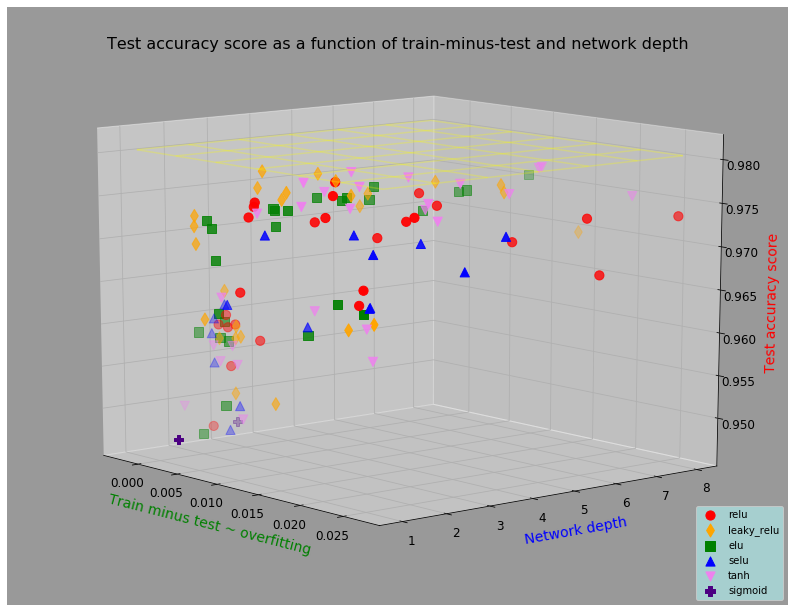

In [131]:
fig = plt.figure(figsize = (14, 11))
ax = fig.gca(projection='3d')
# fig, ax = plt.subplots(figsize = (10, 8))
fig.set_facecolor("white")
ax.set_facecolor("#999999")

ax.set_xlabel("\nTrain minus test ~ overfitting", color = "green")
ax.set_ylabel("\nNetwork depth", color = "blue")
ax.set_zlabel("\nTest accuracy score", color = "red")

winning_entry = plotting_backup.sort_values(by = "test", ascending = False).head(1)
winning_score = float(winning_entry.test)
winning_tuple = str(winning_entry.topology).partition("(")[2].partition(")")[0]
winning_func  = str(winning_entry.activation).partition("    ")[2].partition("\n")[0]
winning_rate  = float(winning_entry.rate)
winning_label = "Best model: (" + winning_tuple + ") under " + winning_func
winning_label += " at learning rate = " + str(winning_rate) + "\n"
winning_label += "Test accuracy score: " + str(round(winning_score, 4))
winning_label += " — Emphasis on the time axis"

winning_label = "Test accuracy score as a function of train-minus-test and network depth"

def plot_func_lines(func_name, func_color):
    ax.plot(plotting_backup[plotting_backup.activation == func_name]["time"],
        plotting_backup[plotting_backup.activation == func_name]["train_minus_test"],
        plotting_backup[plotting_backup.activation == func_name]["test"],
        color = func_color, label = func_name)

def scatter_func_dots(func_name, func_color, func_marker):
    ax.scatter(plotting_backup[plotting_backup.activation == func_name]["train_minus_test"].map(lambda x: float(x)),
               plotting_backup[plotting_backup.activation == func_name]["depth"].map(lambda x: int(x)),
               plotting_backup[plotting_backup.activation == func_name]["test"].map(lambda x: float(x)),
               s = 84, marker = func_marker, color = func_color, label = func_name)

scatter_func_dots("relu", "red", "o")
scatter_func_dots("leaky_relu", "orange", "d")
scatter_func_dots("elu", "green", "s")
scatter_func_dots("selu", "blue", "^")
scatter_func_dots("tanh", "violet", "v")
scatter_func_dots("sigmoid", "indigo", "P")

x_locate = float(winning_entry.time)
y_locate = float(winning_entry.train_minus_test)

# ax.scatter(x_locate, y_locate, winning_score, s = 250, marker = "*", color = "yellow")

time_space =    np.linspace(plotting_backup.train_minus_test.min(), plotting_backup.train_minus_test.max(), 120)
overfit_space = np.linspace(plotting_backup.depth.min(), plotting_backup.depth.max(), 120)

# plot3d_title = winning_label + " | F1 score ≈ " + str(round(pipe_score, 6))
# plot3d_title +=  "\nStandardized time ≈ " + str(round(x_locate, 6))
# plot3d_title += " | Train minus test ≈ " + str(round(y_locate, 6))
ax.set_title(winning_label, fontsize = 16)

plot_x, plot_y = np.meshgrid(time_space, overfit_space)
score_plane = 0 * plot_x + 0 * plot_y + winning_score

ax.plot_wireframe(plot_x, plot_y, score_plane, rcount = 6, ccount = 6, color = "#ffff0044")

# ax.plot_surface(plot_x, plot_y, score_plane, color = "#00884466")

ax.legend(loc ="lower right", facecolor = "#aadddd22")
ax.view_init(12, 320)
plt.savefig("overfitting_x_depth_scatter.png")
plt.savefig("overfitting_x_depth_scatter.pdf")

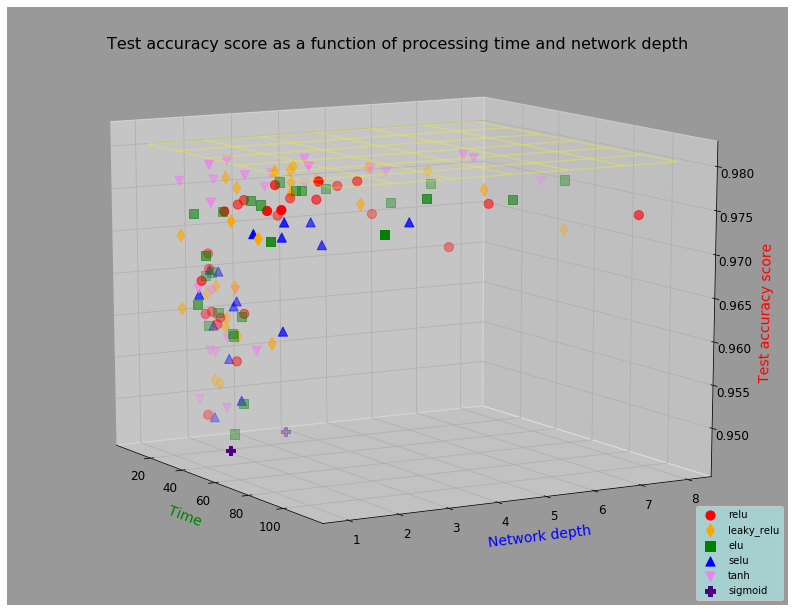

In [132]:
fig = plt.figure(figsize = (14, 11))
ax = fig.gca(projection='3d')
# fig, ax = plt.subplots(figsize = (10, 8))
fig.set_facecolor("white")
ax.set_facecolor("#999999")

ax.set_xlabel("\nTime", color = "green")
ax.set_ylabel("\nNetwork depth", color = "blue")
ax.set_zlabel("\nTest accuracy score", color = "red")

winning_entry = plotting_backup.sort_values(by = "test", ascending = False).head(1)
winning_score = float(winning_entry.test)
winning_tuple = str(winning_entry.topology).partition("(")[2].partition(")")[0]
winning_func  = str(winning_entry.activation).partition("    ")[2].partition("\n")[0]
winning_rate  = float(winning_entry.rate)
winning_label = "Best model: (" + winning_tuple + ") under " + winning_func
winning_label += " at learning rate = " + str(winning_rate) + "\n"
winning_label += "Test accuracy score: " + str(round(winning_score, 4))
winning_label += " — Emphasis on the time axis"

winning_label = "Test accuracy score as a function of processing time and network depth"

def plot_func_lines(func_name, func_color):
    ax.plot(plotting_backup[plotting_backup.activation == func_name]["time"],
        plotting_backup[plotting_backup.activation == func_name]["train_minus_test"],
        plotting_backup[plotting_backup.activation == func_name]["test"],
        color = func_color, label = func_name)

def scatter_func_dots(func_name, func_color, func_marker):
    ax.scatter(plotting_backup[plotting_backup.activation == func_name]["time"].map(lambda x: float(x)),
               plotting_backup[plotting_backup.activation == func_name]["depth"].map(lambda x: int(x)),
               plotting_backup[plotting_backup.activation == func_name]["test"].map(lambda x: float(x)),
               s = 84, marker = func_marker, color = func_color, label = func_name)

scatter_func_dots("relu", "red", "o")
scatter_func_dots("leaky_relu", "orange", "d")
scatter_func_dots("elu", "green", "s")
scatter_func_dots("selu", "blue", "^")
scatter_func_dots("tanh", "violet", "v")
scatter_func_dots("sigmoid", "indigo", "P")

x_locate = float(winning_entry.time)
y_locate = float(winning_entry.train_minus_test)

# ax.scatter(x_locate, y_locate, winning_score, s = 250, marker = "*", color = "yellow")

time_space =    np.linspace(plotting_backup.time.min(), plotting_backup.time.max(), 120)
overfit_space = np.linspace(plotting_backup.depth.min(), plotting_backup.depth.max(), 120)

# plot3d_title = winning_label + " | F1 score ≈ " + str(round(pipe_score, 6))
# plot3d_title +=  "\nStandardized time ≈ " + str(round(x_locate, 6))
# plot3d_title += " | Train minus test ≈ " + str(round(y_locate, 6))
ax.set_title(winning_label, fontsize = 16)

plot_x, plot_y = np.meshgrid(time_space, overfit_space)
score_plane = 0 * plot_x + 0 * plot_y + winning_score

ax.plot_wireframe(plot_x, plot_y, score_plane, rcount = 6, ccount = 6, color = "#ffff0044")

# ax.plot_surface(plot_x, plot_y, score_plane, color = "#00884466")

ax.legend(loc ="lower right", facecolor = "#aadddd22")
ax.view_init(12, 330)
plt.savefig("time_x_depth_scatter.png")
plt.savefig("time_x_depth_scatter.pdf")

In [133]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X_plot = plotting_frame[["time", "train_minus_test"]].values
y_plot_series = plotting_frame.test.map(lambda x: float(x))
y_plot = []
for i in range(len(y_plot_series)):
    y_plot += [y_plot_series.iloc[i]]
poly_2 = PolynomialFeatures(degree = 2)
X_poly = poly_2.fit_transform(X_plot)
lin_reg = LinearRegression()
polynomial_model = lin_reg.fit(X_poly, y_plot)
linear_model = lin_reg.fit(X_plot, y_plot)

In [135]:
# polynomial_model.score(X_poly, y_plot)

In [136]:
linear_model.intercept_

0.9549255605752615

In [137]:
coefficients = polynomial_model.coef_
intercept = polynomial_model.intercept_
coefficients

array([1.47183773e-04, 6.73875474e-01])

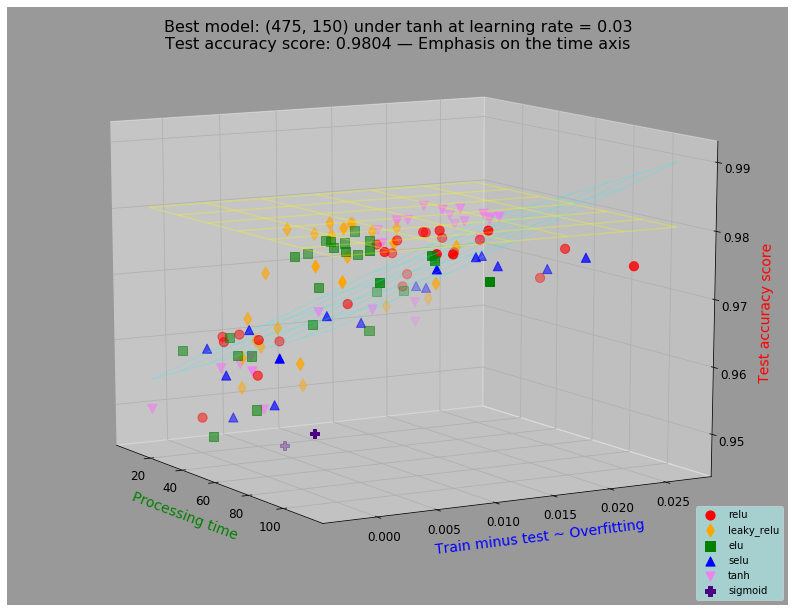

In [138]:
fig = plt.figure(figsize = (14, 11))
ax = fig.gca(projection='3d')
# fig, ax = plt.subplots(figsize = (10, 8))
fig.set_facecolor("white")
ax.set_facecolor("#999999")

ax.set_xlabel("\nProcessing time", color = "green")
ax.set_ylabel("\nTrain minus test ~ Overfitting", color = "blue")
ax.set_zlabel("\nTest accuracy score", color = "red")

winning_entry = plotting_frame.sort_values(by = "test", ascending = False).head(1)
winning_score = float(winning_entry.test)
winning_tuple = str(winning_entry.topology).partition("(")[2].partition(")")[0]
winning_func  = str(winning_entry.activation).partition("    ")[2].partition("\n")[0]
winning_rate  = float(winning_entry.rate)
winning_label = "Best model: (" + winning_tuple + ") under " + winning_func
winning_label += " at learning rate = " + str(winning_rate) + "\n"
winning_label += "Test accuracy score: " + str(round(winning_score, 4))
winning_label += " — Emphasis on the time axis"

def plot_func_lines(func_name, func_color):
    ax.plot(plotting_frame[plotting_frame.activation == func_name]["time"],
        plotting_frame[plotting_frame.activation == func_name]["train_minus_test"],
        plotting_frame[plotting_frame.activation == func_name]["test"],
        color = func_color, label = func_name)


def scatter_func_dots(func_name, func_color, func_marker):
    ax.scatter(plotting_frame[plotting_frame.activation == func_name]["time"].map(lambda x: float(x)),
               plotting_frame[plotting_frame.activation == func_name]["train_minus_test"].map(lambda x: float(x)),
               plotting_frame[plotting_frame.activation == func_name]["test"].map(lambda x: float(x)),
               s = 84, marker = func_marker, color = func_color, label = func_name)

scatter_func_dots("relu", "red", "o")
scatter_func_dots("leaky_relu", "orange", "d")
scatter_func_dots("elu", "green", "s")
scatter_func_dots("selu", "blue", "^")
scatter_func_dots("tanh", "violet", "v")
scatter_func_dots("sigmoid", "indigo", "P")

x_locate = float(winning_entry.time)
y_locate = float(winning_entry.train_minus_test)

# ax.scatter(x_locate, y_locate, winning_score, s = 250, marker = "*", color = "yellow")

time_space =    np.linspace(plotting_frame.time.min(), plotting_frame.time.max(), 120)
overfit_space = np.linspace(plotting_frame.train_minus_test.min(), plotting_frame.train_minus_test.max(), 120)

# plot3d_title = winning_label + " | F1 score ≈ " + str(round(pipe_score, 6))
# plot3d_title +=  "\nStandardized time ≈ " + str(round(x_locate, 6))
# plot3d_title += " | Train minus test ≈ " + str(round(y_locate, 6))
ax.set_title(winning_label, fontsize = 16)

plot_x, plot_y = np.meshgrid(time_space, overfit_space)
score_plane = 0 * plot_x + 0 * plot_y + winning_score
fit_plane = linear_model.coef_[0] * plot_x + linear_model.coef_[1] * plot_y + linear_model.intercept_

ax.plot_wireframe(plot_x, plot_y, score_plane, rcount = 6, ccount = 6, color = "#ffff0044")

# polynomial_fit = coefficients[1] * plot_x + coefficients[2] * plot_y + coefficients[3] * plot_x * plot_y
# polynomial_fit += coefficients[4] * plot_x ** 2 + coefficients[5] * plot_y ** 2 + intercept
ax.plot_wireframe(plot_x, plot_y, fit_plane, rstride = 20, cstride = 20, color = "#00ffff33", linewidth = 1)

# ax.plot_surface(plot_x, plot_y, score_plane, color = "#00884466")

ax.legend(loc ="lower right", facecolor = "#aadddd22")
ax.view_init(12, 330)
# plt.savefig("polynomial_scatter.png")
# plt.savefig("polynomial_scatter.pdf")

Finish with reports on performance and processing time!

In [139]:
#sum(X_poly[0] * coefficients) + intercept
#len(np.meshgrid(X_poly)[0])

ValueError: operands could not be broadcast together with shapes (6,) (2,) 

In [141]:
# We're done! Print out the timekeeping data

print_prof_data()


            Function	  Category	   Calls	     Total	   Average	   Std dev	   Maximum
__________________________________________________________________________________________________________________

          mnist_prep	     setup	       1	   22.9060	   22.9060	    0.0000	   22.9060
        minmax_scale	     setup	       1	    0.6560	    0.6560	    0.0000	    0.6560
mlp_activation_search	   sklearn	       1	 1126.9530	 1126.9530	    0.0000	 1126.9530
    mlp_alpha_search	   sklearn	       1	 1546.8280	 1546.8280	    0.0000	 1546.8280
             mlp_fit	   sklearn	       1	   93.5310	   93.5310	    0.0000	   93.5310
          mlp_report	   sklearn	       1	    0.6560	    0.6560	    0.0000	    0.6560
         purple_haze	scoreboard	      14	    7.8310	    0.5594	    0.0444	    0.6410
             dnn_clf	  tf_basic	       1	    0.9530	    0.9530	    0.0000	    0.9530
             dnn_fit	  tf_basic	       1	  110.8130	  110.8130	    0.0000	  110.8130
          dnn_report	  tf_basic	

In [142]:
# We can also export PROF_DATA to a DataFrame for nicer display and possibly also for future use
# Display the refined dataframe so that …
#   1. It suppresses the individual times, without deleting that information
#   2. It is sorted in descending order of total time taken

profile_frame = pd.DataFrame(PROF_DATA)
profile_frame = profile_frame.transpose()
profile_frame.columns = ["calls", "times"]
profile_frame["total"] = profile_frame.times.map(sum)
profile_frame["average"] = profile_frame.times.map(np.mean)
profile_frame["std_dev"] = profile_frame.times.map(np.std)
profile_frame["maximum"] = profile_frame.times.map(max)
profile_frame["minimum"] = profile_frame.times.map(min)
for function in profile_frame.index:
    profile_frame.loc[function, "category"] = DATA_CATEGORIES[function]

print("\t*** Timekeeping summary of profiled functions ***\n")
print("{:d} profiled functions took {:d} calls for {:.6f} total seconds, an average of {:.6f}.".format(len(profile_frame), profile_frame.calls.sum(), profile_frame.total.sum(), profile_frame.total.mean()))

profile_frame.loc[:, ["category", "calls", "total", "average", "std_dev", "maximum", "minimum"]].sort_values(by = "total", ascending = False)

	*** Timekeeping summary of profiled functions ***

15 profiled functions took 4476 calls for 7879.955000 total seconds, an average of 525.330333.


,category,calls,total,average,std_dev,maximum,minimum
fill_frame,tf_full,7,4507.798,643.971143,152.926249,863.750,410.187
mlp_alpha_search,sklearn,1,1546.828,1546.828000,0.000000,1546.828,1546.828
mlp_activation_search,sklearn,1,1126.953,1126.953000,0.000000,1126.953,1126.953
run_one_tf_model,tf_full,8,457.468,57.183500,47.212551,167.406,21.687
dnn_fit,tf_basic,1,110.813,110.813000,0.000000,110.813,110.813
mlp_fit,sklearn,1,93.531,93.531000,0.000000,93.531,93.531
mnist_prep,setup,1,22.906,22.906000,0.000000,22.906,22.906
purple_haze,scoreboard,14,7.831,0.559357,0.044353,0.641,0.500
dnn_report,tf_basic,1,2.406,2.406000,0.000000,2.406,2.406
dnn_clf,tf_basic,1,0.953,0.953000,0.000000,0.953,0.953


In [143]:
profile_frame.loc[:, ["category", "calls", "total", "average", "std_dev", "maximum", "minimum"]].sort_values(by = ["category", "total"], ascending = False)

,category,calls,total,average,std_dev,maximum,minimum
demo_plot,tf_setup,6,0.734,0.122333,0.010515,0.140,0.109
tf_mnist,tf_setup,1,0.422,0.422000,0.000000,0.422,0.422
shuffle_batch,tf_setup,4431,0.000,0.000000,0.000000,0.000,0.000
fill_frame,tf_full,7,4507.798,643.971143,152.926249,863.750,410.187
run_one_tf_model,tf_full,8,457.468,57.183500,47.212551,167.406,21.687
dnn_fit,tf_basic,1,110.813,110.813000,0.000000,110.813,110.813
dnn_report,tf_basic,1,2.406,2.406000,0.000000,2.406,2.406
dnn_clf,tf_basic,1,0.953,0.953000,0.000000,0.953,0.953
mlp_alpha_search,sklearn,1,1546.828,1546.828000,0.000000,1546.828,1546.828
mlp_activation_search,sklearn,1,1126.953,1126.953000,0.000000,1126.953,1126.953


In [144]:
profile_frame[profile_frame.category == "scoreboard"].loc[:, ["calls", "total", "average", "std_dev", "maximum", "minimum"]].sort_values(by = "total", ascending = False)

,calls,total,average,std_dev,maximum,minimum
purple_haze,14,7.831,0.559357,0.044353,0.641,0.5


In [145]:
profile_frame[profile_frame.category == "tf_basic"].loc[:, ["calls", "total", "average", "std_dev", "maximum", "minimum"]].sort_values(by = "total", ascending = False)

,calls,total,average,std_dev,maximum,minimum
dnn_fit,1,110.813,110.813,0.0,110.813,110.813
dnn_report,1,2.406,2.406,0.0,2.406,2.406
dnn_clf,1,0.953,0.953,0.0,0.953,0.953


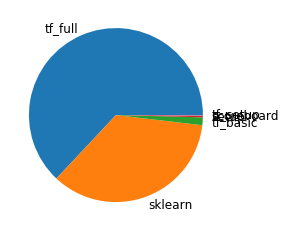

In [146]:
plt.pie(profile_frame.groupby("category")["total"].sum().sort_values(ascending = False), labels = profile_frame.groupby("category")["total"].sum().sort_values(ascending = False).index)
plt.savefig("time_pie.png")
plt.savefig("time_pie.pdf")

In [147]:
profile_frame.groupby("category")["total"].sum().sort_values(ascending = False).index

Index(['tf_full', 'sklearn', 'tf_basic', 'setup', 'scoreboard', 'tf_setup'], dtype='object', name='category')

In [148]:
profile_frame.groupby("category")["total"].sum().sort_values(ascending = False)

category
tf_full       4965.266
sklearn       2767.968
tf_basic       114.172
setup           23.562
scoreboard       7.831
tf_setup         1.156
Name: total, dtype: float64